In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.cuda import amp
from torchmetrics import MeanMetric
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

from natsort import natsorted
from os import listdir
from tqdm import tqdm
import math
import random
import numpy as np
import gc
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy 

/home/sgao30/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GaussianFourierProjection(nn.Module): # this is time embedding layer
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embed_dim//2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [3]:
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [4]:
class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)  # output_dim is the number of channel
  def forward(self, x):
    return self.dense(x)[..., None]
    # this broadcast the 2d tensor to 3d, add the same value across space.

In [5]:
class AttentionBlock(nn.Module):
    def __init__(self, num_channels, layer_length, num_head = 8):
        super().__init__()
        self.num_channels = num_channels
        self.num_head = num_head
        self.ln = nn.LayerNorm([num_channels, layer_length])
        self.mhsa = nn.MultiheadAttention(embed_dim=self.num_channels, num_heads = self.num_head, batch_first=True)
        self.gamma = nn.Parameter(torch.tensor([1.0]))
    
    def forward(self, x):
        N, _, L = x.shape
        out = self.ln(x)
        out = out.swapaxes(1, 2)
        out, _ = self.mhsa(out, out, out)
        out = out.swapaxes(2, 1)
        return self.gamma*out+x

In [6]:
class UNet_res(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, seq_length=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )

    ##################
    ## DownSampling ##
    ##################
    # add time embedding to original data
    self.dense0 = Dense(embed_dim, 1)

    # first downsampling block
    self.conv1 = nn.Conv1d(1, channels[0], 5, stride=1, padding=2)
    self.conv1_2 = nn.Conv1d(channels[0], channels[0], 4, stride=2, padding=1)

    # add time embedding to the output of first downsampling block
    self.dense1 = Dense(embed_dim, channels[0])

    # self attention layer 1
    self.attention1 = AttentionBlock(channels[0], seq_length//2)
    
    # batch normalization 1 
    self.bnorm1 = nn.LayerNorm([channels[0], seq_length//2])
    
    # second downsampling block
    self.conv2 = nn.Conv1d(channels[0], channels[1], 5, stride=1, padding=2)
    self.conv2_2 = nn.Conv1d(channels[1], channels[1], 4, stride=2, padding=1)

    # add time embedding to the output of second downsampling block
    self.dense2 = Dense(embed_dim, channels[1])
    
    # self attention layer 2
    self.attention2 = AttentionBlock(channels[1], seq_length//4)
    
    # batch normalization 2 
    self.bnorm2 = nn.LayerNorm([channels[1], seq_length//4])

    # third downsampling block
    self.conv3 = nn.Conv1d(channels[1], channels[2], 5, stride=1, padding=2)
    self.conv3_2 = nn.Conv1d(channels[2], channels[2], 4, stride=2, padding=1)

    # add time embedding to the output of third downsampling block
    self.dense3 = Dense(embed_dim, channels[2])
      
    # self attention layer 3
    self.attention3 = AttentionBlock(channels[2], seq_length//8)
    
    # batch normalization 3 
    self.bnorm3 = nn.LayerNorm([channels[2], seq_length//8])
    ##################

    ##################
    ## MiddleLayers ##
    ##################

    # middle layer block
    self.conv_mid = nn.Conv1d(channels[2], channels[3], 1, stride=1, padding=0)
    self.conv_mid_2 = nn.Conv1d(channels[3], channels[2], 1, stride=1, padding=0)

    # add time embedding to the output of middle layer block
    self.dense4 = Dense(embed_dim, channels[2])

    # self attention layer 4
    self.attention4 = AttentionBlock(channels[2], seq_length//8)

    # batch normalization 4 
    self.bnorm4 = nn.LayerNorm([channels[2], seq_length//8])
    
    ##################
    ### UpSampling ###
    ##################

    # first upsampling block
    self.tconv3 = nn.Conv1d(channels[3], channels[2], 5, stride=1, padding=2)
    self.tconv3_2 = nn.Conv1d(channels[2], channels[2], 5, stride=1, padding=2)
    self.tconv3_3 = nn.ConvTranspose1d(channels[2], channels[1], 4, stride=2, padding=1)

    # add time embedding to the output of first upsampling block
    self.dense5 = Dense(embed_dim, channels[1])

    # batch normalization 5 
    self.tbnorm5 = nn.LayerNorm([channels[1], seq_length//4])

    # second upsampling block
    self.tconv2 = nn.Conv1d(channels[2], channels[1], 5, stride=1, padding=2)
    self.tconv2_2 = nn.Conv1d(channels[1], channels[1], 5, stride=1, padding=2)    
    self.tconv2_3 = nn.ConvTranspose1d(channels[1], channels[0], 4, stride=2, padding=1)

    # add time embedding to the output of second upsampling block
    self.dense6 = Dense(embed_dim, channels[0])

    # batch normalization 6
    self.tbnorm6 = nn.LayerNorm([channels[0], seq_length//2])

    # third upsampling block
    self.tconv1 = nn.Conv1d(channels[1], channels[0], 5, stride=1, padding=2)
    self.tconv1_2 = nn.Conv1d(channels[0], channels[0], 5, stride=1, padding=2)    
    self.tconv1_3 = nn.ConvTranspose1d(channels[0], channels[0], 4, stride=2, padding=1)

    # add time embedding to the output of second upsampling block
    self.dense7 = Dense(embed_dim, channels[0])

    # batch normalization 7
    self.tbnorm7 = nn.LayerNorm([channels[0], seq_length])

    # final output block
    self.tconv4 = nn.Conv1d(channels[0], 1, 1, stride=1, padding=0)
      
    # The swish activation function
    self.act = torch.nn.ELU()
    self.marginal_prob_std = marginal_prob_std

#    for m in self.modules():
#        if isinstance(m, nn.Conv1d):
#            nn.init.orthogonal_(m.weight, gain=1)

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Down Sampling #
    # Block 1
    h1 = self.conv1(x)
    h1 = self.conv1_2(h1)  + self.dense1(embed)
    h1 = self.attention1(h1)
    h1 = self.act(self.bnorm1(h1))
      
    # Block 2
    h2 = self.conv2(h1)
    h2 = self.conv2_2(h2) + self.dense2(embed)
    h2 = self.attention2(h2)
    h2 = self.act(self.bnorm2(h2))

    # Block 3
    h3 = self.conv3(h2)
    h3 = self.conv3_2(h3) + self.dense3(embed)
    h3 = self.attention3(h3)
    h3 = self.act(self.bnorm3(h3))

    # Middle layers #
    h4 = self.conv_mid(h3)
    h4 = self.conv_mid_2(h4) + self.dense4(embed)
    h4 = self.attention4(h4)
    h4 = self.act(self.bnorm4(h4))    
    
    # Up Sampling #
    # Block 1
    h = torch.cat((h3, h4), 1)
    h = self.tconv3(h)
    h = self.tconv3_2(h)
    h = self.tconv3_3(h) + self.dense5(embed)
    h = self.act(self.tbnorm5(h))  

    # Block 2
    h = torch.cat((h, h2), 1)
    h = self.tconv2(h)
    h = self.tconv2_2(h)
    h = self.tconv2_3(h) + self.dense6(embed)
    h = self.act(self.tbnorm6(h))  

    # Block 2
    h = torch.cat((h, h1), 1)
    h = self.tconv1(h)
    h = self.tconv1_2(h)
    h = self.tconv1_3(h) + self.dense7(embed)
    h = self.act(self.tbnorm7(h))

    # final layers
    h = self.tconv4(h)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None]
    return h


In [7]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in 0, 1
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)             # get normally distributed noise
  perturbed_x = x + std[:,None,None]*z
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None] + z)**2, dim=(1,2)))
  return loss

In [8]:
class EMA(nn.Module):
    def __init__(self, model, decay = 0.9999, device = None):
        super(EMA, self).__init__()

        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device

        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)
        

In [9]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data_path = '/Shang_PHD/TrainingData/V1/HumanCellAtlasAE256/'
        self.data = []
        for npz in natsorted(listdir(self.data_path)):
            self.data.append(self.data_path + npz)
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, sample):
        cell = np.load(self.data[sample])
        #coo = sparse.coo_matrix((dat, (row, col)), shape=(1, self.data['shape'][1]))
        cell = cell.reshape(1, cell.shape[0])
        data_tensor = torch.tensor(cell)
        return data_tensor

In [10]:
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

sigma =  25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

"""In the following code, the loss could descent to ~ 25, with relatively good quality."""

#@title Training the alternate U-Net model (double click to expand or collapse)

score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =  600 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=5e-3 #@param {'type':'number'}

trainSet = CustomDataset()
trainLoader = data_utils.DataLoader(trainSet, batch_size=batch_size, shuffle=True)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.75, 0.99 ** epoch))
epoch_progress = tqdm(range(n_epochs), desc="Epochs")

ema = EMA(score_model, device=device)
loss_recoder = []
########### training part ############
for epoch in epoch_progress:
    best_loss = np.inf
    avg_loss = 0.
    num_items = 0
    for x in trainLoader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(score_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    # Print the averaged training loss so far.
    epoch_progress.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    loss_recoder.append(avg_loss / num_items)
    # Update the checkpoint after each epoch of training.
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(score_model.state_dict(), 'ckpt_res_V4_attentionAdded.pth')
########### training part ############


Epochs:   0%|                                           | 0/600 [00:00<?, ?it/s]/tmp/ipykernel_25235/3546568609.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Average Loss: 18.820356:   0%|              | 1/600 [04:20<43:23:30, 260.79s/it]

0 Average Loss: 18.820356 lr 5.0e-03


Average Loss: 11.103185:   0%|              | 2/600 [06:07<28:17:54, 170.36s/it]

1 Average Loss: 11.103185 lr 4.9e-03


Average Loss: 9.346289:   0%|               | 3/600 [07:54<23:27:02, 141.41s/it]

2 Average Loss: 9.346289 lr 4.9e-03


Average Loss: 8.309861:   1%|               | 4/600 [09:41<21:09:13, 127.77s/it]

3 Average Loss: 8.309861 lr 4.8e-03


Average Loss: 7.759843:   1%|▏              | 5/600 [11:28<19:53:19, 120.34s/it]

4 Average Loss: 7.759843 lr 4.8e-03


Average Loss: 7.303721:   1%|▏              | 6/600 [13:16<19:08:14, 115.98s/it]

5 Average Loss: 7.303721 lr 4.7e-03


Average Loss: 6.919085:   1%|▏              | 7/600 [15:03<18:38:04, 113.13s/it]

6 Average Loss: 6.919085 lr 4.7e-03


Average Loss: 6.578149:   1%|▏              | 8/600 [16:50<18:18:08, 111.30s/it]

7 Average Loss: 6.578149 lr 4.6e-03


Average Loss: 6.212649:   2%|▏              | 9/600 [18:37<18:02:17, 109.88s/it]

8 Average Loss: 6.212649 lr 4.6e-03


Average Loss: 6.096457:   2%|▏             | 10/600 [20:25<17:53:05, 109.13s/it]

9 Average Loss: 6.096457 lr 4.5e-03


Average Loss: 5.950433:   2%|▎             | 11/600 [22:12<17:45:37, 108.55s/it]

10 Average Loss: 5.950433 lr 4.5e-03


Average Loss: 5.864274:   2%|▎             | 12/600 [23:59<17:39:39, 108.13s/it]

11 Average Loss: 5.864274 lr 4.4e-03


Average Loss: 5.746278:   2%|▎             | 13/600 [25:46<17:34:11, 107.75s/it]

12 Average Loss: 5.746278 lr 4.4e-03


Average Loss: 5.787516:   2%|▎             | 14/600 [27:32<17:27:49, 107.29s/it]

13 Average Loss: 5.787516 lr 4.3e-03


Average Loss: 5.658645:   2%|▎             | 15/600 [29:19<17:25:57, 107.28s/it]

14 Average Loss: 5.658645 lr 4.3e-03


Average Loss: 5.636093:   3%|▎             | 16/600 [31:07<17:24:01, 107.26s/it]

15 Average Loss: 5.636093 lr 4.3e-03


Average Loss: 5.595210:   3%|▍             | 17/600 [32:53<17:20:38, 107.10s/it]

16 Average Loss: 5.595210 lr 4.2e-03


Average Loss: 5.539942:   3%|▍             | 18/600 [34:41<17:20:03, 107.22s/it]

17 Average Loss: 5.539942 lr 4.2e-03


Average Loss: 5.499849:   3%|▍             | 19/600 [36:28<17:17:06, 107.10s/it]

18 Average Loss: 5.499849 lr 4.1e-03


Average Loss: 5.555431:   3%|▍             | 20/600 [38:14<17:11:52, 106.75s/it]

19 Average Loss: 5.555431 lr 4.1e-03


Average Loss: 5.453375:   4%|▍             | 21/600 [40:00<17:10:23, 106.78s/it]

20 Average Loss: 5.453375 lr 4.0e-03


Average Loss: 5.425262:   4%|▌             | 22/600 [41:48<17:10:08, 106.93s/it]

21 Average Loss: 5.425262 lr 4.0e-03


Average Loss: 5.399791:   4%|▌             | 23/600 [43:35<17:10:05, 107.12s/it]

22 Average Loss: 5.399791 lr 4.0e-03


Average Loss: 5.410149:   4%|▌             | 24/600 [45:22<17:08:19, 107.12s/it]

23 Average Loss: 5.410149 lr 3.9e-03


Average Loss: 5.357770:   4%|▌             | 25/600 [47:09<17:05:35, 107.02s/it]

24 Average Loss: 5.357770 lr 3.9e-03


Average Loss: 5.348727:   4%|▌             | 26/600 [48:56<17:03:36, 107.00s/it]

25 Average Loss: 5.348727 lr 3.9e-03


Average Loss: 5.402754:   4%|▋             | 27/600 [50:44<17:03:12, 107.14s/it]

26 Average Loss: 5.402754 lr 3.8e-03


Average Loss: 5.305730:   5%|▋             | 28/600 [52:30<16:59:34, 106.95s/it]

27 Average Loss: 5.305730 lr 3.8e-03


Average Loss: 5.295122:   5%|▋             | 29/600 [54:17<16:56:22, 106.80s/it]

28 Average Loss: 5.295122 lr 3.7e-03


Average Loss: 5.280252:   5%|▋             | 30/600 [56:03<16:54:07, 106.75s/it]

29 Average Loss: 5.280252 lr 3.7e-03


Average Loss: 5.322012:   5%|▋             | 31/600 [57:50<16:51:50, 106.70s/it]

30 Average Loss: 5.322012 lr 3.7e-03


Average Loss: 5.269468:   5%|▋             | 32/600 [59:37<16:50:21, 106.73s/it]

31 Average Loss: 5.269468 lr 3.7e-03


Average Loss: 5.259257:   6%|▋           | 33/600 [1:01:24<16:50:56, 106.98s/it]

32 Average Loss: 5.259257 lr 3.7e-03


Average Loss: 5.263342:   6%|▋           | 34/600 [1:03:12<16:50:50, 107.16s/it]

33 Average Loss: 5.263342 lr 3.7e-03


Average Loss: 5.381407:   6%|▋           | 35/600 [1:04:59<16:49:09, 107.17s/it]

34 Average Loss: 5.381407 lr 3.7e-03


Average Loss: 5.247955:   6%|▋           | 36/600 [1:06:46<16:46:49, 107.11s/it]

35 Average Loss: 5.247955 lr 3.7e-03


Average Loss: 5.243268:   6%|▋           | 37/600 [1:08:33<16:43:45, 106.97s/it]

36 Average Loss: 5.243268 lr 3.7e-03


Average Loss: 5.232877:   6%|▊           | 38/600 [1:10:19<16:40:02, 106.77s/it]

37 Average Loss: 5.232877 lr 3.7e-03


Average Loss: 5.195188:   6%|▊           | 39/600 [1:12:06<16:38:04, 106.75s/it]

38 Average Loss: 5.195188 lr 3.7e-03


Average Loss: 5.210076:   7%|▊           | 40/600 [1:13:53<16:37:46, 106.90s/it]

39 Average Loss: 5.210076 lr 3.7e-03


Average Loss: 5.209046:   7%|▊           | 41/600 [1:15:40<16:37:08, 107.03s/it]

40 Average Loss: 5.209046 lr 3.7e-03


Average Loss: 5.189221:   7%|▊           | 42/600 [1:17:27<16:34:21, 106.92s/it]

41 Average Loss: 5.189221 lr 3.7e-03


Average Loss: 5.179064:   7%|▊           | 43/600 [1:19:14<16:34:15, 107.10s/it]

42 Average Loss: 5.179064 lr 3.7e-03


Average Loss: 5.183282:   7%|▉           | 44/600 [1:21:01<16:31:18, 106.98s/it]

43 Average Loss: 5.183282 lr 3.7e-03


Average Loss: 5.179857:   8%|▉           | 45/600 [1:22:48<16:28:09, 106.83s/it]

44 Average Loss: 5.179857 lr 3.7e-03


Average Loss: 5.174103:   8%|▉           | 46/600 [1:24:34<16:25:24, 106.72s/it]

45 Average Loss: 5.174103 lr 3.7e-03


Average Loss: 5.170542:   8%|▉           | 47/600 [1:26:21<16:24:18, 106.80s/it]

46 Average Loss: 5.170542 lr 3.7e-03


Average Loss: 5.153050:   8%|▉           | 48/600 [1:28:08<16:21:51, 106.72s/it]

47 Average Loss: 5.153050 lr 3.7e-03


Average Loss: 5.175321:   8%|▉           | 49/600 [1:29:54<16:20:32, 106.77s/it]

48 Average Loss: 5.175321 lr 3.7e-03


Average Loss: 5.137012:   8%|█           | 50/600 [1:31:42<16:20:28, 106.96s/it]

49 Average Loss: 5.137012 lr 3.7e-03


Average Loss: 5.136106:   8%|█           | 51/600 [1:33:29<16:18:19, 106.92s/it]

50 Average Loss: 5.136106 lr 3.7e-03


Average Loss: 5.136782:   9%|█           | 52/600 [1:35:16<16:16:29, 106.91s/it]

51 Average Loss: 5.136782 lr 3.7e-03


Average Loss: 5.126941:   9%|█           | 53/600 [1:37:03<16:16:00, 107.06s/it]

52 Average Loss: 5.126941 lr 3.7e-03


Average Loss: 5.127393:   9%|█           | 54/600 [1:38:50<16:13:00, 106.92s/it]

53 Average Loss: 5.127393 lr 3.7e-03


Average Loss: 5.128341:   9%|█           | 55/600 [1:40:36<16:10:25, 106.84s/it]

54 Average Loss: 5.128341 lr 3.7e-03


Average Loss: 5.202008:   9%|█           | 56/600 [1:42:24<16:10:32, 107.05s/it]

55 Average Loss: 5.202008 lr 3.7e-03


Average Loss: 5.144603:  10%|█▏          | 57/600 [1:44:11<16:09:17, 107.10s/it]

56 Average Loss: 5.144603 lr 3.7e-03


Average Loss: 5.126806:  10%|█▏          | 58/600 [1:45:58<16:08:28, 107.21s/it]

57 Average Loss: 5.126806 lr 3.7e-03


Average Loss: 5.145696:  10%|█▏          | 59/600 [1:47:46<16:07:35, 107.31s/it]

58 Average Loss: 5.145696 lr 3.7e-03


Average Loss: 5.827317:  10%|█▏          | 60/600 [1:49:32<16:02:00, 106.89s/it]

59 Average Loss: 5.827317 lr 3.7e-03


Average Loss: 5.473004:  10%|█▏          | 61/600 [1:51:19<16:00:27, 106.92s/it]

60 Average Loss: 5.473004 lr 3.7e-03


Average Loss: 5.287692:  10%|█▏          | 62/600 [1:53:05<15:57:37, 106.80s/it]

61 Average Loss: 5.287692 lr 3.7e-03


Average Loss: 5.227752:  10%|█▎          | 63/600 [1:54:52<15:55:17, 106.74s/it]

62 Average Loss: 5.227752 lr 3.7e-03


Average Loss: 5.184069:  11%|█▎          | 64/600 [1:56:38<15:51:41, 106.53s/it]

63 Average Loss: 5.184069 lr 3.7e-03


Average Loss: 5.174622:  11%|█▎          | 65/600 [1:58:25<15:50:27, 106.59s/it]

64 Average Loss: 5.174622 lr 3.7e-03


Average Loss: 5.153621:  11%|█▎          | 66/600 [2:00:11<15:48:44, 106.60s/it]

65 Average Loss: 5.153621 lr 3.7e-03


Average Loss: 5.122731:  11%|█▎          | 67/600 [2:01:58<15:47:06, 106.62s/it]

66 Average Loss: 5.122731 lr 3.7e-03


Average Loss: 5.105573:  11%|█▎          | 68/600 [2:03:44<15:44:51, 106.56s/it]

67 Average Loss: 5.105573 lr 3.7e-03


Average Loss: 5.124387:  12%|█▍          | 69/600 [2:05:32<15:44:35, 106.73s/it]

68 Average Loss: 5.124387 lr 3.7e-03


Average Loss: 5.106253:  12%|█▍          | 70/600 [2:07:18<15:41:53, 106.63s/it]

69 Average Loss: 5.106253 lr 3.7e-03


Average Loss: 5.096739:  12%|█▍          | 71/600 [2:09:04<15:38:02, 106.39s/it]

70 Average Loss: 5.096739 lr 3.7e-03


Average Loss: 5.083483:  12%|█▍          | 72/600 [2:10:49<15:33:55, 106.13s/it]

71 Average Loss: 5.083483 lr 3.7e-03


Average Loss: 5.079041:  12%|█▍          | 73/600 [2:12:36<15:32:34, 106.17s/it]

72 Average Loss: 5.079041 lr 3.7e-03


Average Loss: 5.065944:  12%|█▍          | 74/600 [2:14:22<15:30:17, 106.12s/it]

73 Average Loss: 5.065944 lr 3.7e-03


Average Loss: 5.051945:  12%|█▌          | 75/600 [2:16:08<15:29:48, 106.26s/it]

74 Average Loss: 5.051945 lr 3.7e-03


Average Loss: 5.044758:  13%|█▌          | 76/600 [2:17:55<15:28:44, 106.34s/it]

75 Average Loss: 5.044758 lr 3.7e-03


Average Loss: 5.056382:  13%|█▌          | 77/600 [2:19:40<15:25:01, 106.12s/it]

76 Average Loss: 5.056382 lr 3.7e-03


Average Loss: 5.155221:  13%|█▌          | 78/600 [2:21:27<15:24:21, 106.25s/it]

77 Average Loss: 5.155221 lr 3.7e-03


Average Loss: 5.086196:  13%|█▌          | 79/600 [2:23:14<15:24:08, 106.43s/it]

78 Average Loss: 5.086196 lr 3.7e-03


Average Loss: 5.056187:  13%|█▌          | 80/600 [2:25:01<15:23:25, 106.55s/it]

79 Average Loss: 5.056187 lr 3.7e-03


Average Loss: 5.173891:  14%|█▌          | 81/600 [2:26:47<15:20:51, 106.46s/it]

80 Average Loss: 5.173891 lr 3.7e-03


Average Loss: 5.094866:  14%|█▋          | 82/600 [2:28:34<15:19:55, 106.55s/it]

81 Average Loss: 5.094866 lr 3.7e-03


Average Loss: 5.046793:  14%|█▋          | 83/600 [2:30:20<15:18:15, 106.57s/it]

82 Average Loss: 5.046793 lr 3.7e-03


Average Loss: 5.043112:  14%|█▋          | 84/600 [2:32:07<15:16:38, 106.59s/it]

83 Average Loss: 5.043112 lr 3.7e-03


Average Loss: 5.073410:  14%|█▋          | 85/600 [2:33:53<15:14:24, 106.53s/it]

84 Average Loss: 5.073410 lr 3.7e-03


Average Loss: 5.034098:  14%|█▋          | 86/600 [2:35:39<15:11:52, 106.45s/it]

85 Average Loss: 5.034098 lr 3.7e-03


Average Loss: 5.156781:  14%|█▋          | 87/600 [2:37:26<15:11:03, 106.56s/it]

86 Average Loss: 5.156781 lr 3.7e-03


Average Loss: 5.125179:  15%|█▊          | 88/600 [2:39:13<15:09:00, 106.52s/it]

87 Average Loss: 5.125179 lr 3.7e-03


Average Loss: 5.034467:  15%|█▊          | 89/600 [2:40:59<15:07:50, 106.60s/it]

88 Average Loss: 5.034467 lr 3.7e-03


Average Loss: 5.036231:  15%|█▊          | 90/600 [2:42:45<15:03:33, 106.30s/it]

89 Average Loss: 5.036231 lr 3.7e-03


Average Loss: 5.025472:  15%|█▊          | 91/600 [2:44:32<15:03:32, 106.51s/it]

90 Average Loss: 5.025472 lr 3.7e-03


Average Loss: 5.037101:  15%|█▊          | 92/600 [2:46:18<15:00:33, 106.36s/it]

91 Average Loss: 5.037101 lr 3.7e-03


Average Loss: 5.134624:  16%|█▊          | 93/600 [2:48:04<14:56:24, 106.08s/it]

92 Average Loss: 5.134624 lr 3.7e-03


Average Loss: 5.068446:  16%|█▉          | 94/600 [2:49:50<14:56:38, 106.32s/it]

93 Average Loss: 5.068446 lr 3.7e-03


Average Loss: 5.097762:  16%|█▉          | 95/600 [2:51:36<14:53:45, 106.19s/it]

94 Average Loss: 5.097762 lr 3.7e-03


Average Loss: 5.079220:  16%|█▉          | 96/600 [2:53:22<14:49:56, 105.95s/it]

95 Average Loss: 5.079220 lr 3.7e-03


Average Loss: 5.024373:  16%|█▉          | 97/600 [2:55:07<14:47:05, 105.82s/it]

96 Average Loss: 5.024373 lr 3.7e-03


Average Loss: 5.010434:  16%|█▉          | 98/600 [2:56:53<14:44:43, 105.74s/it]

97 Average Loss: 5.010434 lr 3.7e-03


Average Loss: 5.022331:  16%|█▉          | 99/600 [2:58:39<14:44:11, 105.89s/it]

98 Average Loss: 5.022331 lr 3.7e-03


Average Loss: 5.063876:  17%|█▊         | 100/600 [3:00:24<14:41:10, 105.74s/it]

99 Average Loss: 5.063876 lr 3.7e-03


Average Loss: 5.156090:  17%|█▊         | 101/600 [3:02:11<14:41:04, 105.94s/it]

100 Average Loss: 5.156090 lr 3.7e-03


Average Loss: 5.107475:  17%|█▊         | 102/600 [3:03:57<14:41:04, 106.15s/it]

101 Average Loss: 5.107475 lr 3.7e-03


Average Loss: 5.029617:  17%|█▉         | 103/600 [3:05:44<14:40:31, 106.30s/it]

102 Average Loss: 5.029617 lr 3.7e-03


Average Loss: 5.014867:  17%|█▉         | 104/600 [3:07:30<14:38:51, 106.31s/it]

103 Average Loss: 5.014867 lr 3.7e-03


Average Loss: 4.993587:  18%|█▉         | 105/600 [3:09:17<14:37:13, 106.33s/it]

104 Average Loss: 4.993587 lr 3.7e-03


Average Loss: 4.967903:  18%|█▉         | 106/600 [3:11:03<14:36:12, 106.42s/it]

105 Average Loss: 4.967903 lr 3.7e-03


Average Loss: 4.976499:  18%|█▉         | 107/600 [3:12:50<14:35:27, 106.55s/it]

106 Average Loss: 4.976499 lr 3.7e-03


Average Loss: 4.958158:  18%|█▉         | 108/600 [3:14:35<14:29:10, 106.00s/it]

107 Average Loss: 4.958158 lr 3.7e-03


Average Loss: 4.955636:  18%|█▉         | 109/600 [3:16:21<14:28:04, 106.08s/it]

108 Average Loss: 4.955636 lr 3.7e-03


Average Loss: 4.944632:  18%|██         | 110/600 [3:18:07<14:26:13, 106.07s/it]

109 Average Loss: 4.944632 lr 3.7e-03


Average Loss: 4.953072:  18%|██         | 111/600 [3:19:54<14:26:33, 106.33s/it]

110 Average Loss: 4.953072 lr 3.7e-03


Average Loss: 4.969677:  19%|██         | 112/600 [3:21:40<14:23:32, 106.17s/it]

111 Average Loss: 4.969677 lr 3.7e-03


Average Loss: 4.941672:  19%|██         | 113/600 [3:23:26<14:21:49, 106.18s/it]

112 Average Loss: 4.941672 lr 3.7e-03


Average Loss: 4.943945:  19%|██         | 114/600 [3:25:12<14:19:53, 106.16s/it]

113 Average Loss: 4.943945 lr 3.7e-03


Average Loss: 4.922682:  19%|██         | 115/600 [3:26:58<14:17:58, 106.14s/it]

114 Average Loss: 4.922682 lr 3.7e-03


Average Loss: 4.948512:  19%|██▏        | 116/600 [3:28:44<14:15:48, 106.09s/it]

115 Average Loss: 4.948512 lr 3.7e-03


Average Loss: 4.949450:  20%|██▏        | 117/600 [3:30:31<14:15:42, 106.30s/it]

116 Average Loss: 4.949450 lr 3.7e-03


Average Loss: 4.962483:  20%|██▏        | 118/600 [3:32:17<14:12:24, 106.11s/it]

117 Average Loss: 4.962483 lr 3.7e-03


Average Loss: 4.968834:  20%|██▏        | 119/600 [3:34:03<14:11:05, 106.16s/it]

118 Average Loss: 4.968834 lr 3.7e-03


Average Loss: 5.000630:  20%|██▏        | 120/600 [3:35:50<14:10:38, 106.33s/it]

119 Average Loss: 5.000630 lr 3.7e-03


Average Loss: 4.939665:  20%|██▏        | 121/600 [3:37:37<14:09:59, 106.47s/it]

120 Average Loss: 4.939665 lr 3.7e-03


Average Loss: 4.921802:  20%|██▏        | 122/600 [3:39:23<14:08:48, 106.54s/it]

121 Average Loss: 4.921802 lr 3.7e-03


Average Loss: 4.921727:  20%|██▎        | 123/600 [3:41:10<14:06:47, 106.52s/it]

122 Average Loss: 4.921727 lr 3.7e-03


Average Loss: 4.948652:  21%|██▎        | 124/600 [3:42:56<14:03:46, 106.36s/it]

123 Average Loss: 4.948652 lr 3.7e-03


Average Loss: 4.928881:  21%|██▎        | 125/600 [3:44:41<14:00:02, 106.11s/it]

124 Average Loss: 4.928881 lr 3.7e-03


Average Loss: 4.915491:  21%|██▎        | 126/600 [3:46:26<13:55:42, 105.79s/it]

125 Average Loss: 4.915491 lr 3.7e-03


Average Loss: 4.936922:  21%|██▎        | 127/600 [3:48:13<13:55:47, 106.02s/it]

126 Average Loss: 4.936922 lr 3.7e-03


Average Loss: 4.928687:  21%|██▎        | 128/600 [3:50:00<13:56:04, 106.28s/it]

127 Average Loss: 4.928687 lr 3.7e-03


Average Loss: 4.936849:  22%|██▎        | 129/600 [3:51:46<13:53:59, 106.24s/it]

128 Average Loss: 4.936849 lr 3.7e-03


Average Loss: 4.961781:  22%|██▍        | 130/600 [3:53:32<13:50:52, 106.07s/it]

129 Average Loss: 4.961781 lr 3.7e-03


Average Loss: 4.986671:  22%|██▍        | 131/600 [3:55:17<13:48:32, 106.00s/it]

130 Average Loss: 4.986671 lr 3.7e-03


Average Loss: 4.926934:  22%|██▍        | 132/600 [3:57:03<13:44:50, 105.75s/it]

131 Average Loss: 4.926934 lr 3.7e-03


Average Loss: 4.910720:  22%|██▍        | 133/600 [3:58:48<13:42:44, 105.71s/it]

132 Average Loss: 4.910720 lr 3.7e-03


Average Loss: 4.932143:  22%|██▍        | 134/600 [4:00:35<13:43:19, 106.01s/it]

133 Average Loss: 4.932143 lr 3.7e-03


Average Loss: 4.889824:  22%|██▍        | 135/600 [4:02:22<13:43:15, 106.23s/it]

134 Average Loss: 4.889824 lr 3.7e-03


Average Loss: 4.881969:  23%|██▍        | 136/600 [4:04:08<13:41:50, 106.27s/it]

135 Average Loss: 4.881969 lr 3.7e-03


Average Loss: 4.873851:  23%|██▌        | 137/600 [4:05:55<13:40:58, 106.39s/it]

136 Average Loss: 4.873851 lr 3.7e-03


Average Loss: 4.875188:  23%|██▌        | 138/600 [4:07:41<13:38:17, 106.27s/it]

137 Average Loss: 4.875188 lr 3.7e-03


Average Loss: 4.990926:  23%|██▌        | 139/600 [4:09:26<13:33:32, 105.88s/it]

138 Average Loss: 4.990926 lr 3.7e-03


Average Loss: 4.926179:  23%|██▌        | 140/600 [4:11:12<13:33:17, 106.08s/it]

139 Average Loss: 4.926179 lr 3.7e-03


Average Loss: 4.881309:  24%|██▌        | 141/600 [4:12:58<13:30:41, 105.97s/it]

140 Average Loss: 4.881309 lr 3.7e-03


Average Loss: 4.915697:  24%|██▌        | 142/600 [4:14:44<13:28:07, 105.87s/it]

141 Average Loss: 4.915697 lr 3.7e-03


Average Loss: 4.878855:  24%|██▌        | 143/600 [4:16:29<13:25:16, 105.73s/it]

142 Average Loss: 4.878855 lr 3.7e-03


Average Loss: 4.862897:  24%|██▋        | 144/600 [4:18:15<13:23:59, 105.79s/it]

143 Average Loss: 4.862897 lr 3.7e-03


Average Loss: 4.857133:  24%|██▋        | 145/600 [4:20:01<13:22:18, 105.80s/it]

144 Average Loss: 4.857133 lr 3.7e-03


Average Loss: 4.865615:  24%|██▋        | 146/600 [4:21:47<13:22:33, 106.07s/it]

145 Average Loss: 4.865615 lr 3.7e-03


Average Loss: 4.878018:  24%|██▋        | 147/600 [4:23:34<13:22:21, 106.27s/it]

146 Average Loss: 4.878018 lr 3.7e-03


Average Loss: 4.877388:  25%|██▋        | 148/600 [4:25:20<13:18:51, 106.04s/it]

147 Average Loss: 4.877388 lr 3.7e-03


Average Loss: 4.852600:  25%|██▋        | 149/600 [4:27:05<13:15:26, 105.82s/it]

148 Average Loss: 4.852600 lr 3.7e-03


Average Loss: 4.887386:  25%|██▊        | 150/600 [4:28:50<13:12:51, 105.72s/it]

149 Average Loss: 4.887386 lr 3.7e-03


Average Loss: 4.857266:  25%|██▊        | 151/600 [4:30:36<13:11:27, 105.76s/it]

150 Average Loss: 4.857266 lr 3.7e-03


Average Loss: 4.861844:  25%|██▊        | 152/600 [4:32:22<13:10:13, 105.83s/it]

151 Average Loss: 4.861844 lr 3.7e-03


Average Loss: 4.863335:  26%|██▊        | 153/600 [4:34:08<13:07:35, 105.72s/it]

152 Average Loss: 4.863335 lr 3.7e-03


Average Loss: 4.875979:  26%|██▊        | 154/600 [4:35:54<13:06:43, 105.84s/it]

153 Average Loss: 4.875979 lr 3.7e-03


Average Loss: 4.930706:  26%|██▊        | 155/600 [4:37:41<13:07:21, 106.16s/it]

154 Average Loss: 4.930706 lr 3.7e-03


Average Loss: 4.926297:  26%|██▊        | 156/600 [4:39:27<13:05:09, 106.10s/it]

155 Average Loss: 4.926297 lr 3.7e-03


Average Loss: 4.904516:  26%|██▉        | 157/600 [4:41:13<13:02:41, 106.01s/it]

156 Average Loss: 4.904516 lr 3.7e-03


Average Loss: 4.892211:  26%|██▉        | 158/600 [4:42:59<13:01:26, 106.08s/it]

157 Average Loss: 4.892211 lr 3.7e-03


Average Loss: 5.019561:  26%|██▉        | 159/600 [4:44:46<13:01:33, 106.34s/it]

158 Average Loss: 5.019561 lr 3.7e-03


Average Loss: 4.899373:  27%|██▉        | 160/600 [4:46:33<13:01:38, 106.59s/it]

159 Average Loss: 4.899373 lr 3.7e-03


Average Loss: 4.907205:  27%|██▉        | 161/600 [4:48:19<12:59:02, 106.48s/it]

160 Average Loss: 4.907205 lr 3.7e-03


Average Loss: 4.936884:  27%|██▉        | 162/600 [4:50:05<12:56:24, 106.36s/it]

161 Average Loss: 4.936884 lr 3.7e-03


Average Loss: 4.956088:  27%|██▉        | 163/600 [4:51:51<12:53:55, 106.26s/it]

162 Average Loss: 4.956088 lr 3.7e-03


Average Loss: 4.905449:  27%|███        | 164/600 [4:53:37<12:51:05, 106.11s/it]

163 Average Loss: 4.905449 lr 3.7e-03


Average Loss: 4.968116:  28%|███        | 165/600 [4:55:22<12:47:20, 105.84s/it]

164 Average Loss: 4.968116 lr 3.7e-03


Average Loss: 4.990533:  28%|███        | 166/600 [4:57:08<12:45:21, 105.81s/it]

165 Average Loss: 4.990533 lr 3.7e-03


Average Loss: 4.908723:  28%|███        | 167/600 [4:58:54<12:43:38, 105.82s/it]

166 Average Loss: 4.908723 lr 3.7e-03


Average Loss: 4.917682:  28%|███        | 168/600 [5:00:40<12:42:11, 105.86s/it]

167 Average Loss: 4.917682 lr 3.7e-03


Average Loss: 4.900517:  28%|███        | 169/600 [5:02:25<12:39:43, 105.76s/it]

168 Average Loss: 4.900517 lr 3.7e-03


Average Loss: 4.934271:  28%|███        | 170/600 [5:04:11<12:38:31, 105.84s/it]

169 Average Loss: 4.934271 lr 3.7e-03


Average Loss: 4.907049:  28%|███▏       | 171/600 [5:05:58<12:39:01, 106.16s/it]

170 Average Loss: 4.907049 lr 3.7e-03


Average Loss: 4.897058:  29%|███▏       | 172/600 [5:07:44<12:36:59, 106.12s/it]

171 Average Loss: 4.897058 lr 3.7e-03


Average Loss: 4.868941:  29%|███▏       | 173/600 [5:09:30<12:34:20, 106.00s/it]

172 Average Loss: 4.868941 lr 3.7e-03


Average Loss: 4.893678:  29%|███▏       | 174/600 [5:11:16<12:32:33, 105.99s/it]

173 Average Loss: 4.893678 lr 3.7e-03


Average Loss: 4.892571:  29%|███▏       | 175/600 [5:13:02<12:30:54, 106.01s/it]

174 Average Loss: 4.892571 lr 3.7e-03


Average Loss: 4.900529:  29%|███▏       | 176/600 [5:14:48<12:28:53, 105.97s/it]

175 Average Loss: 4.900529 lr 3.7e-03


Average Loss: 4.898223:  30%|███▏       | 177/600 [5:16:34<12:27:41, 106.05s/it]

176 Average Loss: 4.898223 lr 3.7e-03


Average Loss: 4.908841:  30%|███▎       | 178/600 [5:18:21<12:26:50, 106.18s/it]

177 Average Loss: 4.908841 lr 3.7e-03


Average Loss: 4.882828:  30%|███▎       | 179/600 [5:20:07<12:25:01, 106.18s/it]

178 Average Loss: 4.882828 lr 3.7e-03


Average Loss: 4.859099:  30%|███▎       | 180/600 [5:21:54<12:24:20, 106.33s/it]

179 Average Loss: 4.859099 lr 3.7e-03


Average Loss: 4.847001:  30%|███▎       | 181/600 [5:23:40<12:23:25, 106.46s/it]

180 Average Loss: 4.847001 lr 3.7e-03


Average Loss: 4.841668:  30%|███▎       | 182/600 [5:25:26<12:21:06, 106.38s/it]

181 Average Loss: 4.841668 lr 3.7e-03


Average Loss: 4.854953:  30%|███▎       | 183/600 [5:27:12<12:17:39, 106.14s/it]

182 Average Loss: 4.854953 lr 3.7e-03


Average Loss: 4.843084:  31%|███▎       | 184/600 [5:28:59<12:17:41, 106.40s/it]

183 Average Loss: 4.843084 lr 3.7e-03


Average Loss: 4.893181:  31%|███▍       | 185/600 [5:30:45<12:15:48, 106.38s/it]

184 Average Loss: 4.893181 lr 3.7e-03


Average Loss: 5.040197:  31%|███▍       | 186/600 [5:32:30<12:11:06, 105.96s/it]

185 Average Loss: 5.040197 lr 3.7e-03


Average Loss: 4.983484:  31%|███▍       | 187/600 [5:34:17<12:09:49, 106.03s/it]

186 Average Loss: 4.983484 lr 3.7e-03


Average Loss: 4.978021:  31%|███▍       | 188/600 [5:36:03<12:08:37, 106.11s/it]

187 Average Loss: 4.978021 lr 3.7e-03


Average Loss: 4.998887:  32%|███▍       | 189/600 [5:37:48<12:05:20, 105.89s/it]

188 Average Loss: 4.998887 lr 3.7e-03


Average Loss: 5.024385:  32%|███▍       | 190/600 [5:39:34<12:03:01, 105.81s/it]

189 Average Loss: 5.024385 lr 3.7e-03


Average Loss: 5.085780:  32%|███▌       | 191/600 [5:41:19<11:59:51, 105.60s/it]

190 Average Loss: 5.085780 lr 3.7e-03


Average Loss: 4.986689:  32%|███▌       | 192/600 [5:43:04<11:57:06, 105.46s/it]

191 Average Loss: 4.986689 lr 3.7e-03


Average Loss: 4.954390:  32%|███▌       | 193/600 [5:44:51<11:57:54, 105.83s/it]

192 Average Loss: 4.954390 lr 3.7e-03


Average Loss: 4.924763:  32%|███▌       | 194/600 [5:46:37<11:56:25, 105.88s/it]

193 Average Loss: 4.924763 lr 3.7e-03


Average Loss: 4.962521:  32%|███▌       | 195/600 [5:48:23<11:56:00, 106.07s/it]

194 Average Loss: 4.962521 lr 3.7e-03


Average Loss: 4.923993:  33%|███▌       | 196/600 [5:50:11<11:56:37, 106.43s/it]

195 Average Loss: 4.923993 lr 3.7e-03


Average Loss: 4.911685:  33%|███▌       | 197/600 [5:51:57<11:53:55, 106.29s/it]

196 Average Loss: 4.911685 lr 3.7e-03


Average Loss: 4.919937:  33%|███▋       | 198/600 [5:53:43<11:52:36, 106.36s/it]

197 Average Loss: 4.919937 lr 3.7e-03


Average Loss: 4.991599:  33%|███▋       | 199/600 [5:55:30<11:51:25, 106.45s/it]

198 Average Loss: 4.991599 lr 3.7e-03


Average Loss: 4.926306:  33%|███▋       | 200/600 [5:57:16<11:49:51, 106.48s/it]

199 Average Loss: 4.926306 lr 3.7e-03


Average Loss: 4.919106:  34%|███▋       | 201/600 [5:59:03<11:48:06, 106.48s/it]

200 Average Loss: 4.919106 lr 3.7e-03


Average Loss: 4.907476:  34%|███▋       | 202/600 [6:00:49<11:46:09, 106.46s/it]

201 Average Loss: 4.907476 lr 3.7e-03


Average Loss: 4.914832:  34%|███▋       | 203/600 [6:02:35<11:43:51, 106.38s/it]

202 Average Loss: 4.914832 lr 3.7e-03


Average Loss: 4.946250:  34%|███▋       | 204/600 [6:04:21<11:41:32, 106.29s/it]

203 Average Loss: 4.946250 lr 3.7e-03


Average Loss: 4.915885:  34%|███▊       | 205/600 [6:06:07<11:38:28, 106.10s/it]

204 Average Loss: 4.915885 lr 3.7e-03


Average Loss: 4.886610:  34%|███▊       | 206/600 [6:07:53<11:37:18, 106.19s/it]

205 Average Loss: 4.886610 lr 3.7e-03


Average Loss: 4.947138:  34%|███▊       | 207/600 [6:09:39<11:35:08, 106.13s/it]

206 Average Loss: 4.947138 lr 3.7e-03


Average Loss: 4.954438:  35%|███▊       | 208/600 [6:11:25<11:32:42, 106.03s/it]

207 Average Loss: 4.954438 lr 3.7e-03


Average Loss: 4.923560:  35%|███▊       | 209/600 [6:13:11<11:30:22, 105.94s/it]

208 Average Loss: 4.923560 lr 3.7e-03


Average Loss: 4.955571:  35%|███▊       | 210/600 [6:14:57<11:28:01, 105.85s/it]

209 Average Loss: 4.955571 lr 3.7e-03


Average Loss: 4.948094:  35%|███▊       | 211/600 [6:16:44<11:28:27, 106.19s/it]

210 Average Loss: 4.948094 lr 3.7e-03


Average Loss: 4.927557:  35%|███▉       | 212/600 [6:18:29<11:25:31, 106.01s/it]

211 Average Loss: 4.927557 lr 3.7e-03


Average Loss: 4.914474:  36%|███▉       | 213/600 [6:20:15<11:24:07, 106.07s/it]

212 Average Loss: 4.914474 lr 3.7e-03


Average Loss: 5.003112:  36%|███▉       | 214/600 [6:22:02<11:22:38, 106.11s/it]

213 Average Loss: 5.003112 lr 3.7e-03


Average Loss: 4.927778:  36%|███▉       | 215/600 [6:23:48<11:21:27, 106.20s/it]

214 Average Loss: 4.927778 lr 3.7e-03


Average Loss: 4.894675:  36%|███▉       | 216/600 [6:25:33<11:18:12, 105.97s/it]

215 Average Loss: 4.894675 lr 3.7e-03


Average Loss: 4.905886:  36%|███▉       | 217/600 [6:27:19<11:16:30, 105.98s/it]

216 Average Loss: 4.905886 lr 3.7e-03


Average Loss: 4.964343:  36%|███▉       | 218/600 [6:29:06<11:16:33, 106.27s/it]

217 Average Loss: 4.964343 lr 3.7e-03


Average Loss: 4.966618:  36%|████       | 219/600 [6:30:53<11:15:18, 106.35s/it]

218 Average Loss: 4.966618 lr 3.7e-03


Average Loss: 4.958654:  37%|████       | 220/600 [6:32:39<11:13:01, 106.27s/it]

219 Average Loss: 4.958654 lr 3.7e-03


Average Loss: 4.885460:  37%|████       | 221/600 [6:34:25<11:10:20, 106.12s/it]

220 Average Loss: 4.885460 lr 3.7e-03


Average Loss: 4.902685:  37%|████       | 222/600 [6:36:10<11:07:44, 105.99s/it]

221 Average Loss: 4.902685 lr 3.7e-03


Average Loss: 4.903830:  37%|████       | 223/600 [6:37:56<11:05:40, 105.94s/it]

222 Average Loss: 4.903830 lr 3.7e-03


Average Loss: 4.913805:  37%|████       | 224/600 [6:39:42<11:03:34, 105.89s/it]

223 Average Loss: 4.913805 lr 3.7e-03


Average Loss: 4.892292:  38%|████▏      | 225/600 [6:41:27<11:00:06, 105.62s/it]

224 Average Loss: 4.892292 lr 3.7e-03


Average Loss: 4.865865:  38%|████▏      | 226/600 [6:43:14<11:00:23, 105.94s/it]

225 Average Loss: 4.865865 lr 3.7e-03


Average Loss: 4.933442:  38%|████▏      | 227/600 [6:45:00<10:59:26, 106.08s/it]

226 Average Loss: 4.933442 lr 3.7e-03


Average Loss: 4.922366:  38%|████▏      | 228/600 [6:46:47<10:58:28, 106.21s/it]

227 Average Loss: 4.922366 lr 3.7e-03


Average Loss: 4.920502:  38%|████▏      | 229/600 [6:48:33<10:57:17, 106.30s/it]

228 Average Loss: 4.920502 lr 3.7e-03


Average Loss: 4.916163:  38%|████▏      | 230/600 [6:50:19<10:55:16, 106.26s/it]

229 Average Loss: 4.916163 lr 3.7e-03


Average Loss: 4.898897:  38%|████▏      | 231/600 [6:52:05<10:52:35, 106.11s/it]

230 Average Loss: 4.898897 lr 3.7e-03


Average Loss: 4.871130:  39%|████▎      | 232/600 [6:53:52<10:52:12, 106.34s/it]

231 Average Loss: 4.871130 lr 3.7e-03


Average Loss: 4.866282:  39%|████▎      | 233/600 [6:55:39<10:51:28, 106.51s/it]

232 Average Loss: 4.866282 lr 3.7e-03


Average Loss: 4.917063:  39%|████▎      | 234/600 [6:57:24<10:47:31, 106.15s/it]

233 Average Loss: 4.917063 lr 3.7e-03


Average Loss: 4.904301:  39%|████▎      | 235/600 [6:59:10<10:45:27, 106.10s/it]

234 Average Loss: 4.904301 lr 3.7e-03


Average Loss: 4.893426:  39%|████▎      | 236/600 [7:00:56<10:43:12, 106.02s/it]

235 Average Loss: 4.893426 lr 3.7e-03


Average Loss: 4.906013:  40%|████▎      | 237/600 [7:02:43<10:42:24, 106.18s/it]

236 Average Loss: 4.906013 lr 3.7e-03


Average Loss: 4.887060:  40%|████▎      | 238/600 [7:04:29<10:41:50, 106.38s/it]

237 Average Loss: 4.887060 lr 3.7e-03


Average Loss: 4.882109:  40%|████▍      | 239/600 [7:06:16<10:40:07, 106.39s/it]

238 Average Loss: 4.882109 lr 3.7e-03


Average Loss: 4.883641:  40%|████▍      | 240/600 [7:08:02<10:38:09, 106.36s/it]

239 Average Loss: 4.883641 lr 3.7e-03


Average Loss: 4.890341:  40%|████▍      | 241/600 [7:09:48<10:36:23, 106.36s/it]

240 Average Loss: 4.890341 lr 3.7e-03


Average Loss: 4.884659:  40%|████▍      | 242/600 [7:11:35<10:35:29, 106.51s/it]

241 Average Loss: 4.884659 lr 3.7e-03


Average Loss: 4.880784:  40%|████▍      | 243/600 [7:13:21<10:33:04, 106.40s/it]

242 Average Loss: 4.880784 lr 3.7e-03


Average Loss: 4.879152:  41%|████▍      | 244/600 [7:15:07<10:29:54, 106.16s/it]

243 Average Loss: 4.879152 lr 3.7e-03


Average Loss: 4.908438:  41%|████▍      | 245/600 [7:16:53<10:27:12, 106.01s/it]

244 Average Loss: 4.908438 lr 3.7e-03


Average Loss: 4.917129:  41%|████▌      | 246/600 [7:18:38<10:24:48, 105.90s/it]

245 Average Loss: 4.917129 lr 3.7e-03


Average Loss: 4.973853:  41%|████▌      | 247/600 [7:20:25<10:24:59, 106.23s/it]

246 Average Loss: 4.973853 lr 3.7e-03


Average Loss: 4.922793:  41%|████▌      | 248/600 [7:22:12<10:24:23, 106.43s/it]

247 Average Loss: 4.922793 lr 3.7e-03


Average Loss: 4.901718:  42%|████▌      | 249/600 [7:23:58<10:21:53, 106.31s/it]

248 Average Loss: 4.901718 lr 3.7e-03


Average Loss: 4.908690:  42%|████▌      | 250/600 [7:25:43<10:18:07, 105.96s/it]

249 Average Loss: 4.908690 lr 3.7e-03


Average Loss: 4.877119:  42%|████▌      | 251/600 [7:27:30<10:17:58, 106.24s/it]

250 Average Loss: 4.877119 lr 3.7e-03


Average Loss: 4.875537:  42%|████▌      | 252/600 [7:29:17<10:16:14, 106.25s/it]

251 Average Loss: 4.875537 lr 3.7e-03


Average Loss: 4.884694:  42%|████▋      | 253/600 [7:31:03<10:14:00, 106.17s/it]

252 Average Loss: 4.884694 lr 3.7e-03


Average Loss: 4.886074:  42%|████▋      | 254/600 [7:32:49<10:13:07, 106.32s/it]

253 Average Loss: 4.886074 lr 3.7e-03


Average Loss: 4.904616:  42%|████▋      | 255/600 [7:34:36<10:11:26, 106.34s/it]

254 Average Loss: 4.904616 lr 3.7e-03


Average Loss: 4.860188:  43%|████▋      | 256/600 [7:36:22<10:09:15, 106.27s/it]

255 Average Loss: 4.860188 lr 3.7e-03


Average Loss: 4.872408:  43%|████▋      | 257/600 [7:38:08<10:07:22, 106.25s/it]

256 Average Loss: 4.872408 lr 3.7e-03


Average Loss: 4.847797:  43%|████▋      | 258/600 [7:39:54<10:04:57, 106.13s/it]

257 Average Loss: 4.847797 lr 3.7e-03


Average Loss: 4.853656:  43%|████▋      | 259/600 [7:41:40<10:03:21, 106.16s/it]

258 Average Loss: 4.853656 lr 3.7e-03


Average Loss: 4.846654:  43%|████▊      | 260/600 [7:43:27<10:02:47, 106.38s/it]

259 Average Loss: 4.846654 lr 3.7e-03


Average Loss: 4.855537:  44%|████▊      | 261/600 [7:45:14<10:02:19, 106.61s/it]

260 Average Loss: 4.855537 lr 3.7e-03


Average Loss: 4.848773:  44%|████▊      | 262/600 [7:47:00<10:00:03, 106.52s/it]

261 Average Loss: 4.848773 lr 3.7e-03


Average Loss: 4.921967:  44%|█████▎      | 263/600 [7:48:47<9:58:22, 106.53s/it]

262 Average Loss: 4.921967 lr 3.7e-03


Average Loss: 4.891004:  44%|█████▎      | 264/600 [7:50:33<9:55:25, 106.33s/it]

263 Average Loss: 4.891004 lr 3.7e-03


Average Loss: 4.927979:  44%|█████▎      | 265/600 [7:52:18<9:52:05, 106.05s/it]

264 Average Loss: 4.927979 lr 3.7e-03


Average Loss: 4.859009:  44%|█████▎      | 266/600 [7:54:04<9:50:37, 106.10s/it]

265 Average Loss: 4.859009 lr 3.7e-03


Average Loss: 4.844201:  44%|█████▎      | 267/600 [7:55:51<9:50:18, 106.36s/it]

266 Average Loss: 4.844201 lr 3.7e-03


Average Loss: 4.811734:  45%|█████▎      | 268/600 [7:57:38<9:48:29, 106.35s/it]

267 Average Loss: 4.811734 lr 3.7e-03


Average Loss: 4.869404:  45%|█████▍      | 269/600 [7:59:24<9:46:44, 106.36s/it]

268 Average Loss: 4.869404 lr 3.7e-03


Average Loss: 4.876633:  45%|█████▍      | 270/600 [8:01:10<9:43:48, 106.15s/it]

269 Average Loss: 4.876633 lr 3.7e-03


Average Loss: 4.872255:  45%|█████▍      | 271/600 [8:02:57<9:43:07, 106.35s/it]

270 Average Loss: 4.872255 lr 3.7e-03


Average Loss: 4.852993:  45%|█████▍      | 272/600 [8:04:43<9:41:49, 106.43s/it]

271 Average Loss: 4.852993 lr 3.7e-03


Average Loss: 4.890143:  46%|█████▍      | 273/600 [8:06:29<9:39:18, 106.30s/it]

272 Average Loss: 4.890143 lr 3.7e-03


Average Loss: 4.874773:  46%|█████▍      | 274/600 [8:08:16<9:38:08, 106.41s/it]

273 Average Loss: 4.874773 lr 3.7e-03


Average Loss: 4.831041:  46%|█████▌      | 275/600 [8:10:03<9:37:20, 106.59s/it]

274 Average Loss: 4.831041 lr 3.7e-03


Average Loss: 4.835632:  46%|█████▌      | 276/600 [8:11:50<9:35:45, 106.62s/it]

275 Average Loss: 4.835632 lr 3.7e-03


Average Loss: 4.848451:  46%|█████▌      | 277/600 [8:13:35<9:32:35, 106.36s/it]

276 Average Loss: 4.848451 lr 3.7e-03


Average Loss: 4.863546:  46%|█████▌      | 278/600 [8:15:22<9:31:30, 106.49s/it]

277 Average Loss: 4.863546 lr 3.7e-03


Average Loss: 4.854071:  46%|█████▌      | 279/600 [8:17:09<9:29:53, 106.52s/it]

278 Average Loss: 4.854071 lr 3.7e-03


Average Loss: 4.878590:  47%|█████▌      | 280/600 [8:18:54<9:26:27, 106.21s/it]

279 Average Loss: 4.878590 lr 3.7e-03


Average Loss: 4.852755:  47%|█████▌      | 281/600 [8:20:41<9:25:46, 106.42s/it]

280 Average Loss: 4.852755 lr 3.7e-03


Average Loss: 4.850612:  47%|█████▋      | 282/600 [8:22:28<9:24:30, 106.51s/it]

281 Average Loss: 4.850612 lr 3.7e-03


Average Loss: 4.842616:  47%|█████▋      | 283/600 [8:24:13<9:21:02, 106.19s/it]

282 Average Loss: 4.842616 lr 3.7e-03


Average Loss: 4.888659:  47%|█████▋      | 284/600 [8:25:59<9:19:16, 106.19s/it]

283 Average Loss: 4.888659 lr 3.7e-03


Average Loss: 4.865738:  48%|█████▋      | 285/600 [8:27:46<9:18:01, 106.29s/it]

284 Average Loss: 4.865738 lr 3.7e-03


Average Loss: 4.873848:  48%|█████▋      | 286/600 [8:29:31<9:14:43, 106.00s/it]

285 Average Loss: 4.873848 lr 3.7e-03


Average Loss: 4.895390:  48%|█████▋      | 287/600 [8:31:18<9:14:43, 106.34s/it]

286 Average Loss: 4.895390 lr 3.7e-03


Average Loss: 4.922217:  48%|█████▊      | 288/600 [8:33:05<9:13:14, 106.39s/it]

287 Average Loss: 4.922217 lr 3.7e-03


Average Loss: 4.887508:  48%|█████▊      | 289/600 [8:34:51<9:11:28, 106.39s/it]

288 Average Loss: 4.887508 lr 3.7e-03


Average Loss: 4.901909:  48%|█████▊      | 290/600 [8:36:38<9:09:26, 106.34s/it]

289 Average Loss: 4.901909 lr 3.7e-03


Average Loss: 4.936455:  48%|█████▊      | 291/600 [8:38:24<9:08:13, 106.45s/it]

290 Average Loss: 4.936455 lr 3.7e-03


Average Loss: 4.925452:  49%|█████▊      | 292/600 [8:40:10<9:05:55, 106.35s/it]

291 Average Loss: 4.925452 lr 3.7e-03


Average Loss: 4.876167:  49%|█████▊      | 293/600 [8:41:56<9:03:33, 106.23s/it]

292 Average Loss: 4.876167 lr 3.7e-03


Average Loss: 4.855959:  49%|█████▉      | 294/600 [8:43:42<9:00:42, 106.02s/it]

293 Average Loss: 4.855959 lr 3.7e-03


Average Loss: 4.916994:  49%|█████▉      | 295/600 [8:45:28<8:58:59, 106.03s/it]

294 Average Loss: 4.916994 lr 3.7e-03


Average Loss: 4.912209:  49%|█████▉      | 296/600 [8:47:13<8:55:38, 105.72s/it]

295 Average Loss: 4.912209 lr 3.7e-03


Average Loss: 4.863417:  50%|█████▉      | 297/600 [8:48:58<8:52:51, 105.52s/it]

296 Average Loss: 4.863417 lr 3.7e-03


Average Loss: 4.842199:  50%|█████▉      | 298/600 [8:50:43<8:50:17, 105.36s/it]

297 Average Loss: 4.842199 lr 3.7e-03


Average Loss: 4.859058:  50%|█████▉      | 299/600 [8:52:29<8:48:59, 105.45s/it]

298 Average Loss: 4.859058 lr 3.7e-03


Average Loss: 4.861480:  50%|██████      | 300/600 [8:54:15<8:48:00, 105.60s/it]

299 Average Loss: 4.861480 lr 3.7e-03


Average Loss: 4.850681:  50%|██████      | 301/600 [8:56:01<8:47:54, 105.93s/it]

300 Average Loss: 4.850681 lr 3.7e-03


Average Loss: 4.824794:  50%|██████      | 302/600 [8:57:47<8:45:41, 105.84s/it]

301 Average Loss: 4.824794 lr 3.7e-03


Average Loss: 4.850466:  50%|██████      | 303/600 [8:59:32<8:43:08, 105.69s/it]

302 Average Loss: 4.850466 lr 3.7e-03


Average Loss: 4.834726:  51%|██████      | 304/600 [9:01:17<8:40:08, 105.43s/it]

303 Average Loss: 4.834726 lr 3.7e-03


Average Loss: 4.891303:  51%|██████      | 305/600 [9:03:03<8:39:06, 105.58s/it]

304 Average Loss: 4.891303 lr 3.7e-03


Average Loss: 4.864708:  51%|██████      | 306/600 [9:04:49<8:38:27, 105.81s/it]

305 Average Loss: 4.864708 lr 3.7e-03


Average Loss: 4.888252:  51%|██████▏     | 307/600 [9:06:36<8:38:31, 106.18s/it]

306 Average Loss: 4.888252 lr 3.7e-03


Average Loss: 4.868436:  51%|██████▏     | 308/600 [9:08:23<8:37:00, 106.23s/it]

307 Average Loss: 4.868436 lr 3.7e-03


Average Loss: 4.870258:  52%|██████▏     | 309/600 [9:10:08<8:33:41, 105.92s/it]

308 Average Loss: 4.870258 lr 3.7e-03


Average Loss: 4.904437:  52%|██████▏     | 310/600 [9:11:54<8:31:52, 105.90s/it]

309 Average Loss: 4.904437 lr 3.7e-03


Average Loss: 4.872096:  52%|██████▏     | 311/600 [9:13:41<8:31:40, 106.23s/it]

310 Average Loss: 4.872096 lr 3.7e-03


Average Loss: 4.880104:  52%|██████▏     | 312/600 [9:15:27<8:30:12, 106.29s/it]

311 Average Loss: 4.880104 lr 3.7e-03


Average Loss: 4.869194:  52%|██████▎     | 313/600 [9:17:14<8:29:08, 106.44s/it]

312 Average Loss: 4.869194 lr 3.7e-03


Average Loss: 4.848743:  52%|██████▎     | 314/600 [9:19:01<8:28:05, 106.59s/it]

313 Average Loss: 4.848743 lr 3.7e-03


Average Loss: 4.875702:  52%|██████▎     | 315/600 [9:20:47<8:25:46, 106.48s/it]

314 Average Loss: 4.875702 lr 3.7e-03


Average Loss: 4.906250:  53%|██████▎     | 316/600 [9:22:33<8:23:39, 106.41s/it]

315 Average Loss: 4.906250 lr 3.7e-03


Average Loss: 4.887034:  53%|██████▎     | 317/600 [9:24:20<8:21:51, 106.40s/it]

316 Average Loss: 4.887034 lr 3.7e-03


Average Loss: 4.876541:  53%|██████▎     | 318/600 [9:26:06<8:19:49, 106.35s/it]

317 Average Loss: 4.876541 lr 3.7e-03


Average Loss: 4.882224:  53%|██████▍     | 319/600 [9:27:53<8:18:53, 106.53s/it]

318 Average Loss: 4.882224 lr 3.7e-03


Average Loss: 4.901796:  53%|██████▍     | 320/600 [9:29:39<8:16:42, 106.44s/it]

319 Average Loss: 4.901796 lr 3.7e-03


Average Loss: 4.870493:  54%|██████▍     | 321/600 [9:31:25<8:14:09, 106.27s/it]

320 Average Loss: 4.870493 lr 3.7e-03


Average Loss: 4.884516:  54%|██████▍     | 322/600 [9:33:11<8:11:20, 106.05s/it]

321 Average Loss: 4.884516 lr 3.7e-03


Average Loss: 4.858678:  54%|██████▍     | 323/600 [9:34:56<8:09:13, 105.97s/it]

322 Average Loss: 4.858678 lr 3.7e-03


Average Loss: 4.843329:  54%|██████▍     | 324/600 [9:36:42<8:06:51, 105.84s/it]

323 Average Loss: 4.843329 lr 3.7e-03


Average Loss: 4.879829:  54%|██████▌     | 325/600 [9:38:29<8:06:46, 106.21s/it]

324 Average Loss: 4.879829 lr 3.7e-03


Average Loss: 4.935472:  54%|██████▌     | 326/600 [9:40:16<8:05:43, 106.36s/it]

325 Average Loss: 4.935472 lr 3.7e-03


Average Loss: 4.890338:  55%|██████▌     | 327/600 [9:42:02<8:03:40, 106.30s/it]

326 Average Loss: 4.890338 lr 3.7e-03


Average Loss: 4.852367:  55%|██████▌     | 328/600 [9:43:48<8:02:13, 106.37s/it]

327 Average Loss: 4.852367 lr 3.7e-03


Average Loss: 4.843390:  55%|██████▌     | 329/600 [9:45:35<8:00:59, 106.49s/it]

328 Average Loss: 4.843390 lr 3.7e-03


Average Loss: 4.844641:  55%|██████▌     | 330/600 [9:47:21<7:57:47, 106.17s/it]

329 Average Loss: 4.844641 lr 3.7e-03


Average Loss: 4.854825:  55%|██████▌     | 331/600 [9:49:06<7:55:03, 105.96s/it]

330 Average Loss: 4.854825 lr 3.7e-03


Average Loss: 4.887530:  55%|██████▋     | 332/600 [9:50:52<7:53:40, 106.04s/it]

331 Average Loss: 4.887530 lr 3.7e-03


Average Loss: 4.883493:  56%|██████▋     | 333/600 [9:52:39<7:52:38, 106.21s/it]

332 Average Loss: 4.883493 lr 3.7e-03


Average Loss: 4.853062:  56%|██████▋     | 334/600 [9:54:26<7:51:45, 106.41s/it]

333 Average Loss: 4.853062 lr 3.7e-03


Average Loss: 4.876534:  56%|██████▋     | 335/600 [9:56:13<7:51:06, 106.67s/it]

334 Average Loss: 4.876534 lr 3.7e-03


Average Loss: 4.869117:  56%|██████▋     | 336/600 [9:58:00<7:49:39, 106.74s/it]

335 Average Loss: 4.869117 lr 3.7e-03


Average Loss: 4.902972:  56%|██████▋     | 337/600 [9:59:46<7:47:35, 106.68s/it]

336 Average Loss: 4.902972 lr 3.7e-03


Average Loss: 4.900615:  56%|██████▏    | 338/600 [10:01:33<7:45:34, 106.62s/it]

337 Average Loss: 4.900615 lr 3.7e-03


Average Loss: 4.878839:  56%|██████▏    | 339/600 [10:03:19<7:43:24, 106.53s/it]

338 Average Loss: 4.878839 lr 3.7e-03


Average Loss: 4.853436:  57%|██████▏    | 340/600 [10:05:06<7:41:15, 106.44s/it]

339 Average Loss: 4.853436 lr 3.7e-03


Average Loss: 4.861084:  57%|██████▎    | 341/600 [10:06:52<7:39:33, 106.46s/it]

340 Average Loss: 4.861084 lr 3.7e-03


Average Loss: 4.858922:  57%|██████▎    | 342/600 [10:08:39<7:38:18, 106.58s/it]

341 Average Loss: 4.858922 lr 3.7e-03


Average Loss: 4.844783:  57%|██████▎    | 343/600 [10:10:26<7:36:47, 106.64s/it]

342 Average Loss: 4.844783 lr 3.7e-03


Average Loss: 4.850988:  57%|██████▎    | 344/600 [10:12:11<7:33:27, 106.28s/it]

343 Average Loss: 4.850988 lr 3.7e-03


Average Loss: 4.861222:  57%|██████▎    | 345/600 [10:13:57<7:31:15, 106.18s/it]

344 Average Loss: 4.861222 lr 3.7e-03


Average Loss: 4.850273:  58%|██████▎    | 346/600 [10:15:44<7:30:24, 106.39s/it]

345 Average Loss: 4.850273 lr 3.7e-03


Average Loss: 4.945131:  58%|██████▎    | 347/600 [10:17:30<7:28:25, 106.35s/it]

346 Average Loss: 4.945131 lr 3.7e-03


Average Loss: 4.854381:  58%|██████▍    | 348/600 [10:19:17<7:26:38, 106.34s/it]

347 Average Loss: 4.854381 lr 3.7e-03


Average Loss: 4.914564:  58%|██████▍    | 349/600 [10:21:02<7:24:09, 106.17s/it]

348 Average Loss: 4.914564 lr 3.7e-03


Average Loss: 4.869805:  58%|██████▍    | 350/600 [10:22:48<7:21:50, 106.04s/it]

349 Average Loss: 4.869805 lr 3.7e-03


Average Loss: 4.851017:  58%|██████▍    | 351/600 [10:24:35<7:20:50, 106.23s/it]

350 Average Loss: 4.851017 lr 3.7e-03


Average Loss: 4.836666:  59%|██████▍    | 352/600 [10:26:21<7:19:19, 106.29s/it]

351 Average Loss: 4.836666 lr 3.7e-03


Average Loss: 4.861888:  59%|██████▍    | 353/600 [10:28:07<7:17:21, 106.24s/it]

352 Average Loss: 4.861888 lr 3.7e-03


Average Loss: 4.909219:  59%|██████▍    | 354/600 [10:29:53<7:15:15, 106.16s/it]

353 Average Loss: 4.909219 lr 3.7e-03


Average Loss: 4.876784:  59%|██████▌    | 355/600 [10:31:40<7:14:31, 106.41s/it]

354 Average Loss: 4.876784 lr 3.7e-03


Average Loss: 4.838961:  59%|██████▌    | 356/600 [10:33:27<7:13:17, 106.55s/it]

355 Average Loss: 4.838961 lr 3.7e-03


Average Loss: 4.854661:  60%|██████▌    | 357/600 [10:35:14<7:11:41, 106.59s/it]

356 Average Loss: 4.854661 lr 3.7e-03


Average Loss: 4.840784:  60%|██████▌    | 358/600 [10:37:01<7:10:15, 106.68s/it]

357 Average Loss: 4.840784 lr 3.7e-03


Average Loss: 4.839064:  60%|██████▌    | 359/600 [10:38:48<7:08:45, 106.75s/it]

358 Average Loss: 4.839064 lr 3.7e-03


Average Loss: 4.825081:  60%|██████▌    | 360/600 [10:40:33<7:05:36, 106.40s/it]

359 Average Loss: 4.825081 lr 3.7e-03


Average Loss: 4.831380:  60%|██████▌    | 361/600 [10:42:19<7:03:01, 106.20s/it]

360 Average Loss: 4.831380 lr 3.7e-03


Average Loss: 4.836863:  60%|██████▋    | 362/600 [10:44:06<7:01:55, 106.37s/it]

361 Average Loss: 4.836863 lr 3.7e-03


Average Loss: 4.842929:  60%|██████▋    | 363/600 [10:45:52<7:00:24, 106.43s/it]

362 Average Loss: 4.842929 lr 3.7e-03


Average Loss: 4.847885:  61%|██████▋    | 364/600 [10:47:39<6:58:43, 106.46s/it]

363 Average Loss: 4.847885 lr 3.7e-03


Average Loss: 4.821896:  61%|██████▋    | 365/600 [10:49:26<6:57:37, 106.63s/it]

364 Average Loss: 4.821896 lr 3.7e-03


Average Loss: 4.819531:  61%|██████▋    | 366/600 [10:51:12<6:55:00, 106.41s/it]

365 Average Loss: 4.819531 lr 3.7e-03


Average Loss: 4.809165:  61%|██████▋    | 367/600 [10:52:58<6:53:04, 106.37s/it]

366 Average Loss: 4.809165 lr 3.7e-03


Average Loss: 4.846677:  61%|██████▋    | 368/600 [10:54:43<6:49:50, 105.99s/it]

367 Average Loss: 4.846677 lr 3.7e-03


Average Loss: 4.833047:  62%|██████▊    | 369/600 [10:56:29<6:47:54, 105.95s/it]

368 Average Loss: 4.833047 lr 3.7e-03


Average Loss: 4.853904:  62%|██████▊    | 370/600 [10:58:14<6:45:40, 105.83s/it]

369 Average Loss: 4.853904 lr 3.7e-03


Average Loss: 4.850755:  62%|██████▊    | 371/600 [11:00:01<6:44:13, 105.91s/it]

370 Average Loss: 4.850755 lr 3.7e-03


Average Loss: 4.829093:  62%|██████▊    | 372/600 [11:01:47<6:42:42, 105.98s/it]

371 Average Loss: 4.829093 lr 3.7e-03


Average Loss: 4.810812:  62%|██████▊    | 373/600 [11:03:34<6:41:53, 106.23s/it]

372 Average Loss: 4.810812 lr 3.7e-03


Average Loss: 4.795982:  62%|██████▊    | 374/600 [11:05:19<6:39:16, 106.00s/it]

373 Average Loss: 4.795982 lr 3.7e-03


Average Loss: 4.801112:  62%|██████▉    | 375/600 [11:07:06<6:38:30, 106.27s/it]

374 Average Loss: 4.801112 lr 3.7e-03


Average Loss: 4.824525:  63%|██████▉    | 376/600 [11:08:52<6:36:38, 106.24s/it]

375 Average Loss: 4.824525 lr 3.7e-03


Average Loss: 4.840758:  63%|██████▉    | 377/600 [11:10:39<6:35:13, 106.34s/it]

376 Average Loss: 4.840758 lr 3.7e-03


Average Loss: 4.801668:  63%|██████▉    | 378/600 [11:12:25<6:33:54, 106.46s/it]

377 Average Loss: 4.801668 lr 3.7e-03


Average Loss: 4.840138:  63%|██████▉    | 379/600 [11:14:12<6:31:55, 106.41s/it]

378 Average Loss: 4.840138 lr 3.7e-03


Average Loss: 4.836645:  63%|██████▉    | 380/600 [11:15:58<6:29:53, 106.33s/it]

379 Average Loss: 4.836645 lr 3.7e-03


Average Loss: 4.804250:  64%|██████▉    | 381/600 [11:17:44<6:27:56, 106.28s/it]

380 Average Loss: 4.804250 lr 3.7e-03


Average Loss: 4.842978:  64%|███████    | 382/600 [11:19:30<6:26:06, 106.27s/it]

381 Average Loss: 4.842978 lr 3.7e-03


Average Loss: 4.852157:  64%|███████    | 383/600 [11:21:17<6:24:24, 106.29s/it]

382 Average Loss: 4.852157 lr 3.7e-03


Average Loss: 4.825305:  64%|███████    | 384/600 [11:23:03<6:23:05, 106.42s/it]

383 Average Loss: 4.825305 lr 3.7e-03


Average Loss: 4.820635:  64%|███████    | 385/600 [11:24:50<6:21:16, 106.40s/it]

384 Average Loss: 4.820635 lr 3.7e-03


Average Loss: 4.800773:  64%|███████    | 386/600 [11:26:35<6:18:37, 106.16s/it]

385 Average Loss: 4.800773 lr 3.7e-03


Average Loss: 4.809869:  64%|███████    | 387/600 [11:28:22<6:17:39, 106.38s/it]

386 Average Loss: 4.809869 lr 3.7e-03


Average Loss: 4.811273:  65%|███████    | 388/600 [11:30:09<6:16:20, 106.51s/it]

387 Average Loss: 4.811273 lr 3.7e-03


Average Loss: 4.798609:  65%|███████▏   | 389/600 [11:31:56<6:15:03, 106.65s/it]

388 Average Loss: 4.798609 lr 3.7e-03


Average Loss: 4.841602:  65%|███████▏   | 390/600 [11:33:43<6:13:13, 106.64s/it]

389 Average Loss: 4.841602 lr 3.7e-03


Average Loss: 4.823752:  65%|███████▏   | 391/600 [11:35:29<6:11:15, 106.58s/it]

390 Average Loss: 4.823752 lr 3.7e-03


Average Loss: 4.802375:  65%|███████▏   | 392/600 [11:37:15<6:08:53, 106.41s/it]

391 Average Loss: 4.802375 lr 3.7e-03


Average Loss: 4.842128:  66%|███████▏   | 393/600 [11:39:01<6:06:51, 106.34s/it]

392 Average Loss: 4.842128 lr 3.7e-03


Average Loss: 4.788483:  66%|███████▏   | 394/600 [11:40:48<6:05:52, 106.56s/it]

393 Average Loss: 4.788483 lr 3.7e-03


Average Loss: 4.802736:  66%|███████▏   | 395/600 [11:42:35<6:04:34, 106.71s/it]

394 Average Loss: 4.802736 lr 3.7e-03


Average Loss: 4.801660:  66%|███████▎   | 396/600 [11:44:22<6:02:53, 106.73s/it]

395 Average Loss: 4.801660 lr 3.7e-03


Average Loss: 4.801854:  66%|███████▎   | 397/600 [11:46:08<6:00:42, 106.61s/it]

396 Average Loss: 4.801854 lr 3.7e-03


Average Loss: 4.792017:  66%|███████▎   | 398/600 [11:47:55<5:58:44, 106.56s/it]

397 Average Loss: 4.792017 lr 3.7e-03


Average Loss: 4.801155:  66%|███████▎   | 399/600 [11:49:42<5:57:24, 106.69s/it]

398 Average Loss: 4.801155 lr 3.7e-03


Average Loss: 4.797790:  67%|███████▎   | 400/600 [11:51:29<5:55:46, 106.73s/it]

399 Average Loss: 4.797790 lr 3.7e-03


Average Loss: 4.854512:  67%|███████▎   | 401/600 [11:53:15<5:53:26, 106.56s/it]

400 Average Loss: 4.854512 lr 3.7e-03


Average Loss: 4.782567:  67%|███████▎   | 402/600 [11:55:02<5:51:47, 106.60s/it]

401 Average Loss: 4.782567 lr 3.7e-03


Average Loss: 4.788134:  67%|███████▍   | 403/600 [11:56:48<5:49:28, 106.44s/it]

402 Average Loss: 4.788134 lr 3.7e-03


Average Loss: 4.779989:  67%|███████▍   | 404/600 [11:58:34<5:48:09, 106.58s/it]

403 Average Loss: 4.779989 lr 3.7e-03


Average Loss: 4.766507:  68%|███████▍   | 405/600 [12:00:21<5:46:44, 106.69s/it]

404 Average Loss: 4.766507 lr 3.7e-03


Average Loss: 4.772456:  68%|███████▍   | 406/600 [12:02:08<5:45:06, 106.73s/it]

405 Average Loss: 4.772456 lr 3.7e-03


Average Loss: 4.808974:  68%|███████▍   | 407/600 [12:03:55<5:43:22, 106.75s/it]

406 Average Loss: 4.808974 lr 3.7e-03


Average Loss: 4.826681:  68%|███████▍   | 408/600 [12:05:41<5:40:44, 106.48s/it]

407 Average Loss: 4.826681 lr 3.7e-03


Average Loss: 4.807183:  68%|███████▍   | 409/600 [12:07:28<5:39:12, 106.56s/it]

408 Average Loss: 4.807183 lr 3.7e-03


Average Loss: 4.818347:  68%|███████▌   | 410/600 [12:09:14<5:37:17, 106.51s/it]

409 Average Loss: 4.818347 lr 3.7e-03


Average Loss: 4.766794:  68%|███████▌   | 411/600 [12:11:01<5:35:38, 106.55s/it]

410 Average Loss: 4.766794 lr 3.7e-03


Average Loss: 4.849440:  69%|███████▌   | 412/600 [12:12:47<5:33:36, 106.47s/it]

411 Average Loss: 4.849440 lr 3.7e-03


Average Loss: 4.799038:  69%|███████▌   | 413/600 [12:14:33<5:31:25, 106.34s/it]

412 Average Loss: 4.799038 lr 3.7e-03


Average Loss: 4.815367:  69%|███████▌   | 414/600 [12:16:19<5:29:00, 106.13s/it]

413 Average Loss: 4.815367 lr 3.7e-03


Average Loss: 4.780015:  69%|███████▌   | 415/600 [12:18:05<5:27:37, 106.26s/it]

414 Average Loss: 4.780015 lr 3.7e-03


Average Loss: 4.803156:  69%|███████▋   | 416/600 [12:19:52<5:26:20, 106.42s/it]

415 Average Loss: 4.803156 lr 3.7e-03


Average Loss: 4.810448:  70%|███████▋   | 417/600 [12:21:39<5:24:57, 106.54s/it]

416 Average Loss: 4.810448 lr 3.7e-03


Average Loss: 4.810877:  70%|███████▋   | 418/600 [12:23:26<5:23:27, 106.64s/it]

417 Average Loss: 4.810877 lr 3.7e-03


Average Loss: 4.875304:  70%|███████▋   | 419/600 [12:25:12<5:21:45, 106.66s/it]

418 Average Loss: 4.875304 lr 3.7e-03


Average Loss: 4.809728:  70%|███████▋   | 420/600 [12:26:59<5:19:49, 106.61s/it]

419 Average Loss: 4.809728 lr 3.7e-03


Average Loss: 4.807442:  70%|███████▋   | 421/600 [12:28:44<5:17:07, 106.30s/it]

420 Average Loss: 4.807442 lr 3.7e-03


Average Loss: 4.780671:  70%|███████▋   | 422/600 [12:30:31<5:15:19, 106.29s/it]

421 Average Loss: 4.780671 lr 3.7e-03


Average Loss: 4.811416:  70%|███████▊   | 423/600 [12:32:16<5:12:56, 106.08s/it]

422 Average Loss: 4.811416 lr 3.7e-03


Average Loss: 4.840678:  71%|███████▊   | 424/600 [12:34:03<5:11:27, 106.18s/it]

423 Average Loss: 4.840678 lr 3.7e-03


Average Loss: 4.938591:  71%|███████▊   | 425/600 [12:35:49<5:09:53, 106.25s/it]

424 Average Loss: 4.938591 lr 3.7e-03


Average Loss: 4.899164:  71%|███████▊   | 426/600 [12:37:36<5:08:20, 106.33s/it]

425 Average Loss: 4.899164 lr 3.7e-03


Average Loss: 4.932924:  71%|███████▊   | 427/600 [12:39:23<5:07:04, 106.50s/it]

426 Average Loss: 4.932924 lr 3.7e-03


Average Loss: 4.817976:  71%|███████▊   | 428/600 [12:41:09<5:05:29, 106.57s/it]

427 Average Loss: 4.817976 lr 3.7e-03


Average Loss: 4.800006:  72%|███████▊   | 429/600 [12:42:56<5:03:55, 106.64s/it]

428 Average Loss: 4.800006 lr 3.7e-03


Average Loss: 4.819455:  72%|███████▉   | 430/600 [12:44:42<5:01:26, 106.39s/it]

429 Average Loss: 4.819455 lr 3.7e-03


Average Loss: 4.817792:  72%|███████▉   | 431/600 [12:46:28<4:59:49, 106.44s/it]

430 Average Loss: 4.817792 lr 3.7e-03


Average Loss: 4.809772:  72%|███████▉   | 432/600 [12:48:14<4:57:12, 106.14s/it]

431 Average Loss: 4.809772 lr 3.7e-03


Average Loss: 4.825118:  72%|███████▉   | 433/600 [12:50:00<4:55:42, 106.24s/it]

432 Average Loss: 4.825118 lr 3.7e-03


Average Loss: 4.818605:  72%|███████▉   | 434/600 [12:51:46<4:53:11, 105.97s/it]

433 Average Loss: 4.818605 lr 3.7e-03


Average Loss: 4.832527:  72%|███████▉   | 435/600 [12:53:33<4:52:13, 106.26s/it]

434 Average Loss: 4.832527 lr 3.7e-03


Average Loss: 4.828138:  73%|███████▉   | 436/600 [12:55:18<4:49:46, 106.02s/it]

435 Average Loss: 4.828138 lr 3.7e-03


Average Loss: 4.897170:  73%|████████   | 437/600 [12:57:04<4:48:02, 106.03s/it]

436 Average Loss: 4.897170 lr 3.7e-03


Average Loss: 4.911775:  73%|████████   | 438/600 [12:58:51<4:46:32, 106.13s/it]

437 Average Loss: 4.911775 lr 3.7e-03


Average Loss: 4.912842:  73%|████████   | 439/600 [13:00:37<4:45:14, 106.30s/it]

438 Average Loss: 4.912842 lr 3.7e-03


Average Loss: 4.887168:  73%|████████   | 440/600 [13:02:25<4:44:53, 106.84s/it]

439 Average Loss: 4.887168 lr 3.7e-03


Average Loss: 4.887168:  73%|████████   | 440/600 [13:03:51<4:45:02, 106.89s/it]


KeyboardInterrupt: 

In [11]:
device = "cuda"
ckpt = torch.load('ckpt_res_V4_attentionAdded.pth', map_location=device)
score_model.load_state_dict(ckpt)

<All keys matched successfully>

In [12]:
def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)


In [13]:
def AnnealedLangevinDynimicsSampler(score_model, marginal_prob_std, diffusion_coeff, langevin_steps = 10,
                                     batch_size=1024, num_steps=500, snr = 0.1, device = None, eps = 1e-3):

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 256, device=device) * marginal_prob_std(t)[:, None, None]

    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    x = init_x
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step

            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim = -1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
            print(f"{langevin_step_size=}")

            for _ in range(langevin_steps):
                x = x + langevin_step_size * grad + torch.sqrt(2*langevin_step_size)*torch.randn_like(x)
                grad = score_model(x, batch_time_step)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim = -1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2
                print(f"{langevin_step_size=}")

            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None] * torch.randn_like(x)

    return x_mean

In [14]:
signal_to_noise_ratio = 0.1
num_steps = 500

In [15]:
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [16]:
simu = AnnealedLangevinDynimicsSampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, langevin_steps = 20, batch_size=5000, device = device)

/tmp/ipykernel_25235/3546568609.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|                                                   | 0/500 [00:00<?, ?it/s]

langevin_step_size=tensor(1.9401, device='cuda:0')
langevin_step_size=tensor(1.9387, device='cuda:0')
langevin_step_size=tensor(1.9368, device='cuda:0')
langevin_step_size=tensor(1.9368, device='cuda:0')
langevin_step_size=tensor(1.9364, device='cuda:0')
langevin_step_size=tensor(1.9352, device='cuda:0')
langevin_step_size=tensor(1.9335, device='cuda:0')
langevin_step_size=tensor(1.9324, device='cuda:0')
langevin_step_size=tensor(1.9323, device='cuda:0')
langevin_step_size=tensor(1.9310, device='cuda:0')
langevin_step_size=tensor(1.9308, device='cuda:0')
langevin_step_size=tensor(1.9298, device='cuda:0')
langevin_step_size=tensor(1.9294, device='cuda:0')
langevin_step_size=tensor(1.9300, device='cuda:0')
langevin_step_size=tensor(1.9294, device='cuda:0')
langevin_step_size=tensor(1.9292, device='cuda:0')
langevin_step_size=tensor(1.9290, device='cuda:0')
langevin_step_size=tensor(1.9284, device='cuda:0')
langevin_step_size=tensor(1.9282, device='cuda:0')
langevin_step_size=tensor(1.929

  0%|                                           | 1/500 [00:04<39:42,  4.77s/it]

langevin_step_size=tensor(1.9278, device='cuda:0')
langevin_step_size=tensor(1.9096, device='cuda:0')
langevin_step_size=tensor(1.9090, device='cuda:0')
langevin_step_size=tensor(1.9083, device='cuda:0')
langevin_step_size=tensor(1.9074, device='cuda:0')
langevin_step_size=tensor(1.9078, device='cuda:0')
langevin_step_size=tensor(1.9069, device='cuda:0')
langevin_step_size=tensor(1.9067, device='cuda:0')
langevin_step_size=tensor(1.9075, device='cuda:0')
langevin_step_size=tensor(1.9066, device='cuda:0')
langevin_step_size=tensor(1.9062, device='cuda:0')
langevin_step_size=tensor(1.9063, device='cuda:0')
langevin_step_size=tensor(1.9061, device='cuda:0')
langevin_step_size=tensor(1.9051, device='cuda:0')
langevin_step_size=tensor(1.9056, device='cuda:0')
langevin_step_size=tensor(1.9059, device='cuda:0')
langevin_step_size=tensor(1.9055, device='cuda:0')
langevin_step_size=tensor(1.9056, device='cuda:0')
langevin_step_size=tensor(1.9044, device='cuda:0')
langevin_step_size=tensor(1.904

  0%|▏                                          | 2/500 [00:09<40:24,  4.87s/it]

langevin_step_size=tensor(1.9040, device='cuda:0')
langevin_step_size=tensor(1.8809, device='cuda:0')
langevin_step_size=tensor(1.8807, device='cuda:0')
langevin_step_size=tensor(1.8818, device='cuda:0')
langevin_step_size=tensor(1.8822, device='cuda:0')
langevin_step_size=tensor(1.8824, device='cuda:0')
langevin_step_size=tensor(1.8828, device='cuda:0')
langevin_step_size=tensor(1.8837, device='cuda:0')
langevin_step_size=tensor(1.8842, device='cuda:0')
langevin_step_size=tensor(1.8843, device='cuda:0')
langevin_step_size=tensor(1.8844, device='cuda:0')
langevin_step_size=tensor(1.8832, device='cuda:0')
langevin_step_size=tensor(1.8831, device='cuda:0')
langevin_step_size=tensor(1.8841, device='cuda:0')
langevin_step_size=tensor(1.8832, device='cuda:0')
langevin_step_size=tensor(1.8828, device='cuda:0')
langevin_step_size=tensor(1.8836, device='cuda:0')
langevin_step_size=tensor(1.8830, device='cuda:0')
langevin_step_size=tensor(1.8834, device='cuda:0')
langevin_step_size=tensor(1.883

  1%|▎                                          | 3/500 [00:14<40:39,  4.91s/it]

langevin_step_size=tensor(1.8827, device='cuda:0')
langevin_step_size=tensor(1.8587, device='cuda:0')
langevin_step_size=tensor(1.8586, device='cuda:0')
langevin_step_size=tensor(1.8593, device='cuda:0')
langevin_step_size=tensor(1.8591, device='cuda:0')
langevin_step_size=tensor(1.8589, device='cuda:0')
langevin_step_size=tensor(1.8587, device='cuda:0')
langevin_step_size=tensor(1.8583, device='cuda:0')
langevin_step_size=tensor(1.8576, device='cuda:0')
langevin_step_size=tensor(1.8578, device='cuda:0')
langevin_step_size=tensor(1.8583, device='cuda:0')
langevin_step_size=tensor(1.8582, device='cuda:0')
langevin_step_size=tensor(1.8564, device='cuda:0')
langevin_step_size=tensor(1.8559, device='cuda:0')
langevin_step_size=tensor(1.8559, device='cuda:0')
langevin_step_size=tensor(1.8565, device='cuda:0')
langevin_step_size=tensor(1.8562, device='cuda:0')
langevin_step_size=tensor(1.8555, device='cuda:0')
langevin_step_size=tensor(1.8554, device='cuda:0')
langevin_step_size=tensor(1.855

  1%|▎                                          | 4/500 [00:19<40:46,  4.93s/it]

langevin_step_size=tensor(1.8562, device='cuda:0')
langevin_step_size=tensor(1.8308, device='cuda:0')
langevin_step_size=tensor(1.8313, device='cuda:0')
langevin_step_size=tensor(1.8299, device='cuda:0')
langevin_step_size=tensor(1.8309, device='cuda:0')
langevin_step_size=tensor(1.8303, device='cuda:0')
langevin_step_size=tensor(1.8303, device='cuda:0')
langevin_step_size=tensor(1.8304, device='cuda:0')
langevin_step_size=tensor(1.8304, device='cuda:0')
langevin_step_size=tensor(1.8305, device='cuda:0')
langevin_step_size=tensor(1.8306, device='cuda:0')
langevin_step_size=tensor(1.8306, device='cuda:0')
langevin_step_size=tensor(1.8315, device='cuda:0')
langevin_step_size=tensor(1.8319, device='cuda:0')
langevin_step_size=tensor(1.8316, device='cuda:0')
langevin_step_size=tensor(1.8310, device='cuda:0')
langevin_step_size=tensor(1.8310, device='cuda:0')
langevin_step_size=tensor(1.8313, device='cuda:0')
langevin_step_size=tensor(1.8315, device='cuda:0')
langevin_step_size=tensor(1.831

  1%|▍                                          | 5/500 [00:24<40:57,  4.96s/it]

langevin_step_size=tensor(1.8318, device='cuda:0')
langevin_step_size=tensor(1.8086, device='cuda:0')
langevin_step_size=tensor(1.8076, device='cuda:0')
langevin_step_size=tensor(1.8088, device='cuda:0')
langevin_step_size=tensor(1.8088, device='cuda:0')
langevin_step_size=tensor(1.8084, device='cuda:0')
langevin_step_size=tensor(1.8095, device='cuda:0')
langevin_step_size=tensor(1.8096, device='cuda:0')
langevin_step_size=tensor(1.8092, device='cuda:0')
langevin_step_size=tensor(1.8087, device='cuda:0')
langevin_step_size=tensor(1.8092, device='cuda:0')
langevin_step_size=tensor(1.8089, device='cuda:0')
langevin_step_size=tensor(1.8083, device='cuda:0')
langevin_step_size=tensor(1.8085, device='cuda:0')
langevin_step_size=tensor(1.8089, device='cuda:0')
langevin_step_size=tensor(1.8090, device='cuda:0')
langevin_step_size=tensor(1.8092, device='cuda:0')
langevin_step_size=tensor(1.8092, device='cuda:0')
langevin_step_size=tensor(1.8090, device='cuda:0')
langevin_step_size=tensor(1.808

  1%|▌                                          | 6/500 [00:29<40:43,  4.95s/it]

langevin_step_size=tensor(1.8092, device='cuda:0')
langevin_step_size=tensor(1.7846, device='cuda:0')
langevin_step_size=tensor(1.7849, device='cuda:0')
langevin_step_size=tensor(1.7844, device='cuda:0')
langevin_step_size=tensor(1.7848, device='cuda:0')
langevin_step_size=tensor(1.7846, device='cuda:0')
langevin_step_size=tensor(1.7840, device='cuda:0')
langevin_step_size=tensor(1.7840, device='cuda:0')
langevin_step_size=tensor(1.7842, device='cuda:0')
langevin_step_size=tensor(1.7837, device='cuda:0')
langevin_step_size=tensor(1.7832, device='cuda:0')
langevin_step_size=tensor(1.7826, device='cuda:0')
langevin_step_size=tensor(1.7826, device='cuda:0')
langevin_step_size=tensor(1.7817, device='cuda:0')
langevin_step_size=tensor(1.7814, device='cuda:0')
langevin_step_size=tensor(1.7822, device='cuda:0')
langevin_step_size=tensor(1.7815, device='cuda:0')
langevin_step_size=tensor(1.7811, device='cuda:0')
langevin_step_size=tensor(1.7812, device='cuda:0')
langevin_step_size=tensor(1.781

  1%|▌                                          | 7/500 [00:34<40:29,  4.93s/it]

langevin_step_size=tensor(1.7819, device='cuda:0')
langevin_step_size=tensor(1.7595, device='cuda:0')
langevin_step_size=tensor(1.7595, device='cuda:0')
langevin_step_size=tensor(1.7588, device='cuda:0')
langevin_step_size=tensor(1.7592, device='cuda:0')
langevin_step_size=tensor(1.7600, device='cuda:0')
langevin_step_size=tensor(1.7602, device='cuda:0')
langevin_step_size=tensor(1.7595, device='cuda:0')
langevin_step_size=tensor(1.7598, device='cuda:0')
langevin_step_size=tensor(1.7598, device='cuda:0')
langevin_step_size=tensor(1.7607, device='cuda:0')
langevin_step_size=tensor(1.7607, device='cuda:0')
langevin_step_size=tensor(1.7601, device='cuda:0')
langevin_step_size=tensor(1.7600, device='cuda:0')
langevin_step_size=tensor(1.7598, device='cuda:0')
langevin_step_size=tensor(1.7603, device='cuda:0')
langevin_step_size=tensor(1.7606, device='cuda:0')
langevin_step_size=tensor(1.7606, device='cuda:0')
langevin_step_size=tensor(1.7607, device='cuda:0')
langevin_step_size=tensor(1.760

  2%|▋                                          | 8/500 [00:39<40:18,  4.91s/it]

langevin_step_size=tensor(1.7599, device='cuda:0')
langevin_step_size=tensor(1.7370, device='cuda:0')
langevin_step_size=tensor(1.7373, device='cuda:0')
langevin_step_size=tensor(1.7369, device='cuda:0')
langevin_step_size=tensor(1.7363, device='cuda:0')
langevin_step_size=tensor(1.7360, device='cuda:0')
langevin_step_size=tensor(1.7368, device='cuda:0')
langevin_step_size=tensor(1.7367, device='cuda:0')
langevin_step_size=tensor(1.7375, device='cuda:0')
langevin_step_size=tensor(1.7374, device='cuda:0')
langevin_step_size=tensor(1.7375, device='cuda:0')
langevin_step_size=tensor(1.7380, device='cuda:0')
langevin_step_size=tensor(1.7381, device='cuda:0')
langevin_step_size=tensor(1.7376, device='cuda:0')
langevin_step_size=tensor(1.7356, device='cuda:0')
langevin_step_size=tensor(1.7359, device='cuda:0')
langevin_step_size=tensor(1.7364, device='cuda:0')
langevin_step_size=tensor(1.7374, device='cuda:0')
langevin_step_size=tensor(1.7380, device='cuda:0')
langevin_step_size=tensor(1.738

  2%|▊                                          | 9/500 [00:44<40:08,  4.91s/it]

langevin_step_size=tensor(1.7382, device='cuda:0')
langevin_step_size=tensor(1.7173, device='cuda:0')
langevin_step_size=tensor(1.7171, device='cuda:0')
langevin_step_size=tensor(1.7174, device='cuda:0')
langevin_step_size=tensor(1.7180, device='cuda:0')
langevin_step_size=tensor(1.7172, device='cuda:0')
langevin_step_size=tensor(1.7165, device='cuda:0')
langevin_step_size=tensor(1.7164, device='cuda:0')
langevin_step_size=tensor(1.7172, device='cuda:0')
langevin_step_size=tensor(1.7174, device='cuda:0')
langevin_step_size=tensor(1.7179, device='cuda:0')
langevin_step_size=tensor(1.7177, device='cuda:0')
langevin_step_size=tensor(1.7177, device='cuda:0')
langevin_step_size=tensor(1.7180, device='cuda:0')
langevin_step_size=tensor(1.7187, device='cuda:0')
langevin_step_size=tensor(1.7181, device='cuda:0')
langevin_step_size=tensor(1.7179, device='cuda:0')
langevin_step_size=tensor(1.7175, device='cuda:0')
langevin_step_size=tensor(1.7172, device='cuda:0')
langevin_step_size=tensor(1.717

  2%|▊                                         | 10/500 [00:49<40:00,  4.90s/it]

langevin_step_size=tensor(1.7170, device='cuda:0')
langevin_step_size=tensor(1.6957, device='cuda:0')
langevin_step_size=tensor(1.6961, device='cuda:0')
langevin_step_size=tensor(1.6965, device='cuda:0')
langevin_step_size=tensor(1.6964, device='cuda:0')
langevin_step_size=tensor(1.6966, device='cuda:0')
langevin_step_size=tensor(1.6964, device='cuda:0')
langevin_step_size=tensor(1.6955, device='cuda:0')
langevin_step_size=tensor(1.6946, device='cuda:0')
langevin_step_size=tensor(1.6954, device='cuda:0')
langevin_step_size=tensor(1.6946, device='cuda:0')
langevin_step_size=tensor(1.6948, device='cuda:0')
langevin_step_size=tensor(1.6951, device='cuda:0')
langevin_step_size=tensor(1.6950, device='cuda:0')
langevin_step_size=tensor(1.6944, device='cuda:0')
langevin_step_size=tensor(1.6945, device='cuda:0')
langevin_step_size=tensor(1.6946, device='cuda:0')
langevin_step_size=tensor(1.6941, device='cuda:0')
langevin_step_size=tensor(1.6949, device='cuda:0')
langevin_step_size=tensor(1.695

  2%|▉                                         | 11/500 [00:53<39:53,  4.89s/it]

langevin_step_size=tensor(1.6972, device='cuda:0')
langevin_step_size=tensor(1.6738, device='cuda:0')
langevin_step_size=tensor(1.6726, device='cuda:0')
langevin_step_size=tensor(1.6723, device='cuda:0')
langevin_step_size=tensor(1.6726, device='cuda:0')
langevin_step_size=tensor(1.6727, device='cuda:0')
langevin_step_size=tensor(1.6726, device='cuda:0')
langevin_step_size=tensor(1.6732, device='cuda:0')
langevin_step_size=tensor(1.6731, device='cuda:0')
langevin_step_size=tensor(1.6735, device='cuda:0')
langevin_step_size=tensor(1.6736, device='cuda:0')
langevin_step_size=tensor(1.6729, device='cuda:0')
langevin_step_size=tensor(1.6733, device='cuda:0')
langevin_step_size=tensor(1.6744, device='cuda:0')
langevin_step_size=tensor(1.6742, device='cuda:0')
langevin_step_size=tensor(1.6747, device='cuda:0')
langevin_step_size=tensor(1.6752, device='cuda:0')
langevin_step_size=tensor(1.6752, device='cuda:0')
langevin_step_size=tensor(1.6738, device='cuda:0')
langevin_step_size=tensor(1.673

  2%|█                                         | 12/500 [00:58<39:46,  4.89s/it]

langevin_step_size=tensor(1.6732, device='cuda:0')
langevin_step_size=tensor(1.6519, device='cuda:0')
langevin_step_size=tensor(1.6519, device='cuda:0')
langevin_step_size=tensor(1.6525, device='cuda:0')
langevin_step_size=tensor(1.6523, device='cuda:0')
langevin_step_size=tensor(1.6527, device='cuda:0')
langevin_step_size=tensor(1.6526, device='cuda:0')
langevin_step_size=tensor(1.6524, device='cuda:0')
langevin_step_size=tensor(1.6524, device='cuda:0')
langevin_step_size=tensor(1.6525, device='cuda:0')
langevin_step_size=tensor(1.6531, device='cuda:0')
langevin_step_size=tensor(1.6528, device='cuda:0')
langevin_step_size=tensor(1.6521, device='cuda:0')
langevin_step_size=tensor(1.6519, device='cuda:0')
langevin_step_size=tensor(1.6522, device='cuda:0')
langevin_step_size=tensor(1.6530, device='cuda:0')
langevin_step_size=tensor(1.6540, device='cuda:0')
langevin_step_size=tensor(1.6552, device='cuda:0')
langevin_step_size=tensor(1.6552, device='cuda:0')
langevin_step_size=tensor(1.655

  3%|█                                         | 13/500 [01:03<39:40,  4.89s/it]

langevin_step_size=tensor(1.6560, device='cuda:0')
langevin_step_size=tensor(1.6357, device='cuda:0')
langevin_step_size=tensor(1.6358, device='cuda:0')
langevin_step_size=tensor(1.6348, device='cuda:0')
langevin_step_size=tensor(1.6348, device='cuda:0')
langevin_step_size=tensor(1.6351, device='cuda:0')
langevin_step_size=tensor(1.6340, device='cuda:0')
langevin_step_size=tensor(1.6344, device='cuda:0')
langevin_step_size=tensor(1.6348, device='cuda:0')
langevin_step_size=tensor(1.6348, device='cuda:0')
langevin_step_size=tensor(1.6358, device='cuda:0')
langevin_step_size=tensor(1.6352, device='cuda:0')
langevin_step_size=tensor(1.6355, device='cuda:0')
langevin_step_size=tensor(1.6348, device='cuda:0')
langevin_step_size=tensor(1.6351, device='cuda:0')
langevin_step_size=tensor(1.6344, device='cuda:0')
langevin_step_size=tensor(1.6342, device='cuda:0')
langevin_step_size=tensor(1.6345, device='cuda:0')
langevin_step_size=tensor(1.6339, device='cuda:0')
langevin_step_size=tensor(1.633

  3%|█▏                                        | 14/500 [01:08<39:35,  4.89s/it]

langevin_step_size=tensor(1.6333, device='cuda:0')
langevin_step_size=tensor(1.6139, device='cuda:0')
langevin_step_size=tensor(1.6132, device='cuda:0')
langevin_step_size=tensor(1.6135, device='cuda:0')
langevin_step_size=tensor(1.6117, device='cuda:0')
langevin_step_size=tensor(1.6118, device='cuda:0')
langevin_step_size=tensor(1.6122, device='cuda:0')
langevin_step_size=tensor(1.6121, device='cuda:0')
langevin_step_size=tensor(1.6124, device='cuda:0')
langevin_step_size=tensor(1.6122, device='cuda:0')
langevin_step_size=tensor(1.6116, device='cuda:0')
langevin_step_size=tensor(1.6119, device='cuda:0')
langevin_step_size=tensor(1.6119, device='cuda:0')
langevin_step_size=tensor(1.6118, device='cuda:0')
langevin_step_size=tensor(1.6124, device='cuda:0')
langevin_step_size=tensor(1.6121, device='cuda:0')
langevin_step_size=tensor(1.6113, device='cuda:0')
langevin_step_size=tensor(1.6117, device='cuda:0')
langevin_step_size=tensor(1.6113, device='cuda:0')
langevin_step_size=tensor(1.611

  3%|█▎                                        | 15/500 [01:13<39:29,  4.89s/it]

langevin_step_size=tensor(1.6105, device='cuda:0')
langevin_step_size=tensor(1.5886, device='cuda:0')
langevin_step_size=tensor(1.5886, device='cuda:0')
langevin_step_size=tensor(1.5876, device='cuda:0')
langevin_step_size=tensor(1.5884, device='cuda:0')
langevin_step_size=tensor(1.5882, device='cuda:0')
langevin_step_size=tensor(1.5886, device='cuda:0')
langevin_step_size=tensor(1.5883, device='cuda:0')
langevin_step_size=tensor(1.5882, device='cuda:0')
langevin_step_size=tensor(1.5875, device='cuda:0')
langevin_step_size=tensor(1.5888, device='cuda:0')
langevin_step_size=tensor(1.5891, device='cuda:0')
langevin_step_size=tensor(1.5889, device='cuda:0')
langevin_step_size=tensor(1.5888, device='cuda:0')
langevin_step_size=tensor(1.5892, device='cuda:0')
langevin_step_size=tensor(1.5893, device='cuda:0')
langevin_step_size=tensor(1.5885, device='cuda:0')
langevin_step_size=tensor(1.5878, device='cuda:0')
langevin_step_size=tensor(1.5881, device='cuda:0')
langevin_step_size=tensor(1.587

  3%|█▎                                        | 16/500 [01:18<39:24,  4.89s/it]

langevin_step_size=tensor(1.5876, device='cuda:0')
langevin_step_size=tensor(1.5668, device='cuda:0')
langevin_step_size=tensor(1.5679, device='cuda:0')
langevin_step_size=tensor(1.5668, device='cuda:0')
langevin_step_size=tensor(1.5668, device='cuda:0')
langevin_step_size=tensor(1.5670, device='cuda:0')
langevin_step_size=tensor(1.5668, device='cuda:0')
langevin_step_size=tensor(1.5669, device='cuda:0')
langevin_step_size=tensor(1.5673, device='cuda:0')
langevin_step_size=tensor(1.5674, device='cuda:0')
langevin_step_size=tensor(1.5678, device='cuda:0')
langevin_step_size=tensor(1.5674, device='cuda:0')
langevin_step_size=tensor(1.5675, device='cuda:0')
langevin_step_size=tensor(1.5670, device='cuda:0')
langevin_step_size=tensor(1.5674, device='cuda:0')
langevin_step_size=tensor(1.5675, device='cuda:0')
langevin_step_size=tensor(1.5679, device='cuda:0')
langevin_step_size=tensor(1.5678, device='cuda:0')
langevin_step_size=tensor(1.5676, device='cuda:0')
langevin_step_size=tensor(1.567

  3%|█▍                                        | 17/500 [01:23<39:20,  4.89s/it]

langevin_step_size=tensor(1.5676, device='cuda:0')
langevin_step_size=tensor(1.5469, device='cuda:0')
langevin_step_size=tensor(1.5467, device='cuda:0')
langevin_step_size=tensor(1.5465, device='cuda:0')
langevin_step_size=tensor(1.5464, device='cuda:0')
langevin_step_size=tensor(1.5468, device='cuda:0')
langevin_step_size=tensor(1.5478, device='cuda:0')
langevin_step_size=tensor(1.5484, device='cuda:0')
langevin_step_size=tensor(1.5486, device='cuda:0')
langevin_step_size=tensor(1.5491, device='cuda:0')
langevin_step_size=tensor(1.5496, device='cuda:0')
langevin_step_size=tensor(1.5488, device='cuda:0')
langevin_step_size=tensor(1.5479, device='cuda:0')
langevin_step_size=tensor(1.5478, device='cuda:0')
langevin_step_size=tensor(1.5476, device='cuda:0')
langevin_step_size=tensor(1.5487, device='cuda:0')
langevin_step_size=tensor(1.5484, device='cuda:0')
langevin_step_size=tensor(1.5490, device='cuda:0')
langevin_step_size=tensor(1.5495, device='cuda:0')
langevin_step_size=tensor(1.549

  4%|█▌                                        | 18/500 [01:28<39:14,  4.89s/it]

langevin_step_size=tensor(1.5491, device='cuda:0')
langevin_step_size=tensor(1.5289, device='cuda:0')
langevin_step_size=tensor(1.5287, device='cuda:0')
langevin_step_size=tensor(1.5286, device='cuda:0')
langevin_step_size=tensor(1.5274, device='cuda:0')
langevin_step_size=tensor(1.5280, device='cuda:0')
langevin_step_size=tensor(1.5268, device='cuda:0')
langevin_step_size=tensor(1.5274, device='cuda:0')
langevin_step_size=tensor(1.5280, device='cuda:0')
langevin_step_size=tensor(1.5282, device='cuda:0')
langevin_step_size=tensor(1.5288, device='cuda:0')
langevin_step_size=tensor(1.5292, device='cuda:0')
langevin_step_size=tensor(1.5290, device='cuda:0')
langevin_step_size=tensor(1.5290, device='cuda:0')
langevin_step_size=tensor(1.5281, device='cuda:0')
langevin_step_size=tensor(1.5288, device='cuda:0')
langevin_step_size=tensor(1.5292, device='cuda:0')
langevin_step_size=tensor(1.5295, device='cuda:0')
langevin_step_size=tensor(1.5288, device='cuda:0')
langevin_step_size=tensor(1.529

  4%|█▌                                        | 19/500 [01:33<39:09,  4.88s/it]

langevin_step_size=tensor(1.5289, device='cuda:0')
langevin_step_size=tensor(1.5093, device='cuda:0')
langevin_step_size=tensor(1.5093, device='cuda:0')
langevin_step_size=tensor(1.5095, device='cuda:0')
langevin_step_size=tensor(1.5091, device='cuda:0')
langevin_step_size=tensor(1.5095, device='cuda:0')
langevin_step_size=tensor(1.5089, device='cuda:0')
langevin_step_size=tensor(1.5083, device='cuda:0')
langevin_step_size=tensor(1.5083, device='cuda:0')
langevin_step_size=tensor(1.5077, device='cuda:0')
langevin_step_size=tensor(1.5080, device='cuda:0')
langevin_step_size=tensor(1.5078, device='cuda:0')
langevin_step_size=tensor(1.5078, device='cuda:0')
langevin_step_size=tensor(1.5079, device='cuda:0')
langevin_step_size=tensor(1.5085, device='cuda:0')
langevin_step_size=tensor(1.5082, device='cuda:0')
langevin_step_size=tensor(1.5080, device='cuda:0')
langevin_step_size=tensor(1.5081, device='cuda:0')
langevin_step_size=tensor(1.5074, device='cuda:0')
langevin_step_size=tensor(1.506

  4%|█▋                                        | 20/500 [01:37<39:05,  4.89s/it]

langevin_step_size=tensor(1.5066, device='cuda:0')
langevin_step_size=tensor(1.4875, device='cuda:0')
langevin_step_size=tensor(1.4878, device='cuda:0')
langevin_step_size=tensor(1.4877, device='cuda:0')
langevin_step_size=tensor(1.4876, device='cuda:0')
langevin_step_size=tensor(1.4868, device='cuda:0')
langevin_step_size=tensor(1.4875, device='cuda:0')
langevin_step_size=tensor(1.4875, device='cuda:0')
langevin_step_size=tensor(1.4879, device='cuda:0')
langevin_step_size=tensor(1.4878, device='cuda:0')
langevin_step_size=tensor(1.4876, device='cuda:0')
langevin_step_size=tensor(1.4872, device='cuda:0')
langevin_step_size=tensor(1.4867, device='cuda:0')
langevin_step_size=tensor(1.4857, device='cuda:0')
langevin_step_size=tensor(1.4857, device='cuda:0')
langevin_step_size=tensor(1.4858, device='cuda:0')
langevin_step_size=tensor(1.4864, device='cuda:0')
langevin_step_size=tensor(1.4854, device='cuda:0')
langevin_step_size=tensor(1.4852, device='cuda:0')
langevin_step_size=tensor(1.485

  4%|█▊                                        | 21/500 [01:42<39:00,  4.89s/it]

langevin_step_size=tensor(1.4849, device='cuda:0')
langevin_step_size=tensor(1.4660, device='cuda:0')
langevin_step_size=tensor(1.4666, device='cuda:0')
langevin_step_size=tensor(1.4666, device='cuda:0')
langevin_step_size=tensor(1.4660, device='cuda:0')
langevin_step_size=tensor(1.4666, device='cuda:0')
langevin_step_size=tensor(1.4667, device='cuda:0')
langevin_step_size=tensor(1.4670, device='cuda:0')
langevin_step_size=tensor(1.4669, device='cuda:0')
langevin_step_size=tensor(1.4670, device='cuda:0')
langevin_step_size=tensor(1.4683, device='cuda:0')
langevin_step_size=tensor(1.4674, device='cuda:0')
langevin_step_size=tensor(1.4672, device='cuda:0')
langevin_step_size=tensor(1.4667, device='cuda:0')
langevin_step_size=tensor(1.4667, device='cuda:0')
langevin_step_size=tensor(1.4663, device='cuda:0')
langevin_step_size=tensor(1.4660, device='cuda:0')
langevin_step_size=tensor(1.4664, device='cuda:0')
langevin_step_size=tensor(1.4665, device='cuda:0')
langevin_step_size=tensor(1.465

  4%|█▊                                        | 22/500 [01:47<38:55,  4.89s/it]

langevin_step_size=tensor(1.4670, device='cuda:0')
langevin_step_size=tensor(1.4474, device='cuda:0')
langevin_step_size=tensor(1.4480, device='cuda:0')
langevin_step_size=tensor(1.4486, device='cuda:0')
langevin_step_size=tensor(1.4489, device='cuda:0')
langevin_step_size=tensor(1.4492, device='cuda:0')
langevin_step_size=tensor(1.4490, device='cuda:0')
langevin_step_size=tensor(1.4489, device='cuda:0')
langevin_step_size=tensor(1.4482, device='cuda:0')
langevin_step_size=tensor(1.4488, device='cuda:0')
langevin_step_size=tensor(1.4489, device='cuda:0')
langevin_step_size=tensor(1.4496, device='cuda:0')
langevin_step_size=tensor(1.4495, device='cuda:0')
langevin_step_size=tensor(1.4500, device='cuda:0')
langevin_step_size=tensor(1.4500, device='cuda:0')
langevin_step_size=tensor(1.4494, device='cuda:0')
langevin_step_size=tensor(1.4490, device='cuda:0')
langevin_step_size=tensor(1.4493, device='cuda:0')
langevin_step_size=tensor(1.4496, device='cuda:0')
langevin_step_size=tensor(1.449

  5%|█▉                                        | 23/500 [01:52<38:50,  4.89s/it]

langevin_step_size=tensor(1.4506, device='cuda:0')
langevin_step_size=tensor(1.4336, device='cuda:0')
langevin_step_size=tensor(1.4341, device='cuda:0')
langevin_step_size=tensor(1.4342, device='cuda:0')
langevin_step_size=tensor(1.4333, device='cuda:0')
langevin_step_size=tensor(1.4327, device='cuda:0')
langevin_step_size=tensor(1.4328, device='cuda:0')
langevin_step_size=tensor(1.4325, device='cuda:0')
langevin_step_size=tensor(1.4329, device='cuda:0')
langevin_step_size=tensor(1.4327, device='cuda:0')
langevin_step_size=tensor(1.4321, device='cuda:0')
langevin_step_size=tensor(1.4319, device='cuda:0')
langevin_step_size=tensor(1.4328, device='cuda:0')
langevin_step_size=tensor(1.4337, device='cuda:0')
langevin_step_size=tensor(1.4332, device='cuda:0')
langevin_step_size=tensor(1.4324, device='cuda:0')
langevin_step_size=tensor(1.4326, device='cuda:0')
langevin_step_size=tensor(1.4326, device='cuda:0')
langevin_step_size=tensor(1.4333, device='cuda:0')
langevin_step_size=tensor(1.433

  5%|██                                        | 24/500 [01:57<38:45,  4.89s/it]

langevin_step_size=tensor(1.4343, device='cuda:0')
langevin_step_size=tensor(1.4154, device='cuda:0')
langevin_step_size=tensor(1.4158, device='cuda:0')
langevin_step_size=tensor(1.4166, device='cuda:0')
langevin_step_size=tensor(1.4164, device='cuda:0')
langevin_step_size=tensor(1.4164, device='cuda:0')
langevin_step_size=tensor(1.4167, device='cuda:0')
langevin_step_size=tensor(1.4173, device='cuda:0')
langevin_step_size=tensor(1.4172, device='cuda:0')
langevin_step_size=tensor(1.4172, device='cuda:0')
langevin_step_size=tensor(1.4165, device='cuda:0')
langevin_step_size=tensor(1.4157, device='cuda:0')
langevin_step_size=tensor(1.4149, device='cuda:0')
langevin_step_size=tensor(1.4157, device='cuda:0')
langevin_step_size=tensor(1.4152, device='cuda:0')
langevin_step_size=tensor(1.4161, device='cuda:0')
langevin_step_size=tensor(1.4157, device='cuda:0')
langevin_step_size=tensor(1.4150, device='cuda:0')
langevin_step_size=tensor(1.4151, device='cuda:0')
langevin_step_size=tensor(1.415

  5%|██                                        | 25/500 [02:02<38:40,  4.88s/it]

langevin_step_size=tensor(1.4154, device='cuda:0')
langevin_step_size=tensor(1.3987, device='cuda:0')
langevin_step_size=tensor(1.3984, device='cuda:0')
langevin_step_size=tensor(1.3979, device='cuda:0')
langevin_step_size=tensor(1.3973, device='cuda:0')
langevin_step_size=tensor(1.3976, device='cuda:0')
langevin_step_size=tensor(1.3976, device='cuda:0')
langevin_step_size=tensor(1.3974, device='cuda:0')
langevin_step_size=tensor(1.3973, device='cuda:0')
langevin_step_size=tensor(1.3974, device='cuda:0')
langevin_step_size=tensor(1.3969, device='cuda:0')
langevin_step_size=tensor(1.3973, device='cuda:0')
langevin_step_size=tensor(1.3967, device='cuda:0')
langevin_step_size=tensor(1.3969, device='cuda:0')
langevin_step_size=tensor(1.3972, device='cuda:0')
langevin_step_size=tensor(1.3969, device='cuda:0')
langevin_step_size=tensor(1.3971, device='cuda:0')
langevin_step_size=tensor(1.3962, device='cuda:0')
langevin_step_size=tensor(1.3960, device='cuda:0')
langevin_step_size=tensor(1.395

  5%|██▏                                       | 26/500 [02:07<38:31,  4.88s/it]

langevin_step_size=tensor(1.3949, device='cuda:0')
langevin_step_size=tensor(1.3784, device='cuda:0')
langevin_step_size=tensor(1.3779, device='cuda:0')
langevin_step_size=tensor(1.3782, device='cuda:0')
langevin_step_size=tensor(1.3780, device='cuda:0')
langevin_step_size=tensor(1.3775, device='cuda:0')
langevin_step_size=tensor(1.3773, device='cuda:0')
langevin_step_size=tensor(1.3778, device='cuda:0')
langevin_step_size=tensor(1.3787, device='cuda:0')
langevin_step_size=tensor(1.3785, device='cuda:0')
langevin_step_size=tensor(1.3781, device='cuda:0')
langevin_step_size=tensor(1.3784, device='cuda:0')
langevin_step_size=tensor(1.3791, device='cuda:0')
langevin_step_size=tensor(1.3791, device='cuda:0')
langevin_step_size=tensor(1.3797, device='cuda:0')
langevin_step_size=tensor(1.3797, device='cuda:0')
langevin_step_size=tensor(1.3797, device='cuda:0')
langevin_step_size=tensor(1.3798, device='cuda:0')
langevin_step_size=tensor(1.3797, device='cuda:0')
langevin_step_size=tensor(1.379

  5%|██▎                                       | 27/500 [02:12<38:24,  4.87s/it]

langevin_step_size=tensor(1.3798, device='cuda:0')
langevin_step_size=tensor(1.3615, device='cuda:0')
langevin_step_size=tensor(1.3611, device='cuda:0')
langevin_step_size=tensor(1.3613, device='cuda:0')
langevin_step_size=tensor(1.3605, device='cuda:0')
langevin_step_size=tensor(1.3608, device='cuda:0')
langevin_step_size=tensor(1.3607, device='cuda:0')
langevin_step_size=tensor(1.3612, device='cuda:0')
langevin_step_size=tensor(1.3610, device='cuda:0')
langevin_step_size=tensor(1.3615, device='cuda:0')
langevin_step_size=tensor(1.3618, device='cuda:0')
langevin_step_size=tensor(1.3615, device='cuda:0')
langevin_step_size=tensor(1.3613, device='cuda:0')
langevin_step_size=tensor(1.3609, device='cuda:0')
langevin_step_size=tensor(1.3615, device='cuda:0')
langevin_step_size=tensor(1.3618, device='cuda:0')
langevin_step_size=tensor(1.3623, device='cuda:0')
langevin_step_size=tensor(1.3627, device='cuda:0')
langevin_step_size=tensor(1.3631, device='cuda:0')
langevin_step_size=tensor(1.362

  6%|██▎                                       | 28/500 [02:16<38:17,  4.87s/it]

langevin_step_size=tensor(1.3629, device='cuda:0')
langevin_step_size=tensor(1.3451, device='cuda:0')
langevin_step_size=tensor(1.3440, device='cuda:0')
langevin_step_size=tensor(1.3438, device='cuda:0')
langevin_step_size=tensor(1.3439, device='cuda:0')
langevin_step_size=tensor(1.3441, device='cuda:0')
langevin_step_size=tensor(1.3442, device='cuda:0')
langevin_step_size=tensor(1.3435, device='cuda:0')
langevin_step_size=tensor(1.3437, device='cuda:0')
langevin_step_size=tensor(1.3438, device='cuda:0')
langevin_step_size=tensor(1.3431, device='cuda:0')
langevin_step_size=tensor(1.3436, device='cuda:0')
langevin_step_size=tensor(1.3427, device='cuda:0')
langevin_step_size=tensor(1.3422, device='cuda:0')
langevin_step_size=tensor(1.3421, device='cuda:0')
langevin_step_size=tensor(1.3421, device='cuda:0')
langevin_step_size=tensor(1.3423, device='cuda:0')
langevin_step_size=tensor(1.3416, device='cuda:0')
langevin_step_size=tensor(1.3416, device='cuda:0')
langevin_step_size=tensor(1.341

  6%|██▍                                       | 29/500 [02:21<38:11,  4.86s/it]

langevin_step_size=tensor(1.3410, device='cuda:0')
langevin_step_size=tensor(1.3237, device='cuda:0')
langevin_step_size=tensor(1.3232, device='cuda:0')
langevin_step_size=tensor(1.3229, device='cuda:0')
langevin_step_size=tensor(1.3235, device='cuda:0')
langevin_step_size=tensor(1.3230, device='cuda:0')
langevin_step_size=tensor(1.3238, device='cuda:0')
langevin_step_size=tensor(1.3239, device='cuda:0')
langevin_step_size=tensor(1.3234, device='cuda:0')
langevin_step_size=tensor(1.3239, device='cuda:0')
langevin_step_size=tensor(1.3237, device='cuda:0')
langevin_step_size=tensor(1.3243, device='cuda:0')
langevin_step_size=tensor(1.3238, device='cuda:0')
langevin_step_size=tensor(1.3246, device='cuda:0')
langevin_step_size=tensor(1.3245, device='cuda:0')
langevin_step_size=tensor(1.3245, device='cuda:0')
langevin_step_size=tensor(1.3243, device='cuda:0')
langevin_step_size=tensor(1.3242, device='cuda:0')
langevin_step_size=tensor(1.3244, device='cuda:0')
langevin_step_size=tensor(1.324

  6%|██▌                                       | 30/500 [02:26<38:05,  4.86s/it]

langevin_step_size=tensor(1.3254, device='cuda:0')
langevin_step_size=tensor(1.3070, device='cuda:0')
langevin_step_size=tensor(1.3070, device='cuda:0')
langevin_step_size=tensor(1.3065, device='cuda:0')
langevin_step_size=tensor(1.3062, device='cuda:0')
langevin_step_size=tensor(1.3062, device='cuda:0')
langevin_step_size=tensor(1.3061, device='cuda:0')
langevin_step_size=tensor(1.3065, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3061, device='cuda:0')
langevin_step_size=tensor(1.3062, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3055, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3062, device='cuda:0')
langevin_step_size=tensor(1.3060, device='cuda:0')
langevin_step_size=tensor(1.3058, device='cuda:0')
langevin_step_size=tensor(1.306

  6%|██▌                                       | 31/500 [02:31<37:59,  4.86s/it]

langevin_step_size=tensor(1.3077, device='cuda:0')
langevin_step_size=tensor(1.2908, device='cuda:0')
langevin_step_size=tensor(1.2908, device='cuda:0')
langevin_step_size=tensor(1.2907, device='cuda:0')
langevin_step_size=tensor(1.2898, device='cuda:0')
langevin_step_size=tensor(1.2908, device='cuda:0')
langevin_step_size=tensor(1.2907, device='cuda:0')
langevin_step_size=tensor(1.2910, device='cuda:0')
langevin_step_size=tensor(1.2911, device='cuda:0')
langevin_step_size=tensor(1.2906, device='cuda:0')
langevin_step_size=tensor(1.2907, device='cuda:0')
langevin_step_size=tensor(1.2913, device='cuda:0')
langevin_step_size=tensor(1.2910, device='cuda:0')
langevin_step_size=tensor(1.2898, device='cuda:0')
langevin_step_size=tensor(1.2902, device='cuda:0')
langevin_step_size=tensor(1.2901, device='cuda:0')
langevin_step_size=tensor(1.2903, device='cuda:0')
langevin_step_size=tensor(1.2903, device='cuda:0')
langevin_step_size=tensor(1.2906, device='cuda:0')
langevin_step_size=tensor(1.290

  6%|██▋                                       | 32/500 [02:36<37:54,  4.86s/it]

langevin_step_size=tensor(1.2909, device='cuda:0')
langevin_step_size=tensor(1.2739, device='cuda:0')
langevin_step_size=tensor(1.2735, device='cuda:0')
langevin_step_size=tensor(1.2737, device='cuda:0')
langevin_step_size=tensor(1.2730, device='cuda:0')
langevin_step_size=tensor(1.2731, device='cuda:0')
langevin_step_size=tensor(1.2731, device='cuda:0')
langevin_step_size=tensor(1.2731, device='cuda:0')
langevin_step_size=tensor(1.2730, device='cuda:0')
langevin_step_size=tensor(1.2740, device='cuda:0')
langevin_step_size=tensor(1.2734, device='cuda:0')
langevin_step_size=tensor(1.2734, device='cuda:0')
langevin_step_size=tensor(1.2734, device='cuda:0')
langevin_step_size=tensor(1.2729, device='cuda:0')
langevin_step_size=tensor(1.2731, device='cuda:0')
langevin_step_size=tensor(1.2734, device='cuda:0')
langevin_step_size=tensor(1.2738, device='cuda:0')
langevin_step_size=tensor(1.2743, device='cuda:0')
langevin_step_size=tensor(1.2742, device='cuda:0')
langevin_step_size=tensor(1.273

  7%|██▊                                       | 33/500 [02:41<37:49,  4.86s/it]

langevin_step_size=tensor(1.2729, device='cuda:0')
langevin_step_size=tensor(1.2568, device='cuda:0')
langevin_step_size=tensor(1.2562, device='cuda:0')
langevin_step_size=tensor(1.2561, device='cuda:0')
langevin_step_size=tensor(1.2561, device='cuda:0')
langevin_step_size=tensor(1.2561, device='cuda:0')
langevin_step_size=tensor(1.2546, device='cuda:0')
langevin_step_size=tensor(1.2550, device='cuda:0')
langevin_step_size=tensor(1.2551, device='cuda:0')
langevin_step_size=tensor(1.2552, device='cuda:0')
langevin_step_size=tensor(1.2555, device='cuda:0')
langevin_step_size=tensor(1.2560, device='cuda:0')
langevin_step_size=tensor(1.2565, device='cuda:0')
langevin_step_size=tensor(1.2561, device='cuda:0')
langevin_step_size=tensor(1.2563, device='cuda:0')
langevin_step_size=tensor(1.2563, device='cuda:0')
langevin_step_size=tensor(1.2568, device='cuda:0')
langevin_step_size=tensor(1.2566, device='cuda:0')
langevin_step_size=tensor(1.2563, device='cuda:0')
langevin_step_size=tensor(1.257

  7%|██▊                                       | 34/500 [02:46<37:44,  4.86s/it]

langevin_step_size=tensor(1.2577, device='cuda:0')
langevin_step_size=tensor(1.2422, device='cuda:0')
langevin_step_size=tensor(1.2421, device='cuda:0')
langevin_step_size=tensor(1.2423, device='cuda:0')
langevin_step_size=tensor(1.2416, device='cuda:0')
langevin_step_size=tensor(1.2421, device='cuda:0')
langevin_step_size=tensor(1.2419, device='cuda:0')
langevin_step_size=tensor(1.2424, device='cuda:0')
langevin_step_size=tensor(1.2425, device='cuda:0')
langevin_step_size=tensor(1.2430, device='cuda:0')
langevin_step_size=tensor(1.2426, device='cuda:0')
langevin_step_size=tensor(1.2425, device='cuda:0')
langevin_step_size=tensor(1.2428, device='cuda:0')
langevin_step_size=tensor(1.2427, device='cuda:0')
langevin_step_size=tensor(1.2424, device='cuda:0')
langevin_step_size=tensor(1.2420, device='cuda:0')
langevin_step_size=tensor(1.2416, device='cuda:0')
langevin_step_size=tensor(1.2414, device='cuda:0')
langevin_step_size=tensor(1.2412, device='cuda:0')
langevin_step_size=tensor(1.241

  7%|██▉                                       | 35/500 [02:50<37:39,  4.86s/it]

langevin_step_size=tensor(1.2408, device='cuda:0')
langevin_step_size=tensor(1.2248, device='cuda:0')
langevin_step_size=tensor(1.2244, device='cuda:0')
langevin_step_size=tensor(1.2245, device='cuda:0')
langevin_step_size=tensor(1.2251, device='cuda:0')
langevin_step_size=tensor(1.2252, device='cuda:0')
langevin_step_size=tensor(1.2249, device='cuda:0')
langevin_step_size=tensor(1.2247, device='cuda:0')
langevin_step_size=tensor(1.2249, device='cuda:0')
langevin_step_size=tensor(1.2247, device='cuda:0')
langevin_step_size=tensor(1.2247, device='cuda:0')
langevin_step_size=tensor(1.2248, device='cuda:0')
langevin_step_size=tensor(1.2250, device='cuda:0')
langevin_step_size=tensor(1.2249, device='cuda:0')
langevin_step_size=tensor(1.2249, device='cuda:0')
langevin_step_size=tensor(1.2256, device='cuda:0')
langevin_step_size=tensor(1.2250, device='cuda:0')
langevin_step_size=tensor(1.2256, device='cuda:0')
langevin_step_size=tensor(1.2249, device='cuda:0')
langevin_step_size=tensor(1.225

  7%|███                                       | 36/500 [02:55<37:34,  4.86s/it]

langevin_step_size=tensor(1.2262, device='cuda:0')
langevin_step_size=tensor(1.2119, device='cuda:0')
langevin_step_size=tensor(1.2123, device='cuda:0')
langevin_step_size=tensor(1.2126, device='cuda:0')
langevin_step_size=tensor(1.2125, device='cuda:0')
langevin_step_size=tensor(1.2127, device='cuda:0')
langevin_step_size=tensor(1.2116, device='cuda:0')
langevin_step_size=tensor(1.2113, device='cuda:0')
langevin_step_size=tensor(1.2106, device='cuda:0')
langevin_step_size=tensor(1.2110, device='cuda:0')
langevin_step_size=tensor(1.2115, device='cuda:0')
langevin_step_size=tensor(1.2114, device='cuda:0')
langevin_step_size=tensor(1.2110, device='cuda:0')
langevin_step_size=tensor(1.2109, device='cuda:0')
langevin_step_size=tensor(1.2113, device='cuda:0')
langevin_step_size=tensor(1.2116, device='cuda:0')
langevin_step_size=tensor(1.2116, device='cuda:0')
langevin_step_size=tensor(1.2120, device='cuda:0')
langevin_step_size=tensor(1.2120, device='cuda:0')
langevin_step_size=tensor(1.212

  7%|███                                       | 37/500 [03:00<37:29,  4.86s/it]

langevin_step_size=tensor(1.2124, device='cuda:0')
langevin_step_size=tensor(1.1990, device='cuda:0')
langevin_step_size=tensor(1.1982, device='cuda:0')
langevin_step_size=tensor(1.1983, device='cuda:0')
langevin_step_size=tensor(1.1977, device='cuda:0')
langevin_step_size=tensor(1.1979, device='cuda:0')
langevin_step_size=tensor(1.1979, device='cuda:0')
langevin_step_size=tensor(1.1983, device='cuda:0')
langevin_step_size=tensor(1.1985, device='cuda:0')
langevin_step_size=tensor(1.1987, device='cuda:0')
langevin_step_size=tensor(1.1991, device='cuda:0')
langevin_step_size=tensor(1.1995, device='cuda:0')
langevin_step_size=tensor(1.1996, device='cuda:0')
langevin_step_size=tensor(1.1987, device='cuda:0')
langevin_step_size=tensor(1.1987, device='cuda:0')
langevin_step_size=tensor(1.1976, device='cuda:0')
langevin_step_size=tensor(1.1981, device='cuda:0')
langevin_step_size=tensor(1.1977, device='cuda:0')
langevin_step_size=tensor(1.1973, device='cuda:0')
langevin_step_size=tensor(1.197

  8%|███▏                                      | 38/500 [03:05<37:24,  4.86s/it]

langevin_step_size=tensor(1.1970, device='cuda:0')
langevin_step_size=tensor(1.1823, device='cuda:0')
langevin_step_size=tensor(1.1826, device='cuda:0')
langevin_step_size=tensor(1.1830, device='cuda:0')
langevin_step_size=tensor(1.1827, device='cuda:0')
langevin_step_size=tensor(1.1820, device='cuda:0')
langevin_step_size=tensor(1.1816, device='cuda:0')
langevin_step_size=tensor(1.1818, device='cuda:0')
langevin_step_size=tensor(1.1818, device='cuda:0')
langevin_step_size=tensor(1.1819, device='cuda:0')
langevin_step_size=tensor(1.1821, device='cuda:0')
langevin_step_size=tensor(1.1816, device='cuda:0')
langevin_step_size=tensor(1.1810, device='cuda:0')
langevin_step_size=tensor(1.1808, device='cuda:0')
langevin_step_size=tensor(1.1803, device='cuda:0')
langevin_step_size=tensor(1.1801, device='cuda:0')
langevin_step_size=tensor(1.1796, device='cuda:0')
langevin_step_size=tensor(1.1804, device='cuda:0')
langevin_step_size=tensor(1.1807, device='cuda:0')
langevin_step_size=tensor(1.180

  8%|███▎                                      | 39/500 [03:10<37:19,  4.86s/it]

langevin_step_size=tensor(1.1802, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1653, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1655, device='cuda:0')
langevin_step_size=tensor(1.1652, device='cuda:0')
langevin_step_size=tensor(1.1653, device='cuda:0')
langevin_step_size=tensor(1.1650, device='cuda:0')
langevin_step_size=tensor(1.1645, device='cuda:0')
langevin_step_size=tensor(1.1650, device='cuda:0')
langevin_step_size=tensor(1.1650, device='cuda:0')
langevin_step_size=tensor(1.1649, device='cuda:0')
langevin_step_size=tensor(1.1653, device='cuda:0')
langevin_step_size=tensor(1.1657, device='cuda:0')
langevin_step_size=tensor(1.1654, device='cuda:0')
langevin_step_size=tensor(1.1661, device='cuda:0')
langevin_step_size=tensor(1.166

  8%|███▎                                      | 40/500 [03:15<37:14,  4.86s/it]

langevin_step_size=tensor(1.1660, device='cuda:0')
langevin_step_size=tensor(1.1511, device='cuda:0')
langevin_step_size=tensor(1.1515, device='cuda:0')
langevin_step_size=tensor(1.1509, device='cuda:0')
langevin_step_size=tensor(1.1505, device='cuda:0')
langevin_step_size=tensor(1.1508, device='cuda:0')
langevin_step_size=tensor(1.1511, device='cuda:0')
langevin_step_size=tensor(1.1512, device='cuda:0')
langevin_step_size=tensor(1.1510, device='cuda:0')
langevin_step_size=tensor(1.1507, device='cuda:0')
langevin_step_size=tensor(1.1503, device='cuda:0')
langevin_step_size=tensor(1.1506, device='cuda:0')
langevin_step_size=tensor(1.1511, device='cuda:0')
langevin_step_size=tensor(1.1517, device='cuda:0')
langevin_step_size=tensor(1.1516, device='cuda:0')
langevin_step_size=tensor(1.1519, device='cuda:0')
langevin_step_size=tensor(1.1512, device='cuda:0')
langevin_step_size=tensor(1.1516, device='cuda:0')
langevin_step_size=tensor(1.1514, device='cuda:0')
langevin_step_size=tensor(1.151

  8%|███▍                                      | 41/500 [03:20<37:09,  4.86s/it]

langevin_step_size=tensor(1.1515, device='cuda:0')
langevin_step_size=tensor(1.1367, device='cuda:0')
langevin_step_size=tensor(1.1373, device='cuda:0')
langevin_step_size=tensor(1.1367, device='cuda:0')
langevin_step_size=tensor(1.1360, device='cuda:0')
langevin_step_size=tensor(1.1366, device='cuda:0')
langevin_step_size=tensor(1.1369, device='cuda:0')
langevin_step_size=tensor(1.1365, device='cuda:0')
langevin_step_size=tensor(1.1364, device='cuda:0')
langevin_step_size=tensor(1.1364, device='cuda:0')
langevin_step_size=tensor(1.1365, device='cuda:0')
langevin_step_size=tensor(1.1365, device='cuda:0')
langevin_step_size=tensor(1.1370, device='cuda:0')
langevin_step_size=tensor(1.1376, device='cuda:0')
langevin_step_size=tensor(1.1374, device='cuda:0')
langevin_step_size=tensor(1.1382, device='cuda:0')
langevin_step_size=tensor(1.1388, device='cuda:0')
langevin_step_size=tensor(1.1390, device='cuda:0')
langevin_step_size=tensor(1.1391, device='cuda:0')
langevin_step_size=tensor(1.138

  8%|███▌                                      | 42/500 [03:24<37:04,  4.86s/it]

langevin_step_size=tensor(1.1388, device='cuda:0')
langevin_step_size=tensor(1.1242, device='cuda:0')
langevin_step_size=tensor(1.1238, device='cuda:0')
langevin_step_size=tensor(1.1240, device='cuda:0')
langevin_step_size=tensor(1.1240, device='cuda:0')
langevin_step_size=tensor(1.1231, device='cuda:0')
langevin_step_size=tensor(1.1237, device='cuda:0')
langevin_step_size=tensor(1.1235, device='cuda:0')
langevin_step_size=tensor(1.1235, device='cuda:0')
langevin_step_size=tensor(1.1238, device='cuda:0')
langevin_step_size=tensor(1.1234, device='cuda:0')
langevin_step_size=tensor(1.1236, device='cuda:0')
langevin_step_size=tensor(1.1237, device='cuda:0')
langevin_step_size=tensor(1.1239, device='cuda:0')
langevin_step_size=tensor(1.1234, device='cuda:0')
langevin_step_size=tensor(1.1225, device='cuda:0')
langevin_step_size=tensor(1.1229, device='cuda:0')
langevin_step_size=tensor(1.1229, device='cuda:0')
langevin_step_size=tensor(1.1230, device='cuda:0')
langevin_step_size=tensor(1.123

  9%|███▌                                      | 43/500 [03:29<37:00,  4.86s/it]

langevin_step_size=tensor(1.1221, device='cuda:0')
langevin_step_size=tensor(1.1078, device='cuda:0')
langevin_step_size=tensor(1.1078, device='cuda:0')
langevin_step_size=tensor(1.1077, device='cuda:0')
langevin_step_size=tensor(1.1074, device='cuda:0')
langevin_step_size=tensor(1.1077, device='cuda:0')
langevin_step_size=tensor(1.1083, device='cuda:0')
langevin_step_size=tensor(1.1087, device='cuda:0')
langevin_step_size=tensor(1.1087, device='cuda:0')
langevin_step_size=tensor(1.1092, device='cuda:0')
langevin_step_size=tensor(1.1086, device='cuda:0')
langevin_step_size=tensor(1.1086, device='cuda:0')
langevin_step_size=tensor(1.1087, device='cuda:0')
langevin_step_size=tensor(1.1088, device='cuda:0')
langevin_step_size=tensor(1.1084, device='cuda:0')
langevin_step_size=tensor(1.1084, device='cuda:0')
langevin_step_size=tensor(1.1079, device='cuda:0')
langevin_step_size=tensor(1.1080, device='cuda:0')
langevin_step_size=tensor(1.1079, device='cuda:0')
langevin_step_size=tensor(1.108

  9%|███▋                                      | 44/500 [03:34<36:55,  4.86s/it]

langevin_step_size=tensor(1.1083, device='cuda:0')
langevin_step_size=tensor(1.0939, device='cuda:0')
langevin_step_size=tensor(1.0939, device='cuda:0')
langevin_step_size=tensor(1.0945, device='cuda:0')
langevin_step_size=tensor(1.0944, device='cuda:0')
langevin_step_size=tensor(1.0949, device='cuda:0')
langevin_step_size=tensor(1.0950, device='cuda:0')
langevin_step_size=tensor(1.0950, device='cuda:0')
langevin_step_size=tensor(1.0951, device='cuda:0')
langevin_step_size=tensor(1.0942, device='cuda:0')
langevin_step_size=tensor(1.0938, device='cuda:0')
langevin_step_size=tensor(1.0939, device='cuda:0')
langevin_step_size=tensor(1.0932, device='cuda:0')
langevin_step_size=tensor(1.0937, device='cuda:0')
langevin_step_size=tensor(1.0932, device='cuda:0')
langevin_step_size=tensor(1.0936, device='cuda:0')
langevin_step_size=tensor(1.0933, device='cuda:0')
langevin_step_size=tensor(1.0929, device='cuda:0')
langevin_step_size=tensor(1.0933, device='cuda:0')
langevin_step_size=tensor(1.093

  9%|███▊                                      | 45/500 [03:39<36:51,  4.86s/it]

langevin_step_size=tensor(1.0943, device='cuda:0')
langevin_step_size=tensor(1.0816, device='cuda:0')
langevin_step_size=tensor(1.0817, device='cuda:0')
langevin_step_size=tensor(1.0814, device='cuda:0')
langevin_step_size=tensor(1.0817, device='cuda:0')
langevin_step_size=tensor(1.0818, device='cuda:0')
langevin_step_size=tensor(1.0815, device='cuda:0')
langevin_step_size=tensor(1.0818, device='cuda:0')
langevin_step_size=tensor(1.0816, device='cuda:0')
langevin_step_size=tensor(1.0811, device='cuda:0')
langevin_step_size=tensor(1.0810, device='cuda:0')
langevin_step_size=tensor(1.0812, device='cuda:0')
langevin_step_size=tensor(1.0810, device='cuda:0')
langevin_step_size=tensor(1.0809, device='cuda:0')
langevin_step_size=tensor(1.0807, device='cuda:0')
langevin_step_size=tensor(1.0807, device='cuda:0')
langevin_step_size=tensor(1.0809, device='cuda:0')
langevin_step_size=tensor(1.0807, device='cuda:0')
langevin_step_size=tensor(1.0805, device='cuda:0')
langevin_step_size=tensor(1.080

  9%|███▊                                      | 46/500 [03:44<36:46,  4.86s/it]

langevin_step_size=tensor(1.0806, device='cuda:0')
langevin_step_size=tensor(1.0660, device='cuda:0')
langevin_step_size=tensor(1.0669, device='cuda:0')
langevin_step_size=tensor(1.0670, device='cuda:0')
langevin_step_size=tensor(1.0667, device='cuda:0')
langevin_step_size=tensor(1.0671, device='cuda:0')
langevin_step_size=tensor(1.0668, device='cuda:0')
langevin_step_size=tensor(1.0668, device='cuda:0')
langevin_step_size=tensor(1.0671, device='cuda:0')
langevin_step_size=tensor(1.0672, device='cuda:0')
langevin_step_size=tensor(1.0668, device='cuda:0')
langevin_step_size=tensor(1.0666, device='cuda:0')
langevin_step_size=tensor(1.0668, device='cuda:0')
langevin_step_size=tensor(1.0667, device='cuda:0')
langevin_step_size=tensor(1.0665, device='cuda:0')
langevin_step_size=tensor(1.0672, device='cuda:0')
langevin_step_size=tensor(1.0668, device='cuda:0')
langevin_step_size=tensor(1.0674, device='cuda:0')
langevin_step_size=tensor(1.0670, device='cuda:0')
langevin_step_size=tensor(1.067

  9%|███▉                                      | 47/500 [03:49<36:41,  4.86s/it]

langevin_step_size=tensor(1.0673, device='cuda:0')
langevin_step_size=tensor(1.0529, device='cuda:0')
langevin_step_size=tensor(1.0533, device='cuda:0')
langevin_step_size=tensor(1.0541, device='cuda:0')
langevin_step_size=tensor(1.0541, device='cuda:0')
langevin_step_size=tensor(1.0541, device='cuda:0')
langevin_step_size=tensor(1.0538, device='cuda:0')
langevin_step_size=tensor(1.0532, device='cuda:0')
langevin_step_size=tensor(1.0533, device='cuda:0')
langevin_step_size=tensor(1.0528, device='cuda:0')
langevin_step_size=tensor(1.0532, device='cuda:0')
langevin_step_size=tensor(1.0534, device='cuda:0')
langevin_step_size=tensor(1.0535, device='cuda:0')
langevin_step_size=tensor(1.0538, device='cuda:0')
langevin_step_size=tensor(1.0535, device='cuda:0')
langevin_step_size=tensor(1.0531, device='cuda:0')
langevin_step_size=tensor(1.0528, device='cuda:0')
langevin_step_size=tensor(1.0529, device='cuda:0')
langevin_step_size=tensor(1.0526, device='cuda:0')
langevin_step_size=tensor(1.053

 10%|████                                      | 48/500 [03:54<36:36,  4.86s/it]

langevin_step_size=tensor(1.0527, device='cuda:0')
langevin_step_size=tensor(1.0389, device='cuda:0')
langevin_step_size=tensor(1.0391, device='cuda:0')
langevin_step_size=tensor(1.0390, device='cuda:0')
langevin_step_size=tensor(1.0397, device='cuda:0')
langevin_step_size=tensor(1.0394, device='cuda:0')
langevin_step_size=tensor(1.0398, device='cuda:0')
langevin_step_size=tensor(1.0400, device='cuda:0')
langevin_step_size=tensor(1.0398, device='cuda:0')
langevin_step_size=tensor(1.0391, device='cuda:0')
langevin_step_size=tensor(1.0381, device='cuda:0')
langevin_step_size=tensor(1.0385, device='cuda:0')
langevin_step_size=tensor(1.0387, device='cuda:0')
langevin_step_size=tensor(1.0381, device='cuda:0')
langevin_step_size=tensor(1.0381, device='cuda:0')
langevin_step_size=tensor(1.0382, device='cuda:0')
langevin_step_size=tensor(1.0380, device='cuda:0')
langevin_step_size=tensor(1.0374, device='cuda:0')
langevin_step_size=tensor(1.0371, device='cuda:0')
langevin_step_size=tensor(1.037

 10%|████                                      | 49/500 [03:58<36:30,  4.86s/it]

langevin_step_size=tensor(1.0376, device='cuda:0')
langevin_step_size=tensor(1.0251, device='cuda:0')
langevin_step_size=tensor(1.0249, device='cuda:0')
langevin_step_size=tensor(1.0249, device='cuda:0')
langevin_step_size=tensor(1.0246, device='cuda:0')
langevin_step_size=tensor(1.0245, device='cuda:0')
langevin_step_size=tensor(1.0238, device='cuda:0')
langevin_step_size=tensor(1.0233, device='cuda:0')
langevin_step_size=tensor(1.0234, device='cuda:0')
langevin_step_size=tensor(1.0234, device='cuda:0')
langevin_step_size=tensor(1.0231, device='cuda:0')
langevin_step_size=tensor(1.0233, device='cuda:0')
langevin_step_size=tensor(1.0226, device='cuda:0')
langevin_step_size=tensor(1.0226, device='cuda:0')
langevin_step_size=tensor(1.0227, device='cuda:0')
langevin_step_size=tensor(1.0238, device='cuda:0')
langevin_step_size=tensor(1.0233, device='cuda:0')
langevin_step_size=tensor(1.0237, device='cuda:0')
langevin_step_size=tensor(1.0236, device='cuda:0')
langevin_step_size=tensor(1.024

 10%|████▏                                     | 50/500 [04:03<36:26,  4.86s/it]

langevin_step_size=tensor(1.0246, device='cuda:0')
langevin_step_size=tensor(1.0091, device='cuda:0')
langevin_step_size=tensor(1.0086, device='cuda:0')
langevin_step_size=tensor(1.0085, device='cuda:0')
langevin_step_size=tensor(1.0082, device='cuda:0')
langevin_step_size=tensor(1.0088, device='cuda:0')
langevin_step_size=tensor(1.0092, device='cuda:0')
langevin_step_size=tensor(1.0098, device='cuda:0')
langevin_step_size=tensor(1.0096, device='cuda:0')
langevin_step_size=tensor(1.0098, device='cuda:0')
langevin_step_size=tensor(1.0097, device='cuda:0')
langevin_step_size=tensor(1.0095, device='cuda:0')
langevin_step_size=tensor(1.0092, device='cuda:0')
langevin_step_size=tensor(1.0091, device='cuda:0')
langevin_step_size=tensor(1.0091, device='cuda:0')
langevin_step_size=tensor(1.0092, device='cuda:0')
langevin_step_size=tensor(1.0092, device='cuda:0')
langevin_step_size=tensor(1.0089, device='cuda:0')
langevin_step_size=tensor(1.0090, device='cuda:0')
langevin_step_size=tensor(1.009

 10%|████▎                                     | 51/500 [04:08<36:21,  4.86s/it]

langevin_step_size=tensor(1.0092, device='cuda:0')
langevin_step_size=tensor(0.9989, device='cuda:0')
langevin_step_size=tensor(0.9986, device='cuda:0')
langevin_step_size=tensor(0.9987, device='cuda:0')
langevin_step_size=tensor(0.9985, device='cuda:0')
langevin_step_size=tensor(0.9986, device='cuda:0')
langevin_step_size=tensor(0.9978, device='cuda:0')
langevin_step_size=tensor(0.9978, device='cuda:0')
langevin_step_size=tensor(0.9975, device='cuda:0')
langevin_step_size=tensor(0.9971, device='cuda:0')
langevin_step_size=tensor(0.9971, device='cuda:0')
langevin_step_size=tensor(0.9970, device='cuda:0')
langevin_step_size=tensor(0.9972, device='cuda:0')
langevin_step_size=tensor(0.9977, device='cuda:0')
langevin_step_size=tensor(0.9976, device='cuda:0')
langevin_step_size=tensor(0.9972, device='cuda:0')
langevin_step_size=tensor(0.9974, device='cuda:0')
langevin_step_size=tensor(0.9974, device='cuda:0')
langevin_step_size=tensor(0.9974, device='cuda:0')
langevin_step_size=tensor(0.998

 10%|████▎                                     | 52/500 [04:13<36:16,  4.86s/it]

langevin_step_size=tensor(0.9980, device='cuda:0')
langevin_step_size=tensor(0.9845, device='cuda:0')
langevin_step_size=tensor(0.9845, device='cuda:0')
langevin_step_size=tensor(0.9842, device='cuda:0')
langevin_step_size=tensor(0.9842, device='cuda:0')
langevin_step_size=tensor(0.9842, device='cuda:0')
langevin_step_size=tensor(0.9839, device='cuda:0')
langevin_step_size=tensor(0.9846, device='cuda:0')
langevin_step_size=tensor(0.9849, device='cuda:0')
langevin_step_size=tensor(0.9848, device='cuda:0')
langevin_step_size=tensor(0.9847, device='cuda:0')
langevin_step_size=tensor(0.9849, device='cuda:0')
langevin_step_size=tensor(0.9851, device='cuda:0')
langevin_step_size=tensor(0.9849, device='cuda:0')
langevin_step_size=tensor(0.9851, device='cuda:0')
langevin_step_size=tensor(0.9851, device='cuda:0')
langevin_step_size=tensor(0.9846, device='cuda:0')
langevin_step_size=tensor(0.9846, device='cuda:0')
langevin_step_size=tensor(0.9845, device='cuda:0')
langevin_step_size=tensor(0.984

 11%|████▍                                     | 53/500 [04:18<36:11,  4.86s/it]

langevin_step_size=tensor(0.9849, device='cuda:0')
langevin_step_size=tensor(0.9719, device='cuda:0')
langevin_step_size=tensor(0.9722, device='cuda:0')
langevin_step_size=tensor(0.9722, device='cuda:0')
langevin_step_size=tensor(0.9720, device='cuda:0')
langevin_step_size=tensor(0.9721, device='cuda:0')
langevin_step_size=tensor(0.9716, device='cuda:0')
langevin_step_size=tensor(0.9717, device='cuda:0')
langevin_step_size=tensor(0.9719, device='cuda:0')
langevin_step_size=tensor(0.9715, device='cuda:0')
langevin_step_size=tensor(0.9722, device='cuda:0')
langevin_step_size=tensor(0.9719, device='cuda:0')
langevin_step_size=tensor(0.9720, device='cuda:0')
langevin_step_size=tensor(0.9721, device='cuda:0')
langevin_step_size=tensor(0.9716, device='cuda:0')
langevin_step_size=tensor(0.9718, device='cuda:0')
langevin_step_size=tensor(0.9721, device='cuda:0')
langevin_step_size=tensor(0.9724, device='cuda:0')
langevin_step_size=tensor(0.9726, device='cuda:0')
langevin_step_size=tensor(0.972

 11%|████▌                                     | 54/500 [04:23<36:06,  4.86s/it]

langevin_step_size=tensor(0.9724, device='cuda:0')
langevin_step_size=tensor(0.9610, device='cuda:0')
langevin_step_size=tensor(0.9608, device='cuda:0')
langevin_step_size=tensor(0.9610, device='cuda:0')
langevin_step_size=tensor(0.9609, device='cuda:0')
langevin_step_size=tensor(0.9611, device='cuda:0')
langevin_step_size=tensor(0.9604, device='cuda:0')
langevin_step_size=tensor(0.9603, device='cuda:0')
langevin_step_size=tensor(0.9605, device='cuda:0')
langevin_step_size=tensor(0.9610, device='cuda:0')
langevin_step_size=tensor(0.9605, device='cuda:0')
langevin_step_size=tensor(0.9611, device='cuda:0')
langevin_step_size=tensor(0.9609, device='cuda:0')
langevin_step_size=tensor(0.9607, device='cuda:0')
langevin_step_size=tensor(0.9606, device='cuda:0')
langevin_step_size=tensor(0.9606, device='cuda:0')
langevin_step_size=tensor(0.9608, device='cuda:0')
langevin_step_size=tensor(0.9607, device='cuda:0')
langevin_step_size=tensor(0.9608, device='cuda:0')
langevin_step_size=tensor(0.960

 11%|████▌                                     | 55/500 [04:28<36:01,  4.86s/it]

langevin_step_size=tensor(0.9610, device='cuda:0')
langevin_step_size=tensor(0.9491, device='cuda:0')
langevin_step_size=tensor(0.9493, device='cuda:0')
langevin_step_size=tensor(0.9491, device='cuda:0')
langevin_step_size=tensor(0.9484, device='cuda:0')
langevin_step_size=tensor(0.9481, device='cuda:0')
langevin_step_size=tensor(0.9486, device='cuda:0')
langevin_step_size=tensor(0.9489, device='cuda:0')
langevin_step_size=tensor(0.9488, device='cuda:0')
langevin_step_size=tensor(0.9483, device='cuda:0')
langevin_step_size=tensor(0.9489, device='cuda:0')
langevin_step_size=tensor(0.9488, device='cuda:0')
langevin_step_size=tensor(0.9488, device='cuda:0')
langevin_step_size=tensor(0.9485, device='cuda:0')
langevin_step_size=tensor(0.9488, device='cuda:0')
langevin_step_size=tensor(0.9488, device='cuda:0')
langevin_step_size=tensor(0.9494, device='cuda:0')
langevin_step_size=tensor(0.9491, device='cuda:0')
langevin_step_size=tensor(0.9498, device='cuda:0')
langevin_step_size=tensor(0.950

 11%|████▋                                     | 56/500 [04:32<35:56,  4.86s/it]

langevin_step_size=tensor(0.9493, device='cuda:0')
langevin_step_size=tensor(0.9368, device='cuda:0')
langevin_step_size=tensor(0.9370, device='cuda:0')
langevin_step_size=tensor(0.9370, device='cuda:0')
langevin_step_size=tensor(0.9374, device='cuda:0')
langevin_step_size=tensor(0.9371, device='cuda:0')
langevin_step_size=tensor(0.9370, device='cuda:0')
langevin_step_size=tensor(0.9371, device='cuda:0')
langevin_step_size=tensor(0.9371, device='cuda:0')
langevin_step_size=tensor(0.9377, device='cuda:0')
langevin_step_size=tensor(0.9385, device='cuda:0')
langevin_step_size=tensor(0.9383, device='cuda:0')
langevin_step_size=tensor(0.9383, device='cuda:0')
langevin_step_size=tensor(0.9383, device='cuda:0')
langevin_step_size=tensor(0.9381, device='cuda:0')
langevin_step_size=tensor(0.9378, device='cuda:0')
langevin_step_size=tensor(0.9380, device='cuda:0')
langevin_step_size=tensor(0.9374, device='cuda:0')
langevin_step_size=tensor(0.9373, device='cuda:0')
langevin_step_size=tensor(0.937

 11%|████▊                                     | 57/500 [04:37<35:52,  4.86s/it]

langevin_step_size=tensor(0.9361, device='cuda:0')
langevin_step_size=tensor(0.9236, device='cuda:0')
langevin_step_size=tensor(0.9233, device='cuda:0')
langevin_step_size=tensor(0.9236, device='cuda:0')
langevin_step_size=tensor(0.9236, device='cuda:0')
langevin_step_size=tensor(0.9243, device='cuda:0')
langevin_step_size=tensor(0.9242, device='cuda:0')
langevin_step_size=tensor(0.9243, device='cuda:0')
langevin_step_size=tensor(0.9248, device='cuda:0')
langevin_step_size=tensor(0.9247, device='cuda:0')
langevin_step_size=tensor(0.9245, device='cuda:0')
langevin_step_size=tensor(0.9246, device='cuda:0')
langevin_step_size=tensor(0.9248, device='cuda:0')
langevin_step_size=tensor(0.9241, device='cuda:0')
langevin_step_size=tensor(0.9241, device='cuda:0')
langevin_step_size=tensor(0.9237, device='cuda:0')
langevin_step_size=tensor(0.9236, device='cuda:0')
langevin_step_size=tensor(0.9236, device='cuda:0')
langevin_step_size=tensor(0.9232, device='cuda:0')
langevin_step_size=tensor(0.923

 12%|████▊                                     | 58/500 [04:42<35:47,  4.86s/it]

langevin_step_size=tensor(0.9240, device='cuda:0')
langevin_step_size=tensor(0.9109, device='cuda:0')
langevin_step_size=tensor(0.9112, device='cuda:0')
langevin_step_size=tensor(0.9114, device='cuda:0')
langevin_step_size=tensor(0.9120, device='cuda:0')
langevin_step_size=tensor(0.9117, device='cuda:0')
langevin_step_size=tensor(0.9113, device='cuda:0')
langevin_step_size=tensor(0.9111, device='cuda:0')
langevin_step_size=tensor(0.9107, device='cuda:0')
langevin_step_size=tensor(0.9105, device='cuda:0')
langevin_step_size=tensor(0.9106, device='cuda:0')
langevin_step_size=tensor(0.9109, device='cuda:0')
langevin_step_size=tensor(0.9107, device='cuda:0')
langevin_step_size=tensor(0.9103, device='cuda:0')
langevin_step_size=tensor(0.9101, device='cuda:0')
langevin_step_size=tensor(0.9107, device='cuda:0')
langevin_step_size=tensor(0.9105, device='cuda:0')
langevin_step_size=tensor(0.9107, device='cuda:0')
langevin_step_size=tensor(0.9105, device='cuda:0')
langevin_step_size=tensor(0.910

 12%|████▉                                     | 59/500 [04:47<35:42,  4.86s/it]

langevin_step_size=tensor(0.9105, device='cuda:0')
langevin_step_size=tensor(0.8986, device='cuda:0')
langevin_step_size=tensor(0.8992, device='cuda:0')
langevin_step_size=tensor(0.8991, device='cuda:0')
langevin_step_size=tensor(0.8989, device='cuda:0')
langevin_step_size=tensor(0.8988, device='cuda:0')
langevin_step_size=tensor(0.8987, device='cuda:0')
langevin_step_size=tensor(0.8985, device='cuda:0')
langevin_step_size=tensor(0.8988, device='cuda:0')
langevin_step_size=tensor(0.8990, device='cuda:0')
langevin_step_size=tensor(0.8993, device='cuda:0')
langevin_step_size=tensor(0.8994, device='cuda:0')
langevin_step_size=tensor(0.8996, device='cuda:0')
langevin_step_size=tensor(0.8996, device='cuda:0')
langevin_step_size=tensor(0.8996, device='cuda:0')
langevin_step_size=tensor(0.8994, device='cuda:0')
langevin_step_size=tensor(0.8991, device='cuda:0')
langevin_step_size=tensor(0.8989, device='cuda:0')
langevin_step_size=tensor(0.8992, device='cuda:0')
langevin_step_size=tensor(0.898

 12%|█████                                     | 60/500 [04:52<35:37,  4.86s/it]

langevin_step_size=tensor(0.8993, device='cuda:0')
langevin_step_size=tensor(0.8884, device='cuda:0')
langevin_step_size=tensor(0.8880, device='cuda:0')
langevin_step_size=tensor(0.8879, device='cuda:0')
langevin_step_size=tensor(0.8878, device='cuda:0')
langevin_step_size=tensor(0.8879, device='cuda:0')
langevin_step_size=tensor(0.8882, device='cuda:0')
langevin_step_size=tensor(0.8882, device='cuda:0')
langevin_step_size=tensor(0.8879, device='cuda:0')
langevin_step_size=tensor(0.8879, device='cuda:0')
langevin_step_size=tensor(0.8871, device='cuda:0')
langevin_step_size=tensor(0.8869, device='cuda:0')
langevin_step_size=tensor(0.8872, device='cuda:0')
langevin_step_size=tensor(0.8870, device='cuda:0')
langevin_step_size=tensor(0.8866, device='cuda:0')
langevin_step_size=tensor(0.8869, device='cuda:0')
langevin_step_size=tensor(0.8868, device='cuda:0')
langevin_step_size=tensor(0.8868, device='cuda:0')
langevin_step_size=tensor(0.8869, device='cuda:0')
langevin_step_size=tensor(0.886

 12%|█████                                     | 61/500 [04:57<35:32,  4.86s/it]

langevin_step_size=tensor(0.8875, device='cuda:0')
langevin_step_size=tensor(0.8771, device='cuda:0')
langevin_step_size=tensor(0.8766, device='cuda:0')
langevin_step_size=tensor(0.8761, device='cuda:0')
langevin_step_size=tensor(0.8767, device='cuda:0')
langevin_step_size=tensor(0.8771, device='cuda:0')
langevin_step_size=tensor(0.8772, device='cuda:0')
langevin_step_size=tensor(0.8772, device='cuda:0')
langevin_step_size=tensor(0.8771, device='cuda:0')
langevin_step_size=tensor(0.8772, device='cuda:0')
langevin_step_size=tensor(0.8769, device='cuda:0')
langevin_step_size=tensor(0.8766, device='cuda:0')
langevin_step_size=tensor(0.8764, device='cuda:0')
langevin_step_size=tensor(0.8766, device='cuda:0')
langevin_step_size=tensor(0.8766, device='cuda:0')
langevin_step_size=tensor(0.8771, device='cuda:0')
langevin_step_size=tensor(0.8771, device='cuda:0')
langevin_step_size=tensor(0.8770, device='cuda:0')
langevin_step_size=tensor(0.8773, device='cuda:0')
langevin_step_size=tensor(0.877

 12%|█████▏                                    | 62/500 [05:02<35:27,  4.86s/it]

langevin_step_size=tensor(0.8777, device='cuda:0')
langevin_step_size=tensor(0.8671, device='cuda:0')
langevin_step_size=tensor(0.8672, device='cuda:0')
langevin_step_size=tensor(0.8679, device='cuda:0')
langevin_step_size=tensor(0.8677, device='cuda:0')
langevin_step_size=tensor(0.8676, device='cuda:0')
langevin_step_size=tensor(0.8675, device='cuda:0')
langevin_step_size=tensor(0.8674, device='cuda:0')
langevin_step_size=tensor(0.8673, device='cuda:0')
langevin_step_size=tensor(0.8671, device='cuda:0')
langevin_step_size=tensor(0.8675, device='cuda:0')
langevin_step_size=tensor(0.8677, device='cuda:0')
langevin_step_size=tensor(0.8671, device='cuda:0')
langevin_step_size=tensor(0.8672, device='cuda:0')
langevin_step_size=tensor(0.8672, device='cuda:0')
langevin_step_size=tensor(0.8674, device='cuda:0')
langevin_step_size=tensor(0.8670, device='cuda:0')
langevin_step_size=tensor(0.8671, device='cuda:0')
langevin_step_size=tensor(0.8672, device='cuda:0')
langevin_step_size=tensor(0.867

 13%|█████▎                                    | 63/500 [05:06<35:22,  4.86s/it]

langevin_step_size=tensor(0.8672, device='cuda:0')
langevin_step_size=tensor(0.8562, device='cuda:0')
langevin_step_size=tensor(0.8566, device='cuda:0')
langevin_step_size=tensor(0.8560, device='cuda:0')
langevin_step_size=tensor(0.8562, device='cuda:0')
langevin_step_size=tensor(0.8564, device='cuda:0')
langevin_step_size=tensor(0.8569, device='cuda:0')
langevin_step_size=tensor(0.8566, device='cuda:0')
langevin_step_size=tensor(0.8565, device='cuda:0')
langevin_step_size=tensor(0.8563, device='cuda:0')
langevin_step_size=tensor(0.8565, device='cuda:0')
langevin_step_size=tensor(0.8563, device='cuda:0')
langevin_step_size=tensor(0.8562, device='cuda:0')
langevin_step_size=tensor(0.8562, device='cuda:0')
langevin_step_size=tensor(0.8559, device='cuda:0')
langevin_step_size=tensor(0.8555, device='cuda:0')
langevin_step_size=tensor(0.8550, device='cuda:0')
langevin_step_size=tensor(0.8551, device='cuda:0')
langevin_step_size=tensor(0.8550, device='cuda:0')
langevin_step_size=tensor(0.854

 13%|█████▍                                    | 64/500 [05:11<35:17,  4.86s/it]

langevin_step_size=tensor(0.8549, device='cuda:0')
langevin_step_size=tensor(0.8448, device='cuda:0')
langevin_step_size=tensor(0.8448, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8446, device='cuda:0')
langevin_step_size=tensor(0.8450, device='cuda:0')
langevin_step_size=tensor(0.8450, device='cuda:0')
langevin_step_size=tensor(0.8453, device='cuda:0')
langevin_step_size=tensor(0.8450, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8446, device='cuda:0')
langevin_step_size=tensor(0.8448, device='cuda:0')
langevin_step_size=tensor(0.8445, device='cuda:0')
langevin_step_size=tensor(0.8447, device='cuda:0')
langevin_step_size=tensor(0.8448, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.844

 13%|█████▍                                    | 65/500 [05:16<35:12,  4.86s/it]

langevin_step_size=tensor(0.8449, device='cuda:0')
langevin_step_size=tensor(0.8346, device='cuda:0')
langevin_step_size=tensor(0.8349, device='cuda:0')
langevin_step_size=tensor(0.8353, device='cuda:0')
langevin_step_size=tensor(0.8352, device='cuda:0')
langevin_step_size=tensor(0.8351, device='cuda:0')
langevin_step_size=tensor(0.8350, device='cuda:0')
langevin_step_size=tensor(0.8353, device='cuda:0')
langevin_step_size=tensor(0.8354, device='cuda:0')
langevin_step_size=tensor(0.8354, device='cuda:0')
langevin_step_size=tensor(0.8355, device='cuda:0')
langevin_step_size=tensor(0.8356, device='cuda:0')
langevin_step_size=tensor(0.8358, device='cuda:0')
langevin_step_size=tensor(0.8357, device='cuda:0')
langevin_step_size=tensor(0.8353, device='cuda:0')
langevin_step_size=tensor(0.8351, device='cuda:0')
langevin_step_size=tensor(0.8347, device='cuda:0')
langevin_step_size=tensor(0.8346, device='cuda:0')
langevin_step_size=tensor(0.8349, device='cuda:0')
langevin_step_size=tensor(0.834

 13%|█████▌                                    | 66/500 [05:21<35:07,  4.86s/it]

langevin_step_size=tensor(0.8342, device='cuda:0')
langevin_step_size=tensor(0.8232, device='cuda:0')
langevin_step_size=tensor(0.8227, device='cuda:0')
langevin_step_size=tensor(0.8230, device='cuda:0')
langevin_step_size=tensor(0.8228, device='cuda:0')
langevin_step_size=tensor(0.8230, device='cuda:0')
langevin_step_size=tensor(0.8232, device='cuda:0')
langevin_step_size=tensor(0.8233, device='cuda:0')
langevin_step_size=tensor(0.8232, device='cuda:0')
langevin_step_size=tensor(0.8232, device='cuda:0')
langevin_step_size=tensor(0.8229, device='cuda:0')
langevin_step_size=tensor(0.8230, device='cuda:0')
langevin_step_size=tensor(0.8230, device='cuda:0')
langevin_step_size=tensor(0.8229, device='cuda:0')
langevin_step_size=tensor(0.8229, device='cuda:0')
langevin_step_size=tensor(0.8231, device='cuda:0')
langevin_step_size=tensor(0.8231, device='cuda:0')
langevin_step_size=tensor(0.8231, device='cuda:0')
langevin_step_size=tensor(0.8226, device='cuda:0')
langevin_step_size=tensor(0.822

 13%|█████▋                                    | 67/500 [05:26<35:02,  4.86s/it]

langevin_step_size=tensor(0.8227, device='cuda:0')
langevin_step_size=tensor(0.8119, device='cuda:0')
langevin_step_size=tensor(0.8114, device='cuda:0')
langevin_step_size=tensor(0.8112, device='cuda:0')
langevin_step_size=tensor(0.8118, device='cuda:0')
langevin_step_size=tensor(0.8117, device='cuda:0')
langevin_step_size=tensor(0.8119, device='cuda:0')
langevin_step_size=tensor(0.8113, device='cuda:0')
langevin_step_size=tensor(0.8116, device='cuda:0')
langevin_step_size=tensor(0.8118, device='cuda:0')
langevin_step_size=tensor(0.8120, device='cuda:0')
langevin_step_size=tensor(0.8121, device='cuda:0')
langevin_step_size=tensor(0.8118, device='cuda:0')
langevin_step_size=tensor(0.8117, device='cuda:0')
langevin_step_size=tensor(0.8115, device='cuda:0')
langevin_step_size=tensor(0.8120, device='cuda:0')
langevin_step_size=tensor(0.8120, device='cuda:0')
langevin_step_size=tensor(0.8120, device='cuda:0')
langevin_step_size=tensor(0.8120, device='cuda:0')
langevin_step_size=tensor(0.811

 14%|█████▋                                    | 68/500 [05:31<34:58,  4.86s/it]

langevin_step_size=tensor(0.8115, device='cuda:0')
langevin_step_size=tensor(0.7999, device='cuda:0')
langevin_step_size=tensor(0.8000, device='cuda:0')
langevin_step_size=tensor(0.7998, device='cuda:0')
langevin_step_size=tensor(0.7999, device='cuda:0')
langevin_step_size=tensor(0.8004, device='cuda:0')
langevin_step_size=tensor(0.8002, device='cuda:0')
langevin_step_size=tensor(0.8003, device='cuda:0')
langevin_step_size=tensor(0.8003, device='cuda:0')
langevin_step_size=tensor(0.8002, device='cuda:0')
langevin_step_size=tensor(0.8003, device='cuda:0')
langevin_step_size=tensor(0.8004, device='cuda:0')
langevin_step_size=tensor(0.8009, device='cuda:0')
langevin_step_size=tensor(0.8008, device='cuda:0')
langevin_step_size=tensor(0.8009, device='cuda:0')
langevin_step_size=tensor(0.8007, device='cuda:0')
langevin_step_size=tensor(0.8009, device='cuda:0')
langevin_step_size=tensor(0.8011, device='cuda:0')
langevin_step_size=tensor(0.8009, device='cuda:0')
langevin_step_size=tensor(0.801

 14%|█████▊                                    | 69/500 [05:36<34:53,  4.86s/it]

langevin_step_size=tensor(0.8009, device='cuda:0')
langevin_step_size=tensor(0.7900, device='cuda:0')
langevin_step_size=tensor(0.7898, device='cuda:0')
langevin_step_size=tensor(0.7899, device='cuda:0')
langevin_step_size=tensor(0.7898, device='cuda:0')
langevin_step_size=tensor(0.7901, device='cuda:0')
langevin_step_size=tensor(0.7895, device='cuda:0')
langevin_step_size=tensor(0.7900, device='cuda:0')
langevin_step_size=tensor(0.7904, device='cuda:0')
langevin_step_size=tensor(0.7901, device='cuda:0')
langevin_step_size=tensor(0.7899, device='cuda:0')
langevin_step_size=tensor(0.7900, device='cuda:0')
langevin_step_size=tensor(0.7905, device='cuda:0')
langevin_step_size=tensor(0.7906, device='cuda:0')
langevin_step_size=tensor(0.7910, device='cuda:0')
langevin_step_size=tensor(0.7916, device='cuda:0')
langevin_step_size=tensor(0.7917, device='cuda:0')
langevin_step_size=tensor(0.7913, device='cuda:0')
langevin_step_size=tensor(0.7915, device='cuda:0')
langevin_step_size=tensor(0.791

 14%|█████▉                                    | 70/500 [05:40<34:48,  4.86s/it]

langevin_step_size=tensor(0.7911, device='cuda:0')
langevin_step_size=tensor(0.7804, device='cuda:0')
langevin_step_size=tensor(0.7808, device='cuda:0')
langevin_step_size=tensor(0.7805, device='cuda:0')
langevin_step_size=tensor(0.7806, device='cuda:0')
langevin_step_size=tensor(0.7804, device='cuda:0')
langevin_step_size=tensor(0.7808, device='cuda:0')
langevin_step_size=tensor(0.7805, device='cuda:0')
langevin_step_size=tensor(0.7804, device='cuda:0')
langevin_step_size=tensor(0.7807, device='cuda:0')
langevin_step_size=tensor(0.7807, device='cuda:0')
langevin_step_size=tensor(0.7809, device='cuda:0')
langevin_step_size=tensor(0.7809, device='cuda:0')
langevin_step_size=tensor(0.7806, device='cuda:0')
langevin_step_size=tensor(0.7806, device='cuda:0')
langevin_step_size=tensor(0.7805, device='cuda:0')
langevin_step_size=tensor(0.7806, device='cuda:0')
langevin_step_size=tensor(0.7806, device='cuda:0')
langevin_step_size=tensor(0.7807, device='cuda:0')
langevin_step_size=tensor(0.780

 14%|█████▉                                    | 71/500 [05:45<34:43,  4.86s/it]

langevin_step_size=tensor(0.7811, device='cuda:0')
langevin_step_size=tensor(0.7703, device='cuda:0')
langevin_step_size=tensor(0.7706, device='cuda:0')
langevin_step_size=tensor(0.7704, device='cuda:0')
langevin_step_size=tensor(0.7706, device='cuda:0')
langevin_step_size=tensor(0.7702, device='cuda:0')
langevin_step_size=tensor(0.7699, device='cuda:0')
langevin_step_size=tensor(0.7703, device='cuda:0')
langevin_step_size=tensor(0.7698, device='cuda:0')
langevin_step_size=tensor(0.7699, device='cuda:0')
langevin_step_size=tensor(0.7700, device='cuda:0')
langevin_step_size=tensor(0.7701, device='cuda:0')
langevin_step_size=tensor(0.7702, device='cuda:0')
langevin_step_size=tensor(0.7704, device='cuda:0')
langevin_step_size=tensor(0.7704, device='cuda:0')
langevin_step_size=tensor(0.7707, device='cuda:0')
langevin_step_size=tensor(0.7706, device='cuda:0')
langevin_step_size=tensor(0.7706, device='cuda:0')
langevin_step_size=tensor(0.7705, device='cuda:0')
langevin_step_size=tensor(0.770

 14%|██████                                    | 72/500 [05:50<34:38,  4.86s/it]

langevin_step_size=tensor(0.7708, device='cuda:0')
langevin_step_size=tensor(0.7604, device='cuda:0')
langevin_step_size=tensor(0.7607, device='cuda:0')
langevin_step_size=tensor(0.7605, device='cuda:0')
langevin_step_size=tensor(0.7603, device='cuda:0')
langevin_step_size=tensor(0.7600, device='cuda:0')
langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7600, device='cuda:0')
langevin_step_size=tensor(0.7597, device='cuda:0')
langevin_step_size=tensor(0.7596, device='cuda:0')
langevin_step_size=tensor(0.7592, device='cuda:0')
langevin_step_size=tensor(0.7591, device='cuda:0')
langevin_step_size=tensor(0.7591, device='cuda:0')
langevin_step_size=tensor(0.7593, device='cuda:0')
langevin_step_size=tensor(0.7596, device='cuda:0')
langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7602, device='cuda:0')
langevin_step_size=tensor(0.760

 15%|██████▏                                   | 73/500 [05:55<34:33,  4.86s/it]

langevin_step_size=tensor(0.7601, device='cuda:0')
langevin_step_size=tensor(0.7505, device='cuda:0')
langevin_step_size=tensor(0.7505, device='cuda:0')
langevin_step_size=tensor(0.7507, device='cuda:0')
langevin_step_size=tensor(0.7512, device='cuda:0')
langevin_step_size=tensor(0.7512, device='cuda:0')
langevin_step_size=tensor(0.7510, device='cuda:0')
langevin_step_size=tensor(0.7515, device='cuda:0')
langevin_step_size=tensor(0.7511, device='cuda:0')
langevin_step_size=tensor(0.7507, device='cuda:0')
langevin_step_size=tensor(0.7506, device='cuda:0')
langevin_step_size=tensor(0.7507, device='cuda:0')
langevin_step_size=tensor(0.7504, device='cuda:0')
langevin_step_size=tensor(0.7505, device='cuda:0')
langevin_step_size=tensor(0.7508, device='cuda:0')
langevin_step_size=tensor(0.7510, device='cuda:0')
langevin_step_size=tensor(0.7511, device='cuda:0')
langevin_step_size=tensor(0.7513, device='cuda:0')
langevin_step_size=tensor(0.7513, device='cuda:0')
langevin_step_size=tensor(0.751

 15%|██████▏                                   | 74/500 [06:00<34:29,  4.86s/it]

langevin_step_size=tensor(0.7519, device='cuda:0')
langevin_step_size=tensor(0.7430, device='cuda:0')
langevin_step_size=tensor(0.7425, device='cuda:0')
langevin_step_size=tensor(0.7428, device='cuda:0')
langevin_step_size=tensor(0.7425, device='cuda:0')
langevin_step_size=tensor(0.7430, device='cuda:0')
langevin_step_size=tensor(0.7433, device='cuda:0')
langevin_step_size=tensor(0.7433, device='cuda:0')
langevin_step_size=tensor(0.7436, device='cuda:0')
langevin_step_size=tensor(0.7432, device='cuda:0')
langevin_step_size=tensor(0.7433, device='cuda:0')
langevin_step_size=tensor(0.7425, device='cuda:0')
langevin_step_size=tensor(0.7425, device='cuda:0')
langevin_step_size=tensor(0.7425, device='cuda:0')
langevin_step_size=tensor(0.7424, device='cuda:0')
langevin_step_size=tensor(0.7423, device='cuda:0')
langevin_step_size=tensor(0.7421, device='cuda:0')
langevin_step_size=tensor(0.7428, device='cuda:0')
langevin_step_size=tensor(0.7430, device='cuda:0')
langevin_step_size=tensor(0.742

 15%|██████▎                                   | 75/500 [06:05<34:24,  4.86s/it]

langevin_step_size=tensor(0.7428, device='cuda:0')
langevin_step_size=tensor(0.7338, device='cuda:0')
langevin_step_size=tensor(0.7338, device='cuda:0')
langevin_step_size=tensor(0.7340, device='cuda:0')
langevin_step_size=tensor(0.7341, device='cuda:0')
langevin_step_size=tensor(0.7341, device='cuda:0')
langevin_step_size=tensor(0.7339, device='cuda:0')
langevin_step_size=tensor(0.7331, device='cuda:0')
langevin_step_size=tensor(0.7333, device='cuda:0')
langevin_step_size=tensor(0.7329, device='cuda:0')
langevin_step_size=tensor(0.7330, device='cuda:0')
langevin_step_size=tensor(0.7331, device='cuda:0')
langevin_step_size=tensor(0.7327, device='cuda:0')
langevin_step_size=tensor(0.7326, device='cuda:0')
langevin_step_size=tensor(0.7319, device='cuda:0')
langevin_step_size=tensor(0.7316, device='cuda:0')
langevin_step_size=tensor(0.7316, device='cuda:0')
langevin_step_size=tensor(0.7317, device='cuda:0')
langevin_step_size=tensor(0.7319, device='cuda:0')
langevin_step_size=tensor(0.732

 15%|██████▍                                   | 76/500 [06:10<34:19,  4.86s/it]

langevin_step_size=tensor(0.7322, device='cuda:0')
langevin_step_size=tensor(0.7231, device='cuda:0')
langevin_step_size=tensor(0.7235, device='cuda:0')
langevin_step_size=tensor(0.7233, device='cuda:0')
langevin_step_size=tensor(0.7229, device='cuda:0')
langevin_step_size=tensor(0.7229, device='cuda:0')
langevin_step_size=tensor(0.7229, device='cuda:0')
langevin_step_size=tensor(0.7229, device='cuda:0')
langevin_step_size=tensor(0.7228, device='cuda:0')
langevin_step_size=tensor(0.7234, device='cuda:0')
langevin_step_size=tensor(0.7233, device='cuda:0')
langevin_step_size=tensor(0.7233, device='cuda:0')
langevin_step_size=tensor(0.7228, device='cuda:0')
langevin_step_size=tensor(0.7224, device='cuda:0')
langevin_step_size=tensor(0.7227, device='cuda:0')
langevin_step_size=tensor(0.7229, device='cuda:0')
langevin_step_size=tensor(0.7232, device='cuda:0')
langevin_step_size=tensor(0.7232, device='cuda:0')
langevin_step_size=tensor(0.7233, device='cuda:0')
langevin_step_size=tensor(0.722

 15%|██████▍                                   | 77/500 [06:14<34:14,  4.86s/it]

langevin_step_size=tensor(0.7232, device='cuda:0')
langevin_step_size=tensor(0.7141, device='cuda:0')
langevin_step_size=tensor(0.7143, device='cuda:0')
langevin_step_size=tensor(0.7139, device='cuda:0')
langevin_step_size=tensor(0.7139, device='cuda:0')
langevin_step_size=tensor(0.7137, device='cuda:0')
langevin_step_size=tensor(0.7139, device='cuda:0')
langevin_step_size=tensor(0.7141, device='cuda:0')
langevin_step_size=tensor(0.7140, device='cuda:0')
langevin_step_size=tensor(0.7135, device='cuda:0')
langevin_step_size=tensor(0.7134, device='cuda:0')
langevin_step_size=tensor(0.7136, device='cuda:0')
langevin_step_size=tensor(0.7135, device='cuda:0')
langevin_step_size=tensor(0.7137, device='cuda:0')
langevin_step_size=tensor(0.7136, device='cuda:0')
langevin_step_size=tensor(0.7136, device='cuda:0')
langevin_step_size=tensor(0.7135, device='cuda:0')
langevin_step_size=tensor(0.7131, device='cuda:0')
langevin_step_size=tensor(0.7130, device='cuda:0')
langevin_step_size=tensor(0.713

 16%|██████▌                                   | 78/500 [06:19<34:09,  4.86s/it]

langevin_step_size=tensor(0.7131, device='cuda:0')
langevin_step_size=tensor(0.7035, device='cuda:0')
langevin_step_size=tensor(0.7032, device='cuda:0')
langevin_step_size=tensor(0.7035, device='cuda:0')
langevin_step_size=tensor(0.7036, device='cuda:0')
langevin_step_size=tensor(0.7036, device='cuda:0')
langevin_step_size=tensor(0.7041, device='cuda:0')
langevin_step_size=tensor(0.7042, device='cuda:0')
langevin_step_size=tensor(0.7043, device='cuda:0')
langevin_step_size=tensor(0.7040, device='cuda:0')
langevin_step_size=tensor(0.7040, device='cuda:0')
langevin_step_size=tensor(0.7041, device='cuda:0')
langevin_step_size=tensor(0.7039, device='cuda:0')
langevin_step_size=tensor(0.7039, device='cuda:0')
langevin_step_size=tensor(0.7039, device='cuda:0')
langevin_step_size=tensor(0.7040, device='cuda:0')
langevin_step_size=tensor(0.7042, device='cuda:0')
langevin_step_size=tensor(0.7041, device='cuda:0')
langevin_step_size=tensor(0.7046, device='cuda:0')
langevin_step_size=tensor(0.704

 16%|██████▋                                   | 79/500 [06:24<34:04,  4.86s/it]

langevin_step_size=tensor(0.7044, device='cuda:0')
langevin_step_size=tensor(0.6948, device='cuda:0')
langevin_step_size=tensor(0.6948, device='cuda:0')
langevin_step_size=tensor(0.6945, device='cuda:0')
langevin_step_size=tensor(0.6945, device='cuda:0')
langevin_step_size=tensor(0.6944, device='cuda:0')
langevin_step_size=tensor(0.6940, device='cuda:0')
langevin_step_size=tensor(0.6939, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6939, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6942, device='cuda:0')
langevin_step_size=tensor(0.6940, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6940, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.6941, device='cuda:0')
langevin_step_size=tensor(0.694

 16%|██████▋                                   | 80/500 [06:29<33:59,  4.86s/it]

langevin_step_size=tensor(0.6945, device='cuda:0')
langevin_step_size=tensor(0.6851, device='cuda:0')
langevin_step_size=tensor(0.6845, device='cuda:0')
langevin_step_size=tensor(0.6849, device='cuda:0')
langevin_step_size=tensor(0.6852, device='cuda:0')
langevin_step_size=tensor(0.6850, device='cuda:0')
langevin_step_size=tensor(0.6849, device='cuda:0')
langevin_step_size=tensor(0.6847, device='cuda:0')
langevin_step_size=tensor(0.6850, device='cuda:0')
langevin_step_size=tensor(0.6851, device='cuda:0')
langevin_step_size=tensor(0.6851, device='cuda:0')
langevin_step_size=tensor(0.6853, device='cuda:0')
langevin_step_size=tensor(0.6854, device='cuda:0')
langevin_step_size=tensor(0.6853, device='cuda:0')
langevin_step_size=tensor(0.6849, device='cuda:0')
langevin_step_size=tensor(0.6849, device='cuda:0')
langevin_step_size=tensor(0.6852, device='cuda:0')
langevin_step_size=tensor(0.6852, device='cuda:0')
langevin_step_size=tensor(0.6851, device='cuda:0')
langevin_step_size=tensor(0.684

 16%|██████▊                                   | 81/500 [06:34<33:54,  4.86s/it]

langevin_step_size=tensor(0.6845, device='cuda:0')
langevin_step_size=tensor(0.6758, device='cuda:0')
langevin_step_size=tensor(0.6756, device='cuda:0')
langevin_step_size=tensor(0.6753, device='cuda:0')
langevin_step_size=tensor(0.6753, device='cuda:0')
langevin_step_size=tensor(0.6750, device='cuda:0')
langevin_step_size=tensor(0.6752, device='cuda:0')
langevin_step_size=tensor(0.6754, device='cuda:0')
langevin_step_size=tensor(0.6753, device='cuda:0')
langevin_step_size=tensor(0.6755, device='cuda:0')
langevin_step_size=tensor(0.6755, device='cuda:0')
langevin_step_size=tensor(0.6756, device='cuda:0')
langevin_step_size=tensor(0.6759, device='cuda:0')
langevin_step_size=tensor(0.6759, device='cuda:0')
langevin_step_size=tensor(0.6761, device='cuda:0')
langevin_step_size=tensor(0.6760, device='cuda:0')
langevin_step_size=tensor(0.6763, device='cuda:0')
langevin_step_size=tensor(0.6763, device='cuda:0')
langevin_step_size=tensor(0.6763, device='cuda:0')
langevin_step_size=tensor(0.676

 16%|██████▉                                   | 82/500 [06:39<33:50,  4.86s/it]

langevin_step_size=tensor(0.6765, device='cuda:0')
langevin_step_size=tensor(0.6684, device='cuda:0')
langevin_step_size=tensor(0.6687, device='cuda:0')
langevin_step_size=tensor(0.6688, device='cuda:0')
langevin_step_size=tensor(0.6690, device='cuda:0')
langevin_step_size=tensor(0.6692, device='cuda:0')
langevin_step_size=tensor(0.6691, device='cuda:0')
langevin_step_size=tensor(0.6694, device='cuda:0')
langevin_step_size=tensor(0.6689, device='cuda:0')
langevin_step_size=tensor(0.6688, device='cuda:0')
langevin_step_size=tensor(0.6689, device='cuda:0')
langevin_step_size=tensor(0.6689, device='cuda:0')
langevin_step_size=tensor(0.6691, device='cuda:0')
langevin_step_size=tensor(0.6692, device='cuda:0')
langevin_step_size=tensor(0.6694, device='cuda:0')
langevin_step_size=tensor(0.6696, device='cuda:0')
langevin_step_size=tensor(0.6698, device='cuda:0')
langevin_step_size=tensor(0.6699, device='cuda:0')
langevin_step_size=tensor(0.6697, device='cuda:0')
langevin_step_size=tensor(0.669

 17%|██████▉                                   | 83/500 [06:44<33:45,  4.86s/it]

langevin_step_size=tensor(0.6693, device='cuda:0')
langevin_step_size=tensor(0.6614, device='cuda:0')
langevin_step_size=tensor(0.6613, device='cuda:0')
langevin_step_size=tensor(0.6615, device='cuda:0')
langevin_step_size=tensor(0.6613, device='cuda:0')
langevin_step_size=tensor(0.6610, device='cuda:0')
langevin_step_size=tensor(0.6609, device='cuda:0')
langevin_step_size=tensor(0.6607, device='cuda:0')
langevin_step_size=tensor(0.6607, device='cuda:0')
langevin_step_size=tensor(0.6606, device='cuda:0')
langevin_step_size=tensor(0.6606, device='cuda:0')
langevin_step_size=tensor(0.6604, device='cuda:0')
langevin_step_size=tensor(0.6603, device='cuda:0')
langevin_step_size=tensor(0.6598, device='cuda:0')
langevin_step_size=tensor(0.6596, device='cuda:0')
langevin_step_size=tensor(0.6601, device='cuda:0')
langevin_step_size=tensor(0.6602, device='cuda:0')
langevin_step_size=tensor(0.6603, device='cuda:0')
langevin_step_size=tensor(0.6604, device='cuda:0')
langevin_step_size=tensor(0.660

 17%|███████                                   | 84/500 [06:48<33:40,  4.86s/it]

langevin_step_size=tensor(0.6602, device='cuda:0')
langevin_step_size=tensor(0.6525, device='cuda:0')
langevin_step_size=tensor(0.6527, device='cuda:0')
langevin_step_size=tensor(0.6527, device='cuda:0')
langevin_step_size=tensor(0.6528, device='cuda:0')
langevin_step_size=tensor(0.6524, device='cuda:0')
langevin_step_size=tensor(0.6521, device='cuda:0')
langevin_step_size=tensor(0.6522, device='cuda:0')
langevin_step_size=tensor(0.6521, device='cuda:0')
langevin_step_size=tensor(0.6521, device='cuda:0')
langevin_step_size=tensor(0.6521, device='cuda:0')
langevin_step_size=tensor(0.6522, device='cuda:0')
langevin_step_size=tensor(0.6523, device='cuda:0')
langevin_step_size=tensor(0.6521, device='cuda:0')
langevin_step_size=tensor(0.6516, device='cuda:0')
langevin_step_size=tensor(0.6515, device='cuda:0')
langevin_step_size=tensor(0.6518, device='cuda:0')
langevin_step_size=tensor(0.6518, device='cuda:0')
langevin_step_size=tensor(0.6517, device='cuda:0')
langevin_step_size=tensor(0.651

 17%|███████▏                                  | 85/500 [06:53<33:35,  4.86s/it]

langevin_step_size=tensor(0.6518, device='cuda:0')
langevin_step_size=tensor(0.6440, device='cuda:0')
langevin_step_size=tensor(0.6440, device='cuda:0')
langevin_step_size=tensor(0.6439, device='cuda:0')
langevin_step_size=tensor(0.6441, device='cuda:0')
langevin_step_size=tensor(0.6437, device='cuda:0')
langevin_step_size=tensor(0.6441, device='cuda:0')
langevin_step_size=tensor(0.6437, device='cuda:0')
langevin_step_size=tensor(0.6437, device='cuda:0')
langevin_step_size=tensor(0.6435, device='cuda:0')
langevin_step_size=tensor(0.6434, device='cuda:0')
langevin_step_size=tensor(0.6436, device='cuda:0')
langevin_step_size=tensor(0.6438, device='cuda:0')
langevin_step_size=tensor(0.6435, device='cuda:0')
langevin_step_size=tensor(0.6436, device='cuda:0')
langevin_step_size=tensor(0.6435, device='cuda:0')
langevin_step_size=tensor(0.6432, device='cuda:0')
langevin_step_size=tensor(0.6429, device='cuda:0')
langevin_step_size=tensor(0.6429, device='cuda:0')
langevin_step_size=tensor(0.642

 17%|███████▏                                  | 86/500 [06:58<33:31,  4.86s/it]

langevin_step_size=tensor(0.6435, device='cuda:0')
langevin_step_size=tensor(0.6348, device='cuda:0')
langevin_step_size=tensor(0.6348, device='cuda:0')
langevin_step_size=tensor(0.6347, device='cuda:0')
langevin_step_size=tensor(0.6353, device='cuda:0')
langevin_step_size=tensor(0.6350, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6350, device='cuda:0')
langevin_step_size=tensor(0.6351, device='cuda:0')
langevin_step_size=tensor(0.6352, device='cuda:0')
langevin_step_size=tensor(0.6355, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6355, device='cuda:0')
langevin_step_size=tensor(0.6352, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6354, device='cuda:0')
langevin_step_size=tensor(0.6352, device='cuda:0')
langevin_step_size=tensor(0.635

 17%|███████▎                                  | 87/500 [07:03<33:26,  4.86s/it]

langevin_step_size=tensor(0.6357, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6273, device='cuda:0')
langevin_step_size=tensor(0.6270, device='cuda:0')
langevin_step_size=tensor(0.6271, device='cuda:0')
langevin_step_size=tensor(0.6271, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6275, device='cuda:0')
langevin_step_size=tensor(0.6274, device='cuda:0')
langevin_step_size=tensor(0.6275, device='cuda:0')
langevin_step_size=tensor(0.6276, device='cuda:0')
langevin_step_size=tensor(0.6273, device='cuda:0')
langevin_step_size=tensor(0.6273, device='cuda:0')
langevin_step_size=tensor(0.6272, device='cuda:0')
langevin_step_size=tensor(0.6272, device='cuda:0')
langevin_step_size=tensor(0.627

 18%|███████▍                                  | 88/500 [07:08<33:22,  4.86s/it]

langevin_step_size=tensor(0.6276, device='cuda:0')
langevin_step_size=tensor(0.6190, device='cuda:0')
langevin_step_size=tensor(0.6189, device='cuda:0')
langevin_step_size=tensor(0.6185, device='cuda:0')
langevin_step_size=tensor(0.6186, device='cuda:0')
langevin_step_size=tensor(0.6182, device='cuda:0')
langevin_step_size=tensor(0.6184, device='cuda:0')
langevin_step_size=tensor(0.6187, device='cuda:0')
langevin_step_size=tensor(0.6187, device='cuda:0')
langevin_step_size=tensor(0.6189, device='cuda:0')
langevin_step_size=tensor(0.6190, device='cuda:0')
langevin_step_size=tensor(0.6187, device='cuda:0')
langevin_step_size=tensor(0.6187, device='cuda:0')
langevin_step_size=tensor(0.6186, device='cuda:0')
langevin_step_size=tensor(0.6190, device='cuda:0')
langevin_step_size=tensor(0.6189, device='cuda:0')
langevin_step_size=tensor(0.6185, device='cuda:0')
langevin_step_size=tensor(0.6185, device='cuda:0')
langevin_step_size=tensor(0.6187, device='cuda:0')
langevin_step_size=tensor(0.618

 18%|███████▍                                  | 89/500 [07:13<33:17,  4.86s/it]

langevin_step_size=tensor(0.6188, device='cuda:0')
langevin_step_size=tensor(0.6108, device='cuda:0')
langevin_step_size=tensor(0.6109, device='cuda:0')
langevin_step_size=tensor(0.6109, device='cuda:0')
langevin_step_size=tensor(0.6108, device='cuda:0')
langevin_step_size=tensor(0.6107, device='cuda:0')
langevin_step_size=tensor(0.6103, device='cuda:0')
langevin_step_size=tensor(0.6105, device='cuda:0')
langevin_step_size=tensor(0.6107, device='cuda:0')
langevin_step_size=tensor(0.6108, device='cuda:0')
langevin_step_size=tensor(0.6104, device='cuda:0')
langevin_step_size=tensor(0.6104, device='cuda:0')
langevin_step_size=tensor(0.6105, device='cuda:0')
langevin_step_size=tensor(0.6105, device='cuda:0')
langevin_step_size=tensor(0.6105, device='cuda:0')
langevin_step_size=tensor(0.6101, device='cuda:0')
langevin_step_size=tensor(0.6102, device='cuda:0')
langevin_step_size=tensor(0.6103, device='cuda:0')
langevin_step_size=tensor(0.6104, device='cuda:0')
langevin_step_size=tensor(0.610

 18%|███████▌                                  | 90/500 [07:18<33:12,  4.86s/it]

langevin_step_size=tensor(0.6100, device='cuda:0')
langevin_step_size=tensor(0.6022, device='cuda:0')
langevin_step_size=tensor(0.6019, device='cuda:0')
langevin_step_size=tensor(0.6019, device='cuda:0')
langevin_step_size=tensor(0.6020, device='cuda:0')
langevin_step_size=tensor(0.6020, device='cuda:0')
langevin_step_size=tensor(0.6022, device='cuda:0')
langevin_step_size=tensor(0.6020, device='cuda:0')
langevin_step_size=tensor(0.6019, device='cuda:0')
langevin_step_size=tensor(0.6022, device='cuda:0')
langevin_step_size=tensor(0.6022, device='cuda:0')
langevin_step_size=tensor(0.6024, device='cuda:0')
langevin_step_size=tensor(0.6028, device='cuda:0')
langevin_step_size=tensor(0.6030, device='cuda:0')
langevin_step_size=tensor(0.6034, device='cuda:0')
langevin_step_size=tensor(0.6030, device='cuda:0')
langevin_step_size=tensor(0.6026, device='cuda:0')
langevin_step_size=tensor(0.6029, device='cuda:0')
langevin_step_size=tensor(0.6029, device='cuda:0')
langevin_step_size=tensor(0.603

 18%|███████▋                                  | 91/500 [07:23<33:07,  4.86s/it]

langevin_step_size=tensor(0.6036, device='cuda:0')
langevin_step_size=tensor(0.5959, device='cuda:0')
langevin_step_size=tensor(0.5959, device='cuda:0')
langevin_step_size=tensor(0.5961, device='cuda:0')
langevin_step_size=tensor(0.5964, device='cuda:0')
langevin_step_size=tensor(0.5965, device='cuda:0')
langevin_step_size=tensor(0.5965, device='cuda:0')
langevin_step_size=tensor(0.5963, device='cuda:0')
langevin_step_size=tensor(0.5962, device='cuda:0')
langevin_step_size=tensor(0.5961, device='cuda:0')
langevin_step_size=tensor(0.5961, device='cuda:0')
langevin_step_size=tensor(0.5963, device='cuda:0')
langevin_step_size=tensor(0.5959, device='cuda:0')
langevin_step_size=tensor(0.5958, device='cuda:0')
langevin_step_size=tensor(0.5957, device='cuda:0')
langevin_step_size=tensor(0.5958, device='cuda:0')
langevin_step_size=tensor(0.5957, device='cuda:0')
langevin_step_size=tensor(0.5954, device='cuda:0')
langevin_step_size=tensor(0.5955, device='cuda:0')
langevin_step_size=tensor(0.595

 18%|███████▋                                  | 92/500 [07:27<33:03,  4.86s/it]

langevin_step_size=tensor(0.5954, device='cuda:0')
langevin_step_size=tensor(0.5876, device='cuda:0')
langevin_step_size=tensor(0.5877, device='cuda:0')
langevin_step_size=tensor(0.5874, device='cuda:0')
langevin_step_size=tensor(0.5871, device='cuda:0')
langevin_step_size=tensor(0.5869, device='cuda:0')
langevin_step_size=tensor(0.5869, device='cuda:0')
langevin_step_size=tensor(0.5865, device='cuda:0')
langevin_step_size=tensor(0.5865, device='cuda:0')
langevin_step_size=tensor(0.5862, device='cuda:0')
langevin_step_size=tensor(0.5864, device='cuda:0')
langevin_step_size=tensor(0.5864, device='cuda:0')
langevin_step_size=tensor(0.5866, device='cuda:0')
langevin_step_size=tensor(0.5867, device='cuda:0')
langevin_step_size=tensor(0.5863, device='cuda:0')
langevin_step_size=tensor(0.5861, device='cuda:0')
langevin_step_size=tensor(0.5863, device='cuda:0')
langevin_step_size=tensor(0.5863, device='cuda:0')
langevin_step_size=tensor(0.5864, device='cuda:0')
langevin_step_size=tensor(0.586

 19%|███████▊                                  | 93/500 [07:32<32:58,  4.86s/it]

langevin_step_size=tensor(0.5867, device='cuda:0')
langevin_step_size=tensor(0.5802, device='cuda:0')
langevin_step_size=tensor(0.5805, device='cuda:0')
langevin_step_size=tensor(0.5807, device='cuda:0')
langevin_step_size=tensor(0.5806, device='cuda:0')
langevin_step_size=tensor(0.5805, device='cuda:0')
langevin_step_size=tensor(0.5807, device='cuda:0')
langevin_step_size=tensor(0.5808, device='cuda:0')
langevin_step_size=tensor(0.5809, device='cuda:0')
langevin_step_size=tensor(0.5809, device='cuda:0')
langevin_step_size=tensor(0.5810, device='cuda:0')
langevin_step_size=tensor(0.5812, device='cuda:0')
langevin_step_size=tensor(0.5817, device='cuda:0')
langevin_step_size=tensor(0.5814, device='cuda:0')
langevin_step_size=tensor(0.5813, device='cuda:0')
langevin_step_size=tensor(0.5816, device='cuda:0')
langevin_step_size=tensor(0.5818, device='cuda:0')
langevin_step_size=tensor(0.5817, device='cuda:0')
langevin_step_size=tensor(0.5818, device='cuda:0')
langevin_step_size=tensor(0.582

 19%|███████▉                                  | 94/500 [07:37<32:54,  4.86s/it]

langevin_step_size=tensor(0.5821, device='cuda:0')
langevin_step_size=tensor(0.5745, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5742, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5738, device='cuda:0')
langevin_step_size=tensor(0.5738, device='cuda:0')
langevin_step_size=tensor(0.5738, device='cuda:0')
langevin_step_size=tensor(0.5739, device='cuda:0')
langevin_step_size=tensor(0.5739, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5741, device='cuda:0')
langevin_step_size=tensor(0.5737, device='cuda:0')
langevin_step_size=tensor(0.5735, device='cuda:0')
langevin_step_size=tensor(0.5735, device='cuda:0')
langevin_step_size=tensor(0.5736, device='cuda:0')
langevin_step_size=tensor(0.5735, device='cuda:0')
langevin_step_size=tensor(0.573

 19%|███████▉                                  | 95/500 [07:42<32:48,  4.86s/it]

langevin_step_size=tensor(0.5734, device='cuda:0')
langevin_step_size=tensor(0.5667, device='cuda:0')
langevin_step_size=tensor(0.5665, device='cuda:0')
langevin_step_size=tensor(0.5664, device='cuda:0')
langevin_step_size=tensor(0.5663, device='cuda:0')
langevin_step_size=tensor(0.5662, device='cuda:0')
langevin_step_size=tensor(0.5661, device='cuda:0')
langevin_step_size=tensor(0.5662, device='cuda:0')
langevin_step_size=tensor(0.5665, device='cuda:0')
langevin_step_size=tensor(0.5666, device='cuda:0')
langevin_step_size=tensor(0.5665, device='cuda:0')
langevin_step_size=tensor(0.5663, device='cuda:0')
langevin_step_size=tensor(0.5661, device='cuda:0')
langevin_step_size=tensor(0.5663, device='cuda:0')
langevin_step_size=tensor(0.5663, device='cuda:0')
langevin_step_size=tensor(0.5659, device='cuda:0')
langevin_step_size=tensor(0.5656, device='cuda:0')
langevin_step_size=tensor(0.5654, device='cuda:0')
langevin_step_size=tensor(0.5657, device='cuda:0')
langevin_step_size=tensor(0.565

 19%|████████                                  | 96/500 [07:47<32:43,  4.86s/it]

langevin_step_size=tensor(0.5655, device='cuda:0')
langevin_step_size=tensor(0.5581, device='cuda:0')
langevin_step_size=tensor(0.5582, device='cuda:0')
langevin_step_size=tensor(0.5582, device='cuda:0')
langevin_step_size=tensor(0.5583, device='cuda:0')
langevin_step_size=tensor(0.5584, device='cuda:0')
langevin_step_size=tensor(0.5581, device='cuda:0')
langevin_step_size=tensor(0.5584, device='cuda:0')
langevin_step_size=tensor(0.5584, device='cuda:0')
langevin_step_size=tensor(0.5586, device='cuda:0')
langevin_step_size=tensor(0.5586, device='cuda:0')
langevin_step_size=tensor(0.5585, device='cuda:0')
langevin_step_size=tensor(0.5587, device='cuda:0')
langevin_step_size=tensor(0.5588, device='cuda:0')
langevin_step_size=tensor(0.5592, device='cuda:0')
langevin_step_size=tensor(0.5594, device='cuda:0')
langevin_step_size=tensor(0.5596, device='cuda:0')
langevin_step_size=tensor(0.5599, device='cuda:0')
langevin_step_size=tensor(0.5600, device='cuda:0')
langevin_step_size=tensor(0.560

 19%|████████▏                                 | 97/500 [07:52<32:38,  4.86s/it]

langevin_step_size=tensor(0.5594, device='cuda:0')
langevin_step_size=tensor(0.5522, device='cuda:0')
langevin_step_size=tensor(0.5521, device='cuda:0')
langevin_step_size=tensor(0.5518, device='cuda:0')
langevin_step_size=tensor(0.5515, device='cuda:0')
langevin_step_size=tensor(0.5516, device='cuda:0')
langevin_step_size=tensor(0.5517, device='cuda:0')
langevin_step_size=tensor(0.5518, device='cuda:0')
langevin_step_size=tensor(0.5517, device='cuda:0')
langevin_step_size=tensor(0.5518, device='cuda:0')
langevin_step_size=tensor(0.5515, device='cuda:0')
langevin_step_size=tensor(0.5517, device='cuda:0')
langevin_step_size=tensor(0.5516, device='cuda:0')
langevin_step_size=tensor(0.5517, device='cuda:0')
langevin_step_size=tensor(0.5519, device='cuda:0')
langevin_step_size=tensor(0.5520, device='cuda:0')
langevin_step_size=tensor(0.5521, device='cuda:0')
langevin_step_size=tensor(0.5517, device='cuda:0')
langevin_step_size=tensor(0.5519, device='cuda:0')
langevin_step_size=tensor(0.551

 20%|████████▏                                 | 98/500 [07:57<32:33,  4.86s/it]

langevin_step_size=tensor(0.5514, device='cuda:0')
langevin_step_size=tensor(0.5444, device='cuda:0')
langevin_step_size=tensor(0.5443, device='cuda:0')
langevin_step_size=tensor(0.5445, device='cuda:0')
langevin_step_size=tensor(0.5444, device='cuda:0')
langevin_step_size=tensor(0.5444, device='cuda:0')
langevin_step_size=tensor(0.5444, device='cuda:0')
langevin_step_size=tensor(0.5440, device='cuda:0')
langevin_step_size=tensor(0.5441, device='cuda:0')
langevin_step_size=tensor(0.5441, device='cuda:0')
langevin_step_size=tensor(0.5443, device='cuda:0')
langevin_step_size=tensor(0.5447, device='cuda:0')
langevin_step_size=tensor(0.5447, device='cuda:0')
langevin_step_size=tensor(0.5449, device='cuda:0')
langevin_step_size=tensor(0.5449, device='cuda:0')
langevin_step_size=tensor(0.5452, device='cuda:0')
langevin_step_size=tensor(0.5452, device='cuda:0')
langevin_step_size=tensor(0.5450, device='cuda:0')
langevin_step_size=tensor(0.5449, device='cuda:0')
langevin_step_size=tensor(0.545

 20%|████████▎                                 | 99/500 [08:01<32:28,  4.86s/it]

langevin_step_size=tensor(0.5454, device='cuda:0')
langevin_step_size=tensor(0.5378, device='cuda:0')
langevin_step_size=tensor(0.5379, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.5379, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.5380, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.5382, device='cuda:0')
langevin_step_size=tensor(0.5383, device='cuda:0')
langevin_step_size=tensor(0.5383, device='cuda:0')
langevin_step_size=tensor(0.5383, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.5382, device='cuda:0')
langevin_step_size=tensor(0.5379, device='cuda:0')
langevin_step_size=tensor(0.5379, device='cuda:0')
langevin_step_size=tensor(0.5378, device='cuda:0')
langevin_step_size=tensor(0.5381, device='cuda:0')
langevin_step_size=tensor(0.538

 20%|████████▏                                | 100/500 [08:06<32:24,  4.86s/it]

langevin_step_size=tensor(0.5377, device='cuda:0')
langevin_step_size=tensor(0.5302, device='cuda:0')
langevin_step_size=tensor(0.5302, device='cuda:0')
langevin_step_size=tensor(0.5300, device='cuda:0')
langevin_step_size=tensor(0.5298, device='cuda:0')
langevin_step_size=tensor(0.5300, device='cuda:0')
langevin_step_size=tensor(0.5303, device='cuda:0')
langevin_step_size=tensor(0.5301, device='cuda:0')
langevin_step_size=tensor(0.5299, device='cuda:0')
langevin_step_size=tensor(0.5302, device='cuda:0')
langevin_step_size=tensor(0.5303, device='cuda:0')
langevin_step_size=tensor(0.5303, device='cuda:0')
langevin_step_size=tensor(0.5306, device='cuda:0')
langevin_step_size=tensor(0.5305, device='cuda:0')
langevin_step_size=tensor(0.5303, device='cuda:0')
langevin_step_size=tensor(0.5304, device='cuda:0')
langevin_step_size=tensor(0.5305, device='cuda:0')
langevin_step_size=tensor(0.5304, device='cuda:0')
langevin_step_size=tensor(0.5305, device='cuda:0')
langevin_step_size=tensor(0.530

 20%|████████▎                                | 101/500 [08:11<32:19,  4.86s/it]

langevin_step_size=tensor(0.5303, device='cuda:0')
langevin_step_size=tensor(0.5237, device='cuda:0')
langevin_step_size=tensor(0.5235, device='cuda:0')
langevin_step_size=tensor(0.5235, device='cuda:0')
langevin_step_size=tensor(0.5235, device='cuda:0')
langevin_step_size=tensor(0.5235, device='cuda:0')
langevin_step_size=tensor(0.5234, device='cuda:0')
langevin_step_size=tensor(0.5236, device='cuda:0')
langevin_step_size=tensor(0.5235, device='cuda:0')
langevin_step_size=tensor(0.5236, device='cuda:0')
langevin_step_size=tensor(0.5236, device='cuda:0')
langevin_step_size=tensor(0.5232, device='cuda:0')
langevin_step_size=tensor(0.5233, device='cuda:0')
langevin_step_size=tensor(0.5231, device='cuda:0')
langevin_step_size=tensor(0.5230, device='cuda:0')
langevin_step_size=tensor(0.5231, device='cuda:0')
langevin_step_size=tensor(0.5232, device='cuda:0')
langevin_step_size=tensor(0.5232, device='cuda:0')
langevin_step_size=tensor(0.5234, device='cuda:0')
langevin_step_size=tensor(0.523

 20%|████████▎                                | 102/500 [08:16<32:14,  4.86s/it]

langevin_step_size=tensor(0.5233, device='cuda:0')
langevin_step_size=tensor(0.5160, device='cuda:0')
langevin_step_size=tensor(0.5162, device='cuda:0')
langevin_step_size=tensor(0.5161, device='cuda:0')
langevin_step_size=tensor(0.5160, device='cuda:0')
langevin_step_size=tensor(0.5161, device='cuda:0')
langevin_step_size=tensor(0.5160, device='cuda:0')
langevin_step_size=tensor(0.5159, device='cuda:0')
langevin_step_size=tensor(0.5158, device='cuda:0')
langevin_step_size=tensor(0.5158, device='cuda:0')
langevin_step_size=tensor(0.5158, device='cuda:0')
langevin_step_size=tensor(0.5156, device='cuda:0')
langevin_step_size=tensor(0.5155, device='cuda:0')
langevin_step_size=tensor(0.5154, device='cuda:0')
langevin_step_size=tensor(0.5155, device='cuda:0')
langevin_step_size=tensor(0.5159, device='cuda:0')
langevin_step_size=tensor(0.5160, device='cuda:0')
langevin_step_size=tensor(0.5161, device='cuda:0')
langevin_step_size=tensor(0.5160, device='cuda:0')
langevin_step_size=tensor(0.515

 21%|████████▍                                | 103/500 [08:21<32:09,  4.86s/it]

langevin_step_size=tensor(0.5164, device='cuda:0')
langevin_step_size=tensor(0.5097, device='cuda:0')
langevin_step_size=tensor(0.5096, device='cuda:0')
langevin_step_size=tensor(0.5095, device='cuda:0')
langevin_step_size=tensor(0.5094, device='cuda:0')
langevin_step_size=tensor(0.5092, device='cuda:0')
langevin_step_size=tensor(0.5095, device='cuda:0')
langevin_step_size=tensor(0.5094, device='cuda:0')
langevin_step_size=tensor(0.5093, device='cuda:0')
langevin_step_size=tensor(0.5092, device='cuda:0')
langevin_step_size=tensor(0.5092, device='cuda:0')
langevin_step_size=tensor(0.5093, device='cuda:0')
langevin_step_size=tensor(0.5091, device='cuda:0')
langevin_step_size=tensor(0.5091, device='cuda:0')
langevin_step_size=tensor(0.5091, device='cuda:0')
langevin_step_size=tensor(0.5092, device='cuda:0')
langevin_step_size=tensor(0.5092, device='cuda:0')
langevin_step_size=tensor(0.5093, device='cuda:0')
langevin_step_size=tensor(0.5094, device='cuda:0')
langevin_step_size=tensor(0.509

 21%|████████▌                                | 104/500 [08:26<32:04,  4.86s/it]

langevin_step_size=tensor(0.5095, device='cuda:0')
langevin_step_size=tensor(0.5021, device='cuda:0')
langevin_step_size=tensor(0.5022, device='cuda:0')
langevin_step_size=tensor(0.5022, device='cuda:0')
langevin_step_size=tensor(0.5022, device='cuda:0')
langevin_step_size=tensor(0.5025, device='cuda:0')
langevin_step_size=tensor(0.5028, device='cuda:0')
langevin_step_size=tensor(0.5026, device='cuda:0')
langevin_step_size=tensor(0.5029, device='cuda:0')
langevin_step_size=tensor(0.5030, device='cuda:0')
langevin_step_size=tensor(0.5031, device='cuda:0')
langevin_step_size=tensor(0.5030, device='cuda:0')
langevin_step_size=tensor(0.5031, device='cuda:0')
langevin_step_size=tensor(0.5029, device='cuda:0')
langevin_step_size=tensor(0.5032, device='cuda:0')
langevin_step_size=tensor(0.5033, device='cuda:0')
langevin_step_size=tensor(0.5031, device='cuda:0')
langevin_step_size=tensor(0.5028, device='cuda:0')
langevin_step_size=tensor(0.5024, device='cuda:0')
langevin_step_size=tensor(0.502

 21%|████████▌                                | 105/500 [08:31<31:59,  4.86s/it]

langevin_step_size=tensor(0.5026, device='cuda:0')
langevin_step_size=tensor(0.4961, device='cuda:0')
langevin_step_size=tensor(0.4962, device='cuda:0')
langevin_step_size=tensor(0.4962, device='cuda:0')
langevin_step_size=tensor(0.4961, device='cuda:0')
langevin_step_size=tensor(0.4958, device='cuda:0')
langevin_step_size=tensor(0.4956, device='cuda:0')
langevin_step_size=tensor(0.4956, device='cuda:0')
langevin_step_size=tensor(0.4954, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4952, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4950, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4951, device='cuda:0')
langevin_step_size=tensor(0.4954, device='cuda:0')
langevin_step_size=tensor(0.4956, device='cuda:0')
langevin_step_size=tensor(0.495

 21%|████████▋                                | 106/500 [08:35<31:55,  4.86s/it]

langevin_step_size=tensor(0.4959, device='cuda:0')
langevin_step_size=tensor(0.4908, device='cuda:0')
langevin_step_size=tensor(0.4909, device='cuda:0')
langevin_step_size=tensor(0.4909, device='cuda:0')
langevin_step_size=tensor(0.4908, device='cuda:0')
langevin_step_size=tensor(0.4906, device='cuda:0')
langevin_step_size=tensor(0.4906, device='cuda:0')
langevin_step_size=tensor(0.4909, device='cuda:0')
langevin_step_size=tensor(0.4908, device='cuda:0')
langevin_step_size=tensor(0.4909, device='cuda:0')
langevin_step_size=tensor(0.4906, device='cuda:0')
langevin_step_size=tensor(0.4906, device='cuda:0')
langevin_step_size=tensor(0.4907, device='cuda:0')
langevin_step_size=tensor(0.4910, device='cuda:0')
langevin_step_size=tensor(0.4910, device='cuda:0')
langevin_step_size=tensor(0.4910, device='cuda:0')
langevin_step_size=tensor(0.4908, device='cuda:0')
langevin_step_size=tensor(0.4907, device='cuda:0')
langevin_step_size=tensor(0.4905, device='cuda:0')
langevin_step_size=tensor(0.490

 21%|████████▊                                | 107/500 [08:40<31:50,  4.86s/it]

langevin_step_size=tensor(0.4901, device='cuda:0')
langevin_step_size=tensor(0.4840, device='cuda:0')
langevin_step_size=tensor(0.4841, device='cuda:0')
langevin_step_size=tensor(0.4840, device='cuda:0')
langevin_step_size=tensor(0.4841, device='cuda:0')
langevin_step_size=tensor(0.4843, device='cuda:0')
langevin_step_size=tensor(0.4844, device='cuda:0')
langevin_step_size=tensor(0.4844, device='cuda:0')
langevin_step_size=tensor(0.4846, device='cuda:0')
langevin_step_size=tensor(0.4847, device='cuda:0')
langevin_step_size=tensor(0.4848, device='cuda:0')
langevin_step_size=tensor(0.4848, device='cuda:0')
langevin_step_size=tensor(0.4845, device='cuda:0')
langevin_step_size=tensor(0.4846, device='cuda:0')
langevin_step_size=tensor(0.4844, device='cuda:0')
langevin_step_size=tensor(0.4846, device='cuda:0')
langevin_step_size=tensor(0.4846, device='cuda:0')
langevin_step_size=tensor(0.4846, device='cuda:0')
langevin_step_size=tensor(0.4847, device='cuda:0')
langevin_step_size=tensor(0.484

 22%|████████▊                                | 108/500 [08:45<31:45,  4.86s/it]

langevin_step_size=tensor(0.4849, device='cuda:0')
langevin_step_size=tensor(0.4780, device='cuda:0')
langevin_step_size=tensor(0.4780, device='cuda:0')
langevin_step_size=tensor(0.4781, device='cuda:0')
langevin_step_size=tensor(0.4782, device='cuda:0')
langevin_step_size=tensor(0.4781, device='cuda:0')
langevin_step_size=tensor(0.4782, device='cuda:0')
langevin_step_size=tensor(0.4782, device='cuda:0')
langevin_step_size=tensor(0.4782, device='cuda:0')
langevin_step_size=tensor(0.4779, device='cuda:0')
langevin_step_size=tensor(0.4781, device='cuda:0')
langevin_step_size=tensor(0.4780, device='cuda:0')
langevin_step_size=tensor(0.4779, device='cuda:0')
langevin_step_size=tensor(0.4779, device='cuda:0')
langevin_step_size=tensor(0.4779, device='cuda:0')
langevin_step_size=tensor(0.4780, device='cuda:0')
langevin_step_size=tensor(0.4781, device='cuda:0')
langevin_step_size=tensor(0.4781, device='cuda:0')
langevin_step_size=tensor(0.4782, device='cuda:0')
langevin_step_size=tensor(0.478

 22%|████████▉                                | 109/500 [08:50<31:39,  4.86s/it]

langevin_step_size=tensor(0.4785, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4734, device='cuda:0')
langevin_step_size=tensor(0.4731, device='cuda:0')
langevin_step_size=tensor(0.4733, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4736, device='cuda:0')
langevin_step_size=tensor(0.4733, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4734, device='cuda:0')
langevin_step_size=tensor(0.4735, device='cuda:0')
langevin_step_size=tensor(0.4731, device='cuda:0')
langevin_step_size=tensor(0.4733, device='cuda:0')
langevin_step_size=tensor(0.4734, device='cuda:0')
langevin_step_size=tensor(0.4734, device='cuda:0')
langevin_step_size=tensor(0.4734, device='cuda:0')
langevin_step_size=tensor(0.473

 22%|█████████                                | 110/500 [08:55<31:34,  4.86s/it]

langevin_step_size=tensor(0.4730, device='cuda:0')
langevin_step_size=tensor(0.4667, device='cuda:0')
langevin_step_size=tensor(0.4667, device='cuda:0')
langevin_step_size=tensor(0.4666, device='cuda:0')
langevin_step_size=tensor(0.4667, device='cuda:0')
langevin_step_size=tensor(0.4663, device='cuda:0')
langevin_step_size=tensor(0.4662, device='cuda:0')
langevin_step_size=tensor(0.4660, device='cuda:0')
langevin_step_size=tensor(0.4658, device='cuda:0')
langevin_step_size=tensor(0.4655, device='cuda:0')
langevin_step_size=tensor(0.4655, device='cuda:0')
langevin_step_size=tensor(0.4658, device='cuda:0')
langevin_step_size=tensor(0.4660, device='cuda:0')
langevin_step_size=tensor(0.4661, device='cuda:0')
langevin_step_size=tensor(0.4663, device='cuda:0')
langevin_step_size=tensor(0.4665, device='cuda:0')
langevin_step_size=tensor(0.4666, device='cuda:0')
langevin_step_size=tensor(0.4662, device='cuda:0')
langevin_step_size=tensor(0.4661, device='cuda:0')
langevin_step_size=tensor(0.466

 22%|█████████                                | 111/500 [09:00<31:29,  4.86s/it]

langevin_step_size=tensor(0.4661, device='cuda:0')
langevin_step_size=tensor(0.4598, device='cuda:0')
langevin_step_size=tensor(0.4596, device='cuda:0')
langevin_step_size=tensor(0.4597, device='cuda:0')
langevin_step_size=tensor(0.4595, device='cuda:0')
langevin_step_size=tensor(0.4593, device='cuda:0')
langevin_step_size=tensor(0.4595, device='cuda:0')
langevin_step_size=tensor(0.4598, device='cuda:0')
langevin_step_size=tensor(0.4598, device='cuda:0')
langevin_step_size=tensor(0.4597, device='cuda:0')
langevin_step_size=tensor(0.4600, device='cuda:0')
langevin_step_size=tensor(0.4601, device='cuda:0')
langevin_step_size=tensor(0.4599, device='cuda:0')
langevin_step_size=tensor(0.4598, device='cuda:0')
langevin_step_size=tensor(0.4598, device='cuda:0')
langevin_step_size=tensor(0.4596, device='cuda:0')
langevin_step_size=tensor(0.4594, device='cuda:0')
langevin_step_size=tensor(0.4594, device='cuda:0')
langevin_step_size=tensor(0.4595, device='cuda:0')
langevin_step_size=tensor(0.459

 22%|█████████▏                               | 112/500 [09:05<31:24,  4.86s/it]

langevin_step_size=tensor(0.4594, device='cuda:0')
langevin_step_size=tensor(0.4535, device='cuda:0')
langevin_step_size=tensor(0.4537, device='cuda:0')
langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4539, device='cuda:0')
langevin_step_size=tensor(0.4538, device='cuda:0')
langevin_step_size=tensor(0.4537, device='cuda:0')
langevin_step_size=tensor(0.4539, device='cuda:0')
langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4539, device='cuda:0')
langevin_step_size=tensor(0.4538, device='cuda:0')
langevin_step_size=tensor(0.4539, device='cuda:0')
langevin_step_size=tensor(0.4537, device='cuda:0')
langevin_step_size=tensor(0.4538, device='cuda:0')
langevin_step_size=tensor(0.4538, device='cuda:0')
langevin_step_size=tensor(0.4537, device='cuda:0')
langevin_step_size=tensor(0.454

 23%|█████████▎                               | 113/500 [09:09<31:19,  4.86s/it]

langevin_step_size=tensor(0.4540, device='cuda:0')
langevin_step_size=tensor(0.4486, device='cuda:0')
langevin_step_size=tensor(0.4484, device='cuda:0')
langevin_step_size=tensor(0.4484, device='cuda:0')
langevin_step_size=tensor(0.4485, device='cuda:0')
langevin_step_size=tensor(0.4485, device='cuda:0')
langevin_step_size=tensor(0.4484, device='cuda:0')
langevin_step_size=tensor(0.4484, device='cuda:0')
langevin_step_size=tensor(0.4487, device='cuda:0')
langevin_step_size=tensor(0.4488, device='cuda:0')
langevin_step_size=tensor(0.4489, device='cuda:0')
langevin_step_size=tensor(0.4492, device='cuda:0')
langevin_step_size=tensor(0.4492, device='cuda:0')
langevin_step_size=tensor(0.4492, device='cuda:0')
langevin_step_size=tensor(0.4494, device='cuda:0')
langevin_step_size=tensor(0.4496, device='cuda:0')
langevin_step_size=tensor(0.4493, device='cuda:0')
langevin_step_size=tensor(0.4491, device='cuda:0')
langevin_step_size=tensor(0.4490, device='cuda:0')
langevin_step_size=tensor(0.449

 23%|█████████▎                               | 114/500 [09:14<31:15,  4.86s/it]

langevin_step_size=tensor(0.4492, device='cuda:0')
langevin_step_size=tensor(0.4434, device='cuda:0')
langevin_step_size=tensor(0.4430, device='cuda:0')
langevin_step_size=tensor(0.4429, device='cuda:0')
langevin_step_size=tensor(0.4427, device='cuda:0')
langevin_step_size=tensor(0.4424, device='cuda:0')
langevin_step_size=tensor(0.4426, device='cuda:0')
langevin_step_size=tensor(0.4425, device='cuda:0')
langevin_step_size=tensor(0.4425, device='cuda:0')
langevin_step_size=tensor(0.4422, device='cuda:0')
langevin_step_size=tensor(0.4419, device='cuda:0')
langevin_step_size=tensor(0.4416, device='cuda:0')
langevin_step_size=tensor(0.4415, device='cuda:0')
langevin_step_size=tensor(0.4417, device='cuda:0')
langevin_step_size=tensor(0.4417, device='cuda:0')
langevin_step_size=tensor(0.4417, device='cuda:0')
langevin_step_size=tensor(0.4417, device='cuda:0')
langevin_step_size=tensor(0.4418, device='cuda:0')
langevin_step_size=tensor(0.4419, device='cuda:0')
langevin_step_size=tensor(0.441

 23%|█████████▍                               | 115/500 [09:19<31:10,  4.86s/it]

langevin_step_size=tensor(0.4419, device='cuda:0')
langevin_step_size=tensor(0.4367, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4367, device='cuda:0')
langevin_step_size=tensor(0.4366, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4368, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4371, device='cuda:0')
langevin_step_size=tensor(0.4374, device='cuda:0')
langevin_step_size=tensor(0.4372, device='cuda:0')
langevin_step_size=tensor(0.4372, device='cuda:0')
langevin_step_size=tensor(0.4370, device='cuda:0')
langevin_step_size=tensor(0.4370, device='cuda:0')
langevin_step_size=tensor(0.4369, device='cuda:0')
langevin_step_size=tensor(0.4371, device='cuda:0')
langevin_step_size=tensor(0.4371, device='cuda:0')
langevin_step_size=tensor(0.437

 23%|█████████▌                               | 116/500 [09:24<31:05,  4.86s/it]

langevin_step_size=tensor(0.4373, device='cuda:0')
langevin_step_size=tensor(0.4322, device='cuda:0')
langevin_step_size=tensor(0.4321, device='cuda:0')
langevin_step_size=tensor(0.4320, device='cuda:0')
langevin_step_size=tensor(0.4320, device='cuda:0')
langevin_step_size=tensor(0.4322, device='cuda:0')
langevin_step_size=tensor(0.4322, device='cuda:0')
langevin_step_size=tensor(0.4322, device='cuda:0')
langevin_step_size=tensor(0.4321, device='cuda:0')
langevin_step_size=tensor(0.4319, device='cuda:0')
langevin_step_size=tensor(0.4319, device='cuda:0')
langevin_step_size=tensor(0.4316, device='cuda:0')
langevin_step_size=tensor(0.4316, device='cuda:0')
langevin_step_size=tensor(0.4314, device='cuda:0')
langevin_step_size=tensor(0.4313, device='cuda:0')
langevin_step_size=tensor(0.4313, device='cuda:0')
langevin_step_size=tensor(0.4311, device='cuda:0')
langevin_step_size=tensor(0.4312, device='cuda:0')
langevin_step_size=tensor(0.4312, device='cuda:0')
langevin_step_size=tensor(0.431

 23%|█████████▌                               | 117/500 [09:29<31:00,  4.86s/it]

langevin_step_size=tensor(0.4310, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4252, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4251, device='cuda:0')
langevin_step_size=tensor(0.4252, device='cuda:0')
langevin_step_size=tensor(0.4251, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4250, device='cuda:0')
langevin_step_size=tensor(0.4252, device='cuda:0')
langevin_step_size=tensor(0.4255, device='cuda:0')
langevin_step_size=tensor(0.4257, device='cuda:0')
langevin_step_size=tensor(0.4259, device='cuda:0')
langevin_step_size=tensor(0.4260, device='cuda:0')
langevin_step_size=tensor(0.4259, device='cuda:0')
langevin_step_size=tensor(0.4259, device='cuda:0')
langevin_step_size=tensor(0.425

 24%|█████████▋                               | 118/500 [09:34<30:55,  4.86s/it]

langevin_step_size=tensor(0.4256, device='cuda:0')
langevin_step_size=tensor(0.4205, device='cuda:0')
langevin_step_size=tensor(0.4205, device='cuda:0')
langevin_step_size=tensor(0.4206, device='cuda:0')
langevin_step_size=tensor(0.4205, device='cuda:0')
langevin_step_size=tensor(0.4207, device='cuda:0')
langevin_step_size=tensor(0.4206, device='cuda:0')
langevin_step_size=tensor(0.4206, device='cuda:0')
langevin_step_size=tensor(0.4206, device='cuda:0')
langevin_step_size=tensor(0.4206, device='cuda:0')
langevin_step_size=tensor(0.4209, device='cuda:0')
langevin_step_size=tensor(0.4209, device='cuda:0')
langevin_step_size=tensor(0.4209, device='cuda:0')
langevin_step_size=tensor(0.4211, device='cuda:0')
langevin_step_size=tensor(0.4213, device='cuda:0')
langevin_step_size=tensor(0.4214, device='cuda:0')
langevin_step_size=tensor(0.4211, device='cuda:0')
langevin_step_size=tensor(0.4209, device='cuda:0')
langevin_step_size=tensor(0.4210, device='cuda:0')
langevin_step_size=tensor(0.420

 24%|█████████▊                               | 119/500 [09:39<30:51,  4.86s/it]

langevin_step_size=tensor(0.4209, device='cuda:0')
langevin_step_size=tensor(0.4152, device='cuda:0')
langevin_step_size=tensor(0.4152, device='cuda:0')
langevin_step_size=tensor(0.4153, device='cuda:0')
langevin_step_size=tensor(0.4153, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4156, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4153, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4156, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4156, device='cuda:0')
langevin_step_size=tensor(0.4155, device='cuda:0')
langevin_step_size=tensor(0.4154, device='cuda:0')
langevin_step_size=tensor(0.4153, device='cuda:0')
langevin_step_size=tensor(0.4154, device='cuda:0')
langevin_step_size=tensor(0.4154, device='cuda:0')
langevin_step_size=tensor(0.415

 24%|█████████▊                               | 120/500 [09:43<30:45,  4.86s/it]

langevin_step_size=tensor(0.4156, device='cuda:0')
langevin_step_size=tensor(0.4095, device='cuda:0')
langevin_step_size=tensor(0.4096, device='cuda:0')
langevin_step_size=tensor(0.4098, device='cuda:0')
langevin_step_size=tensor(0.4099, device='cuda:0')
langevin_step_size=tensor(0.4098, device='cuda:0')
langevin_step_size=tensor(0.4096, device='cuda:0')
langevin_step_size=tensor(0.4094, device='cuda:0')
langevin_step_size=tensor(0.4093, device='cuda:0')
langevin_step_size=tensor(0.4092, device='cuda:0')
langevin_step_size=tensor(0.4090, device='cuda:0')
langevin_step_size=tensor(0.4088, device='cuda:0')
langevin_step_size=tensor(0.4087, device='cuda:0')
langevin_step_size=tensor(0.4086, device='cuda:0')
langevin_step_size=tensor(0.4084, device='cuda:0')
langevin_step_size=tensor(0.4087, device='cuda:0')
langevin_step_size=tensor(0.4088, device='cuda:0')
langevin_step_size=tensor(0.4088, device='cuda:0')
langevin_step_size=tensor(0.4086, device='cuda:0')
langevin_step_size=tensor(0.408

 24%|█████████▉                               | 121/500 [09:48<30:41,  4.86s/it]

langevin_step_size=tensor(0.4089, device='cuda:0')
langevin_step_size=tensor(0.4037, device='cuda:0')
langevin_step_size=tensor(0.4038, device='cuda:0')
langevin_step_size=tensor(0.4039, device='cuda:0')
langevin_step_size=tensor(0.4041, device='cuda:0')
langevin_step_size=tensor(0.4040, device='cuda:0')
langevin_step_size=tensor(0.4041, device='cuda:0')
langevin_step_size=tensor(0.4041, device='cuda:0')
langevin_step_size=tensor(0.4041, device='cuda:0')
langevin_step_size=tensor(0.4042, device='cuda:0')
langevin_step_size=tensor(0.4040, device='cuda:0')
langevin_step_size=tensor(0.4039, device='cuda:0')
langevin_step_size=tensor(0.4040, device='cuda:0')
langevin_step_size=tensor(0.4043, device='cuda:0')
langevin_step_size=tensor(0.4043, device='cuda:0')
langevin_step_size=tensor(0.4044, device='cuda:0')
langevin_step_size=tensor(0.4041, device='cuda:0')
langevin_step_size=tensor(0.4038, device='cuda:0')
langevin_step_size=tensor(0.4039, device='cuda:0')
langevin_step_size=tensor(0.404

 24%|██████████                               | 122/500 [09:53<30:36,  4.86s/it]

langevin_step_size=tensor(0.4044, device='cuda:0')
langevin_step_size=tensor(0.3991, device='cuda:0')
langevin_step_size=tensor(0.3991, device='cuda:0')
langevin_step_size=tensor(0.3991, device='cuda:0')
langevin_step_size=tensor(0.3990, device='cuda:0')
langevin_step_size=tensor(0.3990, device='cuda:0')
langevin_step_size=tensor(0.3989, device='cuda:0')
langevin_step_size=tensor(0.3988, device='cuda:0')
langevin_step_size=tensor(0.3988, device='cuda:0')
langevin_step_size=tensor(0.3988, device='cuda:0')
langevin_step_size=tensor(0.3987, device='cuda:0')
langevin_step_size=tensor(0.3986, device='cuda:0')
langevin_step_size=tensor(0.3987, device='cuda:0')
langevin_step_size=tensor(0.3987, device='cuda:0')
langevin_step_size=tensor(0.3985, device='cuda:0')
langevin_step_size=tensor(0.3984, device='cuda:0')
langevin_step_size=tensor(0.3984, device='cuda:0')
langevin_step_size=tensor(0.3986, device='cuda:0')
langevin_step_size=tensor(0.3984, device='cuda:0')
langevin_step_size=tensor(0.398

 25%|██████████                               | 123/500 [09:58<30:31,  4.86s/it]

langevin_step_size=tensor(0.3981, device='cuda:0')
langevin_step_size=tensor(0.3926, device='cuda:0')
langevin_step_size=tensor(0.3927, device='cuda:0')
langevin_step_size=tensor(0.3923, device='cuda:0')
langevin_step_size=tensor(0.3925, device='cuda:0')
langevin_step_size=tensor(0.3926, device='cuda:0')
langevin_step_size=tensor(0.3928, device='cuda:0')
langevin_step_size=tensor(0.3929, device='cuda:0')
langevin_step_size=tensor(0.3932, device='cuda:0')
langevin_step_size=tensor(0.3931, device='cuda:0')
langevin_step_size=tensor(0.3932, device='cuda:0')
langevin_step_size=tensor(0.3930, device='cuda:0')
langevin_step_size=tensor(0.3931, device='cuda:0')
langevin_step_size=tensor(0.3931, device='cuda:0')
langevin_step_size=tensor(0.3933, device='cuda:0')
langevin_step_size=tensor(0.3933, device='cuda:0')
langevin_step_size=tensor(0.3932, device='cuda:0')
langevin_step_size=tensor(0.3931, device='cuda:0')
langevin_step_size=tensor(0.3932, device='cuda:0')
langevin_step_size=tensor(0.393

 25%|██████████▏                              | 124/500 [10:03<30:26,  4.86s/it]

langevin_step_size=tensor(0.3938, device='cuda:0')
langevin_step_size=tensor(0.3888, device='cuda:0')
langevin_step_size=tensor(0.3889, device='cuda:0')
langevin_step_size=tensor(0.3888, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3886, device='cuda:0')
langevin_step_size=tensor(0.3889, device='cuda:0')
langevin_step_size=tensor(0.3888, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3889, device='cuda:0')
langevin_step_size=tensor(0.3889, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3887, device='cuda:0')
langevin_step_size=tensor(0.3889, device='cuda:0')
langevin_step_size=tensor(0.3888, device='cuda:0')
langevin_step_size=tensor(0.3891, device='cuda:0')
langevin_step_size=tensor(0.389

 25%|██████████▎                              | 125/500 [10:08<30:21,  4.86s/it]

langevin_step_size=tensor(0.3892, device='cuda:0')
langevin_step_size=tensor(0.3854, device='cuda:0')
langevin_step_size=tensor(0.3854, device='cuda:0')
langevin_step_size=tensor(0.3853, device='cuda:0')
langevin_step_size=tensor(0.3851, device='cuda:0')
langevin_step_size=tensor(0.3851, device='cuda:0')
langevin_step_size=tensor(0.3852, device='cuda:0')
langevin_step_size=tensor(0.3850, device='cuda:0')
langevin_step_size=tensor(0.3848, device='cuda:0')
langevin_step_size=tensor(0.3849, device='cuda:0')
langevin_step_size=tensor(0.3849, device='cuda:0')
langevin_step_size=tensor(0.3848, device='cuda:0')
langevin_step_size=tensor(0.3849, device='cuda:0')
langevin_step_size=tensor(0.3850, device='cuda:0')
langevin_step_size=tensor(0.3851, device='cuda:0')
langevin_step_size=tensor(0.3850, device='cuda:0')
langevin_step_size=tensor(0.3850, device='cuda:0')
langevin_step_size=tensor(0.3851, device='cuda:0')
langevin_step_size=tensor(0.3852, device='cuda:0')
langevin_step_size=tensor(0.385

 25%|██████████▎                              | 126/500 [10:13<30:16,  4.86s/it]

langevin_step_size=tensor(0.3854, device='cuda:0')
langevin_step_size=tensor(0.3800, device='cuda:0')
langevin_step_size=tensor(0.3800, device='cuda:0')
langevin_step_size=tensor(0.3800, device='cuda:0')
langevin_step_size=tensor(0.3801, device='cuda:0')
langevin_step_size=tensor(0.3799, device='cuda:0')
langevin_step_size=tensor(0.3798, device='cuda:0')
langevin_step_size=tensor(0.3798, device='cuda:0')
langevin_step_size=tensor(0.3799, device='cuda:0')
langevin_step_size=tensor(0.3797, device='cuda:0')
langevin_step_size=tensor(0.3796, device='cuda:0')
langevin_step_size=tensor(0.3796, device='cuda:0')
langevin_step_size=tensor(0.3795, device='cuda:0')
langevin_step_size=tensor(0.3797, device='cuda:0')
langevin_step_size=tensor(0.3796, device='cuda:0')
langevin_step_size=tensor(0.3795, device='cuda:0')
langevin_step_size=tensor(0.3795, device='cuda:0')
langevin_step_size=tensor(0.3797, device='cuda:0')
langevin_step_size=tensor(0.3797, device='cuda:0')
langevin_step_size=tensor(0.379

 25%|██████████▍                              | 127/500 [10:17<30:11,  4.86s/it]

langevin_step_size=tensor(0.3800, device='cuda:0')
langevin_step_size=tensor(0.3753, device='cuda:0')
langevin_step_size=tensor(0.3752, device='cuda:0')
langevin_step_size=tensor(0.3752, device='cuda:0')
langevin_step_size=tensor(0.3753, device='cuda:0')
langevin_step_size=tensor(0.3753, device='cuda:0')
langevin_step_size=tensor(0.3754, device='cuda:0')
langevin_step_size=tensor(0.3753, device='cuda:0')
langevin_step_size=tensor(0.3752, device='cuda:0')
langevin_step_size=tensor(0.3750, device='cuda:0')
langevin_step_size=tensor(0.3751, device='cuda:0')
langevin_step_size=tensor(0.3751, device='cuda:0')
langevin_step_size=tensor(0.3749, device='cuda:0')
langevin_step_size=tensor(0.3748, device='cuda:0')
langevin_step_size=tensor(0.3746, device='cuda:0')
langevin_step_size=tensor(0.3747, device='cuda:0')
langevin_step_size=tensor(0.3747, device='cuda:0')
langevin_step_size=tensor(0.3749, device='cuda:0')
langevin_step_size=tensor(0.3748, device='cuda:0')
langevin_step_size=tensor(0.374

 26%|██████████▍                              | 128/500 [10:22<30:07,  4.86s/it]

langevin_step_size=tensor(0.3745, device='cuda:0')
langevin_step_size=tensor(0.3703, device='cuda:0')
langevin_step_size=tensor(0.3701, device='cuda:0')
langevin_step_size=tensor(0.3703, device='cuda:0')
langevin_step_size=tensor(0.3702, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3703, device='cuda:0')
langevin_step_size=tensor(0.3705, device='cuda:0')
langevin_step_size=tensor(0.3703, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3706, device='cuda:0')
langevin_step_size=tensor(0.3705, device='cuda:0')
langevin_step_size=tensor(0.3703, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3705, device='cuda:0')
langevin_step_size=tensor(0.3704, device='cuda:0')
langevin_step_size=tensor(0.3705, device='cuda:0')
langevin_step_size=tensor(0.370

 26%|██████████▌                              | 129/500 [10:27<30:02,  4.86s/it]

langevin_step_size=tensor(0.3705, device='cuda:0')
langevin_step_size=tensor(0.3662, device='cuda:0')
langevin_step_size=tensor(0.3663, device='cuda:0')
langevin_step_size=tensor(0.3663, device='cuda:0')
langevin_step_size=tensor(0.3664, device='cuda:0')
langevin_step_size=tensor(0.3664, device='cuda:0')
langevin_step_size=tensor(0.3665, device='cuda:0')
langevin_step_size=tensor(0.3663, device='cuda:0')
langevin_step_size=tensor(0.3663, device='cuda:0')
langevin_step_size=tensor(0.3661, device='cuda:0')
langevin_step_size=tensor(0.3659, device='cuda:0')
langevin_step_size=tensor(0.3657, device='cuda:0')
langevin_step_size=tensor(0.3659, device='cuda:0')
langevin_step_size=tensor(0.3658, device='cuda:0')
langevin_step_size=tensor(0.3658, device='cuda:0')
langevin_step_size=tensor(0.3657, device='cuda:0')
langevin_step_size=tensor(0.3656, device='cuda:0')
langevin_step_size=tensor(0.3656, device='cuda:0')
langevin_step_size=tensor(0.3657, device='cuda:0')
langevin_step_size=tensor(0.365

 26%|██████████▋                              | 130/500 [10:32<29:58,  4.86s/it]

langevin_step_size=tensor(0.3658, device='cuda:0')
langevin_step_size=tensor(0.3611, device='cuda:0')
langevin_step_size=tensor(0.3611, device='cuda:0')
langevin_step_size=tensor(0.3610, device='cuda:0')
langevin_step_size=tensor(0.3610, device='cuda:0')
langevin_step_size=tensor(0.3609, device='cuda:0')
langevin_step_size=tensor(0.3608, device='cuda:0')
langevin_step_size=tensor(0.3607, device='cuda:0')
langevin_step_size=tensor(0.3606, device='cuda:0')
langevin_step_size=tensor(0.3606, device='cuda:0')
langevin_step_size=tensor(0.3605, device='cuda:0')
langevin_step_size=tensor(0.3607, device='cuda:0')
langevin_step_size=tensor(0.3608, device='cuda:0')
langevin_step_size=tensor(0.3607, device='cuda:0')
langevin_step_size=tensor(0.3605, device='cuda:0')
langevin_step_size=tensor(0.3604, device='cuda:0')
langevin_step_size=tensor(0.3603, device='cuda:0')
langevin_step_size=tensor(0.3603, device='cuda:0')
langevin_step_size=tensor(0.3603, device='cuda:0')
langevin_step_size=tensor(0.360

 26%|██████████▋                              | 131/500 [10:37<29:53,  4.86s/it]

langevin_step_size=tensor(0.3602, device='cuda:0')
langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.3550, device='cuda:0')
langevin_step_size=tensor(0.3549, device='cuda:0')
langevin_step_size=tensor(0.3548, device='cuda:0')
langevin_step_size=tensor(0.3548, device='cuda:0')
langevin_step_size=tensor(0.3550, device='cuda:0')
langevin_step_size=tensor(0.3549, device='cuda:0')
langevin_step_size=tensor(0.3549, device='cuda:0')
langevin_step_size=tensor(0.3552, device='cuda:0')
langevin_step_size=tensor(0.3552, device='cuda:0')
langevin_step_size=tensor(0.3553, device='cuda:0')
langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.3549, device='cuda:0')
langevin_step_size=tensor(0.3550, device='cuda:0')
langevin_step_size=tensor(0.3549, device='cuda:0')
langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.355

 26%|██████████▊                              | 132/500 [10:42<29:48,  4.86s/it]

langevin_step_size=tensor(0.3551, device='cuda:0')
langevin_step_size=tensor(0.3505, device='cuda:0')
langevin_step_size=tensor(0.3505, device='cuda:0')
langevin_step_size=tensor(0.3504, device='cuda:0')
langevin_step_size=tensor(0.3505, device='cuda:0')
langevin_step_size=tensor(0.3505, device='cuda:0')
langevin_step_size=tensor(0.3506, device='cuda:0')
langevin_step_size=tensor(0.3507, device='cuda:0')
langevin_step_size=tensor(0.3508, device='cuda:0')
langevin_step_size=tensor(0.3509, device='cuda:0')
langevin_step_size=tensor(0.3509, device='cuda:0')
langevin_step_size=tensor(0.3510, device='cuda:0')
langevin_step_size=tensor(0.3510, device='cuda:0')
langevin_step_size=tensor(0.3510, device='cuda:0')
langevin_step_size=tensor(0.3509, device='cuda:0')
langevin_step_size=tensor(0.3511, device='cuda:0')
langevin_step_size=tensor(0.3510, device='cuda:0')
langevin_step_size=tensor(0.3511, device='cuda:0')
langevin_step_size=tensor(0.3512, device='cuda:0')
langevin_step_size=tensor(0.351

 27%|██████████▉                              | 133/500 [10:47<29:43,  4.86s/it]

langevin_step_size=tensor(0.3513, device='cuda:0')
langevin_step_size=tensor(0.3473, device='cuda:0')
langevin_step_size=tensor(0.3472, device='cuda:0')
langevin_step_size=tensor(0.3469, device='cuda:0')
langevin_step_size=tensor(0.3470, device='cuda:0')
langevin_step_size=tensor(0.3472, device='cuda:0')
langevin_step_size=tensor(0.3474, device='cuda:0')
langevin_step_size=tensor(0.3474, device='cuda:0')
langevin_step_size=tensor(0.3475, device='cuda:0')
langevin_step_size=tensor(0.3475, device='cuda:0')
langevin_step_size=tensor(0.3475, device='cuda:0')
langevin_step_size=tensor(0.3476, device='cuda:0')
langevin_step_size=tensor(0.3475, device='cuda:0')
langevin_step_size=tensor(0.3474, device='cuda:0')
langevin_step_size=tensor(0.3474, device='cuda:0')
langevin_step_size=tensor(0.3475, device='cuda:0')
langevin_step_size=tensor(0.3477, device='cuda:0')
langevin_step_size=tensor(0.3476, device='cuda:0')
langevin_step_size=tensor(0.3476, device='cuda:0')
langevin_step_size=tensor(0.347

 27%|██████████▉                              | 134/500 [10:51<29:38,  4.86s/it]

langevin_step_size=tensor(0.3474, device='cuda:0')
langevin_step_size=tensor(0.3428, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3428, device='cuda:0')
langevin_step_size=tensor(0.3428, device='cuda:0')
langevin_step_size=tensor(0.3428, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.3428, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.3425, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.3426, device='cuda:0')
langevin_step_size=tensor(0.342

 27%|███████████                              | 135/500 [10:56<29:33,  4.86s/it]

langevin_step_size=tensor(0.3427, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3377, device='cuda:0')
langevin_step_size=tensor(0.3376, device='cuda:0')
langevin_step_size=tensor(0.3377, device='cuda:0')
langevin_step_size=tensor(0.3375, device='cuda:0')
langevin_step_size=tensor(0.3377, device='cuda:0')
langevin_step_size=tensor(0.3378, device='cuda:0')
langevin_step_size=tensor(0.3378, device='cuda:0')
langevin_step_size=tensor(0.3380, device='cuda:0')
langevin_step_size=tensor(0.3381, device='cuda:0')
langevin_step_size=tensor(0.3380, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.3378, device='cuda:0')
langevin_step_size=tensor(0.3379, device='cuda:0')
langevin_step_size=tensor(0.338

 27%|███████████▏                             | 136/500 [11:01<29:28,  4.86s/it]

langevin_step_size=tensor(0.3380, device='cuda:0')
langevin_step_size=tensor(0.3338, device='cuda:0')
langevin_step_size=tensor(0.3336, device='cuda:0')
langevin_step_size=tensor(0.3335, device='cuda:0')
langevin_step_size=tensor(0.3336, device='cuda:0')
langevin_step_size=tensor(0.3338, device='cuda:0')
langevin_step_size=tensor(0.3335, device='cuda:0')
langevin_step_size=tensor(0.3334, device='cuda:0')
langevin_step_size=tensor(0.3333, device='cuda:0')
langevin_step_size=tensor(0.3331, device='cuda:0')
langevin_step_size=tensor(0.3330, device='cuda:0')
langevin_step_size=tensor(0.3330, device='cuda:0')
langevin_step_size=tensor(0.3330, device='cuda:0')
langevin_step_size=tensor(0.3329, device='cuda:0')
langevin_step_size=tensor(0.3329, device='cuda:0')
langevin_step_size=tensor(0.3331, device='cuda:0')
langevin_step_size=tensor(0.3332, device='cuda:0')
langevin_step_size=tensor(0.3333, device='cuda:0')
langevin_step_size=tensor(0.3334, device='cuda:0')
langevin_step_size=tensor(0.333

 27%|███████████▏                             | 137/500 [11:06<29:23,  4.86s/it]

langevin_step_size=tensor(0.3335, device='cuda:0')
langevin_step_size=tensor(0.3292, device='cuda:0')
langevin_step_size=tensor(0.3292, device='cuda:0')
langevin_step_size=tensor(0.3291, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3292, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3291, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3289, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3290, device='cuda:0')
langevin_step_size=tensor(0.3292, device='cuda:0')
langevin_step_size=tensor(0.3293, device='cuda:0')
langevin_step_size=tensor(0.3294, device='cuda:0')
langevin_step_size=tensor(0.3294, device='cuda:0')
langevin_step_size=tensor(0.3295, device='cuda:0')
langevin_step_size=tensor(0.329

 28%|███████████▎                             | 138/500 [11:11<29:18,  4.86s/it]

langevin_step_size=tensor(0.3296, device='cuda:0')
langevin_step_size=tensor(0.3249, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3247, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3249, device='cuda:0')
langevin_step_size=tensor(0.3247, device='cuda:0')
langevin_step_size=tensor(0.3246, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3249, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3245, device='cuda:0')
langevin_step_size=tensor(0.3246, device='cuda:0')
langevin_step_size=tensor(0.3247, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3248, device='cuda:0')
langevin_step_size=tensor(0.3249, device='cuda:0')
langevin_step_size=tensor(0.3249, device='cuda:0')
langevin_step_size=tensor(0.324

 28%|███████████▍                             | 139/500 [11:16<29:13,  4.86s/it]

langevin_step_size=tensor(0.3245, device='cuda:0')
langevin_step_size=tensor(0.3201, device='cuda:0')
langevin_step_size=tensor(0.3202, device='cuda:0')
langevin_step_size=tensor(0.3202, device='cuda:0')
langevin_step_size=tensor(0.3202, device='cuda:0')
langevin_step_size=tensor(0.3203, device='cuda:0')
langevin_step_size=tensor(0.3202, device='cuda:0')
langevin_step_size=tensor(0.3202, device='cuda:0')
langevin_step_size=tensor(0.3203, device='cuda:0')
langevin_step_size=tensor(0.3203, device='cuda:0')
langevin_step_size=tensor(0.3205, device='cuda:0')
langevin_step_size=tensor(0.3203, device='cuda:0')
langevin_step_size=tensor(0.3205, device='cuda:0')
langevin_step_size=tensor(0.3206, device='cuda:0')
langevin_step_size=tensor(0.3206, device='cuda:0')
langevin_step_size=tensor(0.3206, device='cuda:0')
langevin_step_size=tensor(0.3205, device='cuda:0')
langevin_step_size=tensor(0.3204, device='cuda:0')
langevin_step_size=tensor(0.3204, device='cuda:0')
langevin_step_size=tensor(0.320

 28%|███████████▍                             | 140/500 [11:21<29:09,  4.86s/it]

langevin_step_size=tensor(0.3206, device='cuda:0')
langevin_step_size=tensor(0.3162, device='cuda:0')
langevin_step_size=tensor(0.3163, device='cuda:0')
langevin_step_size=tensor(0.3165, device='cuda:0')
langevin_step_size=tensor(0.3166, device='cuda:0')
langevin_step_size=tensor(0.3167, device='cuda:0')
langevin_step_size=tensor(0.3166, device='cuda:0')
langevin_step_size=tensor(0.3165, device='cuda:0')
langevin_step_size=tensor(0.3166, device='cuda:0')
langevin_step_size=tensor(0.3167, device='cuda:0')
langevin_step_size=tensor(0.3168, device='cuda:0')
langevin_step_size=tensor(0.3166, device='cuda:0')
langevin_step_size=tensor(0.3167, device='cuda:0')
langevin_step_size=tensor(0.3166, device='cuda:0')
langevin_step_size=tensor(0.3163, device='cuda:0')
langevin_step_size=tensor(0.3163, device='cuda:0')
langevin_step_size=tensor(0.3161, device='cuda:0')
langevin_step_size=tensor(0.3160, device='cuda:0')
langevin_step_size=tensor(0.3162, device='cuda:0')
langevin_step_size=tensor(0.316

 28%|███████████▌                             | 141/500 [11:25<29:04,  4.86s/it]

langevin_step_size=tensor(0.3162, device='cuda:0')
langevin_step_size=tensor(0.3119, device='cuda:0')
langevin_step_size=tensor(0.3116, device='cuda:0')
langevin_step_size=tensor(0.3116, device='cuda:0')
langevin_step_size=tensor(0.3116, device='cuda:0')
langevin_step_size=tensor(0.3115, device='cuda:0')
langevin_step_size=tensor(0.3116, device='cuda:0')
langevin_step_size=tensor(0.3114, device='cuda:0')
langevin_step_size=tensor(0.3113, device='cuda:0')
langevin_step_size=tensor(0.3112, device='cuda:0')
langevin_step_size=tensor(0.3112, device='cuda:0')
langevin_step_size=tensor(0.3112, device='cuda:0')
langevin_step_size=tensor(0.3115, device='cuda:0')
langevin_step_size=tensor(0.3115, device='cuda:0')
langevin_step_size=tensor(0.3115, device='cuda:0')
langevin_step_size=tensor(0.3117, device='cuda:0')
langevin_step_size=tensor(0.3118, device='cuda:0')
langevin_step_size=tensor(0.3118, device='cuda:0')
langevin_step_size=tensor(0.3116, device='cuda:0')
langevin_step_size=tensor(0.311

 28%|███████████▋                             | 142/500 [11:30<28:59,  4.86s/it]

langevin_step_size=tensor(0.3114, device='cuda:0')
langevin_step_size=tensor(0.3081, device='cuda:0')
langevin_step_size=tensor(0.3082, device='cuda:0')
langevin_step_size=tensor(0.3081, device='cuda:0')
langevin_step_size=tensor(0.3080, device='cuda:0')
langevin_step_size=tensor(0.3081, device='cuda:0')
langevin_step_size=tensor(0.3080, device='cuda:0')
langevin_step_size=tensor(0.3081, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3082, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3082, device='cuda:0')
langevin_step_size=tensor(0.3082, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3083, device='cuda:0')
langevin_step_size=tensor(0.3085, device='cuda:0')
langevin_step_size=tensor(0.3085, device='cuda:0')
langevin_step_size=tensor(0.308

 29%|███████████▋                             | 143/500 [11:35<28:54,  4.86s/it]

langevin_step_size=tensor(0.3088, device='cuda:0')
langevin_step_size=tensor(0.3056, device='cuda:0')
langevin_step_size=tensor(0.3056, device='cuda:0')
langevin_step_size=tensor(0.3056, device='cuda:0')
langevin_step_size=tensor(0.3055, device='cuda:0')
langevin_step_size=tensor(0.3055, device='cuda:0')
langevin_step_size=tensor(0.3057, device='cuda:0')
langevin_step_size=tensor(0.3058, device='cuda:0')
langevin_step_size=tensor(0.3057, device='cuda:0')
langevin_step_size=tensor(0.3057, device='cuda:0')
langevin_step_size=tensor(0.3056, device='cuda:0')
langevin_step_size=tensor(0.3055, device='cuda:0')
langevin_step_size=tensor(0.3054, device='cuda:0')
langevin_step_size=tensor(0.3053, device='cuda:0')
langevin_step_size=tensor(0.3052, device='cuda:0')
langevin_step_size=tensor(0.3052, device='cuda:0')
langevin_step_size=tensor(0.3053, device='cuda:0')
langevin_step_size=tensor(0.3051, device='cuda:0')
langevin_step_size=tensor(0.3050, device='cuda:0')
langevin_step_size=tensor(0.304

 29%|███████████▊                             | 144/500 [11:40<28:50,  4.86s/it]

langevin_step_size=tensor(0.3046, device='cuda:0')
langevin_step_size=tensor(0.3010, device='cuda:0')
langevin_step_size=tensor(0.3011, device='cuda:0')
langevin_step_size=tensor(0.3010, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3010, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3010, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.3009, device='cuda:0')
langevin_step_size=tensor(0.301

 29%|███████████▉                             | 145/500 [11:45<28:44,  4.86s/it]

langevin_step_size=tensor(0.3008, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2966, device='cuda:0')
langevin_step_size=tensor(0.2966, device='cuda:0')
langevin_step_size=tensor(0.2966, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2970, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2969, device='cuda:0')
langevin_step_size=tensor(0.2968, device='cuda:0')
langevin_step_size=tensor(0.2967, device='cuda:0')
langevin_step_size=tensor(0.2967, device='cuda:0')
langevin_step_size=tensor(0.296

 29%|███████████▉                             | 146/500 [11:50<28:40,  4.86s/it]

langevin_step_size=tensor(0.2971, device='cuda:0')
langevin_step_size=tensor(0.2934, device='cuda:0')
langevin_step_size=tensor(0.2934, device='cuda:0')
langevin_step_size=tensor(0.2935, device='cuda:0')
langevin_step_size=tensor(0.2933, device='cuda:0')
langevin_step_size=tensor(0.2934, device='cuda:0')
langevin_step_size=tensor(0.2933, device='cuda:0')
langevin_step_size=tensor(0.2933, device='cuda:0')
langevin_step_size=tensor(0.2932, device='cuda:0')
langevin_step_size=tensor(0.2934, device='cuda:0')
langevin_step_size=tensor(0.2934, device='cuda:0')
langevin_step_size=tensor(0.2936, device='cuda:0')
langevin_step_size=tensor(0.2939, device='cuda:0')
langevin_step_size=tensor(0.2940, device='cuda:0')
langevin_step_size=tensor(0.2941, device='cuda:0')
langevin_step_size=tensor(0.2942, device='cuda:0')
langevin_step_size=tensor(0.2941, device='cuda:0')
langevin_step_size=tensor(0.2941, device='cuda:0')
langevin_step_size=tensor(0.2941, device='cuda:0')
langevin_step_size=tensor(0.294

 29%|████████████                             | 147/500 [11:55<28:35,  4.86s/it]

langevin_step_size=tensor(0.2941, device='cuda:0')
langevin_step_size=tensor(0.2910, device='cuda:0')
langevin_step_size=tensor(0.2910, device='cuda:0')
langevin_step_size=tensor(0.2911, device='cuda:0')
langevin_step_size=tensor(0.2910, device='cuda:0')
langevin_step_size=tensor(0.2908, device='cuda:0')
langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.2911, device='cuda:0')
langevin_step_size=tensor(0.2908, device='cuda:0')
langevin_step_size=tensor(0.2908, device='cuda:0')
langevin_step_size=tensor(0.2907, device='cuda:0')
langevin_step_size=tensor(0.2908, device='cuda:0')
langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.2910, device='cuda:0')
langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.2908, device='cuda:0')
langevin_step_size=tensor(0.2910, device='cuda:0')
langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.291

 30%|████████████▏                            | 148/500 [11:59<28:29,  4.86s/it]

langevin_step_size=tensor(0.2909, device='cuda:0')
langevin_step_size=tensor(0.2863, device='cuda:0')
langevin_step_size=tensor(0.2862, device='cuda:0')
langevin_step_size=tensor(0.2862, device='cuda:0')
langevin_step_size=tensor(0.2863, device='cuda:0')
langevin_step_size=tensor(0.2865, device='cuda:0')
langevin_step_size=tensor(0.2866, device='cuda:0')
langevin_step_size=tensor(0.2866, device='cuda:0')
langevin_step_size=tensor(0.2866, device='cuda:0')
langevin_step_size=tensor(0.2866, device='cuda:0')
langevin_step_size=tensor(0.2868, device='cuda:0')
langevin_step_size=tensor(0.2868, device='cuda:0')
langevin_step_size=tensor(0.2868, device='cuda:0')
langevin_step_size=tensor(0.2870, device='cuda:0')
langevin_step_size=tensor(0.2869, device='cuda:0')
langevin_step_size=tensor(0.2868, device='cuda:0')
langevin_step_size=tensor(0.2867, device='cuda:0')
langevin_step_size=tensor(0.2865, device='cuda:0')
langevin_step_size=tensor(0.2865, device='cuda:0')
langevin_step_size=tensor(0.286

 30%|████████████▏                            | 149/500 [12:04<28:25,  4.86s/it]

langevin_step_size=tensor(0.2863, device='cuda:0')
langevin_step_size=tensor(0.2820, device='cuda:0')
langevin_step_size=tensor(0.2822, device='cuda:0')
langevin_step_size=tensor(0.2822, device='cuda:0')
langevin_step_size=tensor(0.2820, device='cuda:0')
langevin_step_size=tensor(0.2822, device='cuda:0')
langevin_step_size=tensor(0.2821, device='cuda:0')
langevin_step_size=tensor(0.2822, device='cuda:0')
langevin_step_size=tensor(0.2821, device='cuda:0')
langevin_step_size=tensor(0.2820, device='cuda:0')
langevin_step_size=tensor(0.2820, device='cuda:0')
langevin_step_size=tensor(0.2819, device='cuda:0')
langevin_step_size=tensor(0.2818, device='cuda:0')
langevin_step_size=tensor(0.2817, device='cuda:0')
langevin_step_size=tensor(0.2816, device='cuda:0')
langevin_step_size=tensor(0.2816, device='cuda:0')
langevin_step_size=tensor(0.2816, device='cuda:0')
langevin_step_size=tensor(0.2816, device='cuda:0')
langevin_step_size=tensor(0.2816, device='cuda:0')
langevin_step_size=tensor(0.281

 30%|████████████▎                            | 150/500 [12:09<28:20,  4.86s/it]

langevin_step_size=tensor(0.2818, device='cuda:0')
langevin_step_size=tensor(0.2759, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2759, device='cuda:0')
langevin_step_size=tensor(0.2760, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2757, device='cuda:0')
langevin_step_size=tensor(0.2758, device='cuda:0')
langevin_step_size=tensor(0.2759, device='cuda:0')
langevin_step_size=tensor(0.2759, device='cuda:0')
langevin_step_size=tensor(0.2760, device='cuda:0')
langevin_step_size=tensor(0.2761, device='cuda:0')
langevin_step_size=tensor(0.2761, device='cuda:0')
langevin_step_size=tensor(0.2759, device='cuda:0')
langevin_step_size=tensor(0.2760, device='cuda:0')
langevin_step_size=tensor(0.2760, device='cuda:0')
langevin_step_size=tensor(0.276

 30%|████████████▍                            | 151/500 [12:14<28:15,  4.86s/it]

langevin_step_size=tensor(0.2762, device='cuda:0')
langevin_step_size=tensor(0.2750, device='cuda:0')
langevin_step_size=tensor(0.2750, device='cuda:0')
langevin_step_size=tensor(0.2750, device='cuda:0')
langevin_step_size=tensor(0.2748, device='cuda:0')
langevin_step_size=tensor(0.2749, device='cuda:0')
langevin_step_size=tensor(0.2749, device='cuda:0')
langevin_step_size=tensor(0.2749, device='cuda:0')
langevin_step_size=tensor(0.2749, device='cuda:0')
langevin_step_size=tensor(0.2749, device='cuda:0')
langevin_step_size=tensor(0.2748, device='cuda:0')
langevin_step_size=tensor(0.2747, device='cuda:0')
langevin_step_size=tensor(0.2746, device='cuda:0')
langevin_step_size=tensor(0.2746, device='cuda:0')
langevin_step_size=tensor(0.2746, device='cuda:0')
langevin_step_size=tensor(0.2746, device='cuda:0')
langevin_step_size=tensor(0.2746, device='cuda:0')
langevin_step_size=tensor(0.2747, device='cuda:0')
langevin_step_size=tensor(0.2748, device='cuda:0')
langevin_step_size=tensor(0.274

 30%|████████████▍                            | 152/500 [12:19<28:10,  4.86s/it]

langevin_step_size=tensor(0.2747, device='cuda:0')
langevin_step_size=tensor(0.2700, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2701, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2700, device='cuda:0')
langevin_step_size=tensor(0.2700, device='cuda:0')
langevin_step_size=tensor(0.2701, device='cuda:0')
langevin_step_size=tensor(0.2701, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2700, device='cuda:0')
langevin_step_size=tensor(0.2699, device='cuda:0')
langevin_step_size=tensor(0.2698, device='cuda:0')
langevin_step_size=tensor(0.2698, device='cuda:0')
langevin_step_size=tensor(0.2697, device='cuda:0')
langevin_step_size=tensor(0.2697, device='cuda:0')
langevin_step_size=tensor(0.2696, device='cuda:0')
langevin_step_size=tensor(0.269

 31%|████████████▌                            | 153/500 [12:24<28:05,  4.86s/it]

langevin_step_size=tensor(0.2694, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2671, device='cuda:0')
langevin_step_size=tensor(0.2672, device='cuda:0')
langevin_step_size=tensor(0.2671, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2671, device='cuda:0')
langevin_step_size=tensor(0.2670, device='cuda:0')
langevin_step_size=tensor(0.2669, device='cuda:0')
langevin_step_size=tensor(0.266

 31%|████████████▋                            | 154/500 [12:29<28:00,  4.86s/it]

langevin_step_size=tensor(0.2672, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2637, device='cuda:0')
langevin_step_size=tensor(0.2638, device='cuda:0')
langevin_step_size=tensor(0.2638, device='cuda:0')
langevin_step_size=tensor(0.2638, device='cuda:0')
langevin_step_size=tensor(0.2639, device='cuda:0')
langevin_step_size=tensor(0.2640, device='cuda:0')
langevin_step_size=tensor(0.2641, device='cuda:0')
langevin_step_size=tensor(0.2641, device='cuda:0')
langevin_step_size=tensor(0.2642, device='cuda:0')
langevin_step_size=tensor(0.2642, device='cuda:0')
langevin_step_size=tensor(0.2640, device='cuda:0')
langevin_step_size=tensor(0.264

 31%|████████████▋                            | 155/500 [12:33<27:55,  4.86s/it]

langevin_step_size=tensor(0.2640, device='cuda:0')
langevin_step_size=tensor(0.2604, device='cuda:0')
langevin_step_size=tensor(0.2604, device='cuda:0')
langevin_step_size=tensor(0.2603, device='cuda:0')
langevin_step_size=tensor(0.2602, device='cuda:0')
langevin_step_size=tensor(0.2604, device='cuda:0')
langevin_step_size=tensor(0.2604, device='cuda:0')
langevin_step_size=tensor(0.2605, device='cuda:0')
langevin_step_size=tensor(0.2606, device='cuda:0')
langevin_step_size=tensor(0.2608, device='cuda:0')
langevin_step_size=tensor(0.2607, device='cuda:0')
langevin_step_size=tensor(0.2606, device='cuda:0')
langevin_step_size=tensor(0.2607, device='cuda:0')
langevin_step_size=tensor(0.2609, device='cuda:0')
langevin_step_size=tensor(0.2609, device='cuda:0')
langevin_step_size=tensor(0.2608, device='cuda:0')
langevin_step_size=tensor(0.2609, device='cuda:0')
langevin_step_size=tensor(0.2609, device='cuda:0')
langevin_step_size=tensor(0.2610, device='cuda:0')
langevin_step_size=tensor(0.261

 31%|████████████▊                            | 156/500 [12:38<27:51,  4.86s/it]

langevin_step_size=tensor(0.2611, device='cuda:0')
langevin_step_size=tensor(0.2578, device='cuda:0')
langevin_step_size=tensor(0.2579, device='cuda:0')
langevin_step_size=tensor(0.2578, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2575, device='cuda:0')
langevin_step_size=tensor(0.2576, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2578, device='cuda:0')
langevin_step_size=tensor(0.2579, device='cuda:0')
langevin_step_size=tensor(0.2578, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2578, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2577, device='cuda:0')
langevin_step_size=tensor(0.2576, device='cuda:0')
langevin_step_size=tensor(0.2576, device='cuda:0')
langevin_step_size=tensor(0.257

 31%|████████████▊                            | 157/500 [12:43<27:46,  4.86s/it]

langevin_step_size=tensor(0.2575, device='cuda:0')
langevin_step_size=tensor(0.2544, device='cuda:0')
langevin_step_size=tensor(0.2543, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2542, device='cuda:0')
langevin_step_size=tensor(0.2540, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.2540, device='cuda:0')
langevin_step_size=tensor(0.2541, device='cuda:0')
langevin_step_size=tensor(0.254

 32%|████████████▉                            | 158/500 [12:48<27:41,  4.86s/it]

langevin_step_size=tensor(0.2544, device='cuda:0')
langevin_step_size=tensor(0.2501, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2504, device='cuda:0')
langevin_step_size=tensor(0.2503, device='cuda:0')
langevin_step_size=tensor(0.2504, device='cuda:0')
langevin_step_size=tensor(0.2504, device='cuda:0')
langevin_step_size=tensor(0.2503, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2503, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2502, device='cuda:0')
langevin_step_size=tensor(0.2503, device='cuda:0')
langevin_step_size=tensor(0.250

 32%|█████████████                            | 159/500 [12:53<27:36,  4.86s/it]

langevin_step_size=tensor(0.2503, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2481, device='cuda:0')
langevin_step_size=tensor(0.2481, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2479, device='cuda:0')
langevin_step_size=tensor(0.2481, device='cuda:0')
langevin_step_size=tensor(0.2481, device='cuda:0')
langevin_step_size=tensor(0.2482, device='cuda:0')
langevin_step_size=tensor(0.2482, device='cuda:0')
langevin_step_size=tensor(0.248

 32%|█████████████                            | 160/500 [12:58<27:31,  4.86s/it]

langevin_step_size=tensor(0.2480, device='cuda:0')
langevin_step_size=tensor(0.2448, device='cuda:0')
langevin_step_size=tensor(0.2450, device='cuda:0')
langevin_step_size=tensor(0.2449, device='cuda:0')
langevin_step_size=tensor(0.2448, device='cuda:0')
langevin_step_size=tensor(0.2449, device='cuda:0')
langevin_step_size=tensor(0.2450, device='cuda:0')
langevin_step_size=tensor(0.2451, device='cuda:0')
langevin_step_size=tensor(0.2450, device='cuda:0')
langevin_step_size=tensor(0.2450, device='cuda:0')
langevin_step_size=tensor(0.2452, device='cuda:0')
langevin_step_size=tensor(0.2453, device='cuda:0')
langevin_step_size=tensor(0.2453, device='cuda:0')
langevin_step_size=tensor(0.2452, device='cuda:0')
langevin_step_size=tensor(0.2453, device='cuda:0')
langevin_step_size=tensor(0.2452, device='cuda:0')
langevin_step_size=tensor(0.2452, device='cuda:0')
langevin_step_size=tensor(0.2451, device='cuda:0')
langevin_step_size=tensor(0.2450, device='cuda:0')
langevin_step_size=tensor(0.245

 32%|█████████████▏                           | 161/500 [13:03<27:26,  4.86s/it]

langevin_step_size=tensor(0.2449, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2411, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2410, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.2408, device='cuda:0')
langevin_step_size=tensor(0.240

 32%|█████████████▎                           | 162/500 [13:07<27:21,  4.86s/it]

langevin_step_size=tensor(0.2409, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2381, device='cuda:0')
langevin_step_size=tensor(0.2382, device='cuda:0')
langevin_step_size=tensor(0.2382, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2380, device='cuda:0')
langevin_step_size=tensor(0.2381, device='cuda:0')
langevin_step_size=tensor(0.2381, device='cuda:0')
langevin_step_size=tensor(0.2381, device='cuda:0')
langevin_step_size=tensor(0.2381, device='cuda:0')
langevin_step_size=tensor(0.2382, device='cuda:0')
langevin_step_size=tensor(0.2383, device='cuda:0')
langevin_step_size=tensor(0.2383, device='cuda:0')
langevin_step_size=tensor(0.2384, device='cuda:0')
langevin_step_size=tensor(0.238

 33%|█████████████▎                           | 163/500 [13:12<27:25,  4.88s/it]

langevin_step_size=tensor(0.2385, device='cuda:0')
langevin_step_size=tensor(0.2357, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2355, device='cuda:0')
langevin_step_size=tensor(0.2354, device='cuda:0')
langevin_step_size=tensor(0.2353, device='cuda:0')
langevin_step_size=tensor(0.2352, device='cuda:0')
langevin_step_size=tensor(0.2352, device='cuda:0')
langevin_step_size=tensor(0.2352, device='cuda:0')
langevin_step_size=tensor(0.2352, device='cuda:0')
langevin_step_size=tensor(0.2351, device='cuda:0')
langevin_step_size=tensor(0.2351, device='cuda:0')
langevin_step_size=tensor(0.2350, device='cuda:0')
langevin_step_size=tensor(0.2349, device='cuda:0')
langevin_step_size=tensor(0.2348, device='cuda:0')
langevin_step_size=tensor(0.234

 33%|█████████████▍                           | 164/500 [13:17<27:22,  4.89s/it]

langevin_step_size=tensor(0.2348, device='cuda:0')
langevin_step_size=tensor(0.2318, device='cuda:0')
langevin_step_size=tensor(0.2317, device='cuda:0')
langevin_step_size=tensor(0.2317, device='cuda:0')
langevin_step_size=tensor(0.2317, device='cuda:0')
langevin_step_size=tensor(0.2317, device='cuda:0')
langevin_step_size=tensor(0.2318, device='cuda:0')
langevin_step_size=tensor(0.2319, device='cuda:0')
langevin_step_size=tensor(0.2318, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2317, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.231

 33%|█████████████▌                           | 165/500 [13:22<27:14,  4.88s/it]

langevin_step_size=tensor(0.2316, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2290, device='cuda:0')
langevin_step_size=tensor(0.2290, device='cuda:0')
langevin_step_size=tensor(0.2290, device='cuda:0')
langevin_step_size=tensor(0.2290, device='cuda:0')
langevin_step_size=tensor(0.2289, device='cuda:0')
langevin_step_size=tensor(0.2289, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2287, device='cuda:0')
langevin_step_size=tensor(0.2287, device='cuda:0')
langevin_step_size=tensor(0.2288, device='cuda:0')
langevin_step_size=tensor(0.2287, device='cuda:0')
langevin_step_size=tensor(0.2287, device='cuda:0')
langevin_step_size=tensor(0.2286, device='cuda:0')
langevin_step_size=tensor(0.2286, device='cuda:0')
langevin_step_size=tensor(0.228

 33%|█████████████▌                           | 166/500 [13:27<27:07,  4.87s/it]

langevin_step_size=tensor(0.2285, device='cuda:0')
langevin_step_size=tensor(0.2260, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2263, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2263, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2262, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2261, device='cuda:0')
langevin_step_size=tensor(0.2260, device='cuda:0')
langevin_step_size=tensor(0.226

 33%|█████████████▋                           | 167/500 [13:32<27:01,  4.87s/it]

langevin_step_size=tensor(0.2260, device='cuda:0')
langevin_step_size=tensor(0.2233, device='cuda:0')
langevin_step_size=tensor(0.2234, device='cuda:0')
langevin_step_size=tensor(0.2234, device='cuda:0')
langevin_step_size=tensor(0.2234, device='cuda:0')
langevin_step_size=tensor(0.2233, device='cuda:0')
langevin_step_size=tensor(0.2233, device='cuda:0')
langevin_step_size=tensor(0.2234, device='cuda:0')
langevin_step_size=tensor(0.2234, device='cuda:0')
langevin_step_size=tensor(0.2233, device='cuda:0')
langevin_step_size=tensor(0.2232, device='cuda:0')
langevin_step_size=tensor(0.2232, device='cuda:0')
langevin_step_size=tensor(0.2231, device='cuda:0')
langevin_step_size=tensor(0.2232, device='cuda:0')
langevin_step_size=tensor(0.2230, device='cuda:0')
langevin_step_size=tensor(0.2229, device='cuda:0')
langevin_step_size=tensor(0.2228, device='cuda:0')
langevin_step_size=tensor(0.2228, device='cuda:0')
langevin_step_size=tensor(0.2229, device='cuda:0')
langevin_step_size=tensor(0.223

 34%|█████████████▊                           | 168/500 [13:37<26:55,  4.87s/it]

langevin_step_size=tensor(0.2231, device='cuda:0')
langevin_step_size=tensor(0.2200, device='cuda:0')
langevin_step_size=tensor(0.2201, device='cuda:0')
langevin_step_size=tensor(0.2202, device='cuda:0')
langevin_step_size=tensor(0.2203, device='cuda:0')
langevin_step_size=tensor(0.2205, device='cuda:0')
langevin_step_size=tensor(0.2205, device='cuda:0')
langevin_step_size=tensor(0.2204, device='cuda:0')
langevin_step_size=tensor(0.2206, device='cuda:0')
langevin_step_size=tensor(0.2207, device='cuda:0')
langevin_step_size=tensor(0.2207, device='cuda:0')
langevin_step_size=tensor(0.2206, device='cuda:0')
langevin_step_size=tensor(0.2204, device='cuda:0')
langevin_step_size=tensor(0.2205, device='cuda:0')
langevin_step_size=tensor(0.2207, device='cuda:0')
langevin_step_size=tensor(0.2206, device='cuda:0')
langevin_step_size=tensor(0.2207, device='cuda:0')
langevin_step_size=tensor(0.2206, device='cuda:0')
langevin_step_size=tensor(0.2205, device='cuda:0')
langevin_step_size=tensor(0.220

 34%|█████████████▊                           | 169/500 [13:42<26:50,  4.87s/it]

langevin_step_size=tensor(0.2205, device='cuda:0')
langevin_step_size=tensor(0.2175, device='cuda:0')
langevin_step_size=tensor(0.2175, device='cuda:0')
langevin_step_size=tensor(0.2175, device='cuda:0')
langevin_step_size=tensor(0.2176, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2176, device='cuda:0')
langevin_step_size=tensor(0.2175, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2177, device='cuda:0')
langevin_step_size=tensor(0.2176, device='cuda:0')
langevin_step_size=tensor(0.2174, device='cuda:0')
langevin_step_size=tensor(0.2174, device='cuda:0')
langevin_step_size=tensor(0.217

 34%|█████████████▉                           | 170/500 [13:46<26:45,  4.86s/it]

langevin_step_size=tensor(0.2174, device='cuda:0')
langevin_step_size=tensor(0.2145, device='cuda:0')
langevin_step_size=tensor(0.2145, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2145, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.2143, device='cuda:0')
langevin_step_size=tensor(0.214

 34%|██████████████                           | 171/500 [13:51<26:40,  4.86s/it]

langevin_step_size=tensor(0.2144, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2114, device='cuda:0')
langevin_step_size=tensor(0.2114, device='cuda:0')
langevin_step_size=tensor(0.2114, device='cuda:0')
langevin_step_size=tensor(0.2115, device='cuda:0')
langevin_step_size=tensor(0.2116, device='cuda:0')
langevin_step_size=tensor(0.211

 34%|██████████████                           | 172/500 [13:56<26:34,  4.86s/it]

langevin_step_size=tensor(0.2117, device='cuda:0')
langevin_step_size=tensor(0.2089, device='cuda:0')
langevin_step_size=tensor(0.2089, device='cuda:0')
langevin_step_size=tensor(0.2088, device='cuda:0')
langevin_step_size=tensor(0.2088, device='cuda:0')
langevin_step_size=tensor(0.2088, device='cuda:0')
langevin_step_size=tensor(0.2089, device='cuda:0')
langevin_step_size=tensor(0.2089, device='cuda:0')
langevin_step_size=tensor(0.2090, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2092, device='cuda:0')
langevin_step_size=tensor(0.2090, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2090, device='cuda:0')
langevin_step_size=tensor(0.2090, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.2091, device='cuda:0')
langevin_step_size=tensor(0.209

 35%|██████████████▏                          | 173/500 [14:01<26:29,  4.86s/it]

langevin_step_size=tensor(0.2089, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2063, device='cuda:0')
langevin_step_size=tensor(0.2062, device='cuda:0')
langevin_step_size=tensor(0.2063, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2065, device='cuda:0')
langevin_step_size=tensor(0.2065, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2063, device='cuda:0')
langevin_step_size=tensor(0.2062, device='cuda:0')
langevin_step_size=tensor(0.2063, device='cuda:0')
langevin_step_size=tensor(0.2064, device='cuda:0')
langevin_step_size=tensor(0.2065, device='cuda:0')
langevin_step_size=tensor(0.2066, device='cuda:0')
langevin_step_size=tensor(0.2067, device='cuda:0')
langevin_step_size=tensor(0.2068, device='cuda:0')
langevin_step_size=tensor(0.206

 35%|██████████████▎                          | 174/500 [14:06<26:24,  4.86s/it]

langevin_step_size=tensor(0.2068, device='cuda:0')
langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.2042, device='cuda:0')
langevin_step_size=tensor(0.2042, device='cuda:0')
langevin_step_size=tensor(0.2041, device='cuda:0')
langevin_step_size=tensor(0.2041, device='cuda:0')
langevin_step_size=tensor(0.2040, device='cuda:0')
langevin_step_size=tensor(0.2040, device='cuda:0')
langevin_step_size=tensor(0.2040, device='cuda:0')
langevin_step_size=tensor(0.2040, device='cuda:0')
langevin_step_size=tensor(0.2041, device='cuda:0')
langevin_step_size=tensor(0.2041, device='cuda:0')
langevin_step_size=tensor(0.2042, device='cuda:0')
langevin_step_size=tensor(0.2041, device='cuda:0')
langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.2044, device='cuda:0')
langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.204

 35%|██████████████▎                          | 175/500 [14:11<26:19,  4.86s/it]

langevin_step_size=tensor(0.2043, device='cuda:0')
langevin_step_size=tensor(0.2017, device='cuda:0')
langevin_step_size=tensor(0.2016, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2014, device='cuda:0')
langevin_step_size=tensor(0.2016, device='cuda:0')
langevin_step_size=tensor(0.2016, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2016, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2015, device='cuda:0')
langevin_step_size=tensor(0.2014, device='cuda:0')
langevin_step_size=tensor(0.2014, device='cuda:0')
langevin_step_size=tensor(0.2013, device='cuda:0')
langevin_step_size=tensor(0.2013, device='cuda:0')
langevin_step_size=tensor(0.201

 35%|██████████████▍                          | 176/500 [14:16<26:14,  4.86s/it]

langevin_step_size=tensor(0.2013, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1989, device='cuda:0')
langevin_step_size=tensor(0.1989, device='cuda:0')
langevin_step_size=tensor(0.1989, device='cuda:0')
langevin_step_size=tensor(0.1990, device='cuda:0')
langevin_step_size=tensor(0.1989, device='cuda:0')
langevin_step_size=tensor(0.1988, device='cuda:0')
langevin_step_size=tensor(0.1988, device='cuda:0')
langevin_step_size=tensor(0.1989, device='cuda:0')
langevin_step_size=tensor(0.1988, device='cuda:0')
langevin_step_size=tensor(0.1987, device='cuda:0')
langevin_step_size=tensor(0.1987, device='cuda:0')
langevin_step_size=tensor(0.1987, device='cuda:0')
langevin_step_size=tensor(0.1986, device='cuda:0')
langevin_step_size=tensor(0.198

 35%|██████████████▌                          | 177/500 [14:21<26:09,  4.86s/it]

langevin_step_size=tensor(0.1984, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1961, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.1960, device='cuda:0')
langevin_step_size=tensor(0.196

 36%|██████████████▌                          | 178/500 [14:25<26:05,  4.86s/it]

langevin_step_size=tensor(0.1959, device='cuda:0')
langevin_step_size=tensor(0.1936, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1939, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1939, device='cuda:0')
langevin_step_size=tensor(0.1939, device='cuda:0')
langevin_step_size=tensor(0.1939, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1938, device='cuda:0')
langevin_step_size=tensor(0.1939, device='cuda:0')
langevin_step_size=tensor(0.1937, device='cuda:0')
langevin_step_size=tensor(0.1937, device='cuda:0')
langevin_step_size=tensor(0.1937, device='cuda:0')
langevin_step_size=tensor(0.1937, device='cuda:0')
langevin_step_size=tensor(0.1936, device='cuda:0')
langevin_step_size=tensor(0.193

 36%|██████████████▋                          | 179/500 [14:30<26:00,  4.86s/it]

langevin_step_size=tensor(0.1936, device='cuda:0')
langevin_step_size=tensor(0.1907, device='cuda:0')
langevin_step_size=tensor(0.1908, device='cuda:0')
langevin_step_size=tensor(0.1908, device='cuda:0')
langevin_step_size=tensor(0.1908, device='cuda:0')
langevin_step_size=tensor(0.1908, device='cuda:0')
langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.1911, device='cuda:0')
langevin_step_size=tensor(0.1911, device='cuda:0')
langevin_step_size=tensor(0.1910, device='cuda:0')
langevin_step_size=tensor(0.191

 36%|██████████████▊                          | 180/500 [14:35<25:55,  4.86s/it]

langevin_step_size=tensor(0.1909, device='cuda:0')
langevin_step_size=tensor(0.1887, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1888, device='cuda:0')
langevin_step_size=tensor(0.1888, device='cuda:0')
langevin_step_size=tensor(0.1888, device='cuda:0')
langevin_step_size=tensor(0.1888, device='cuda:0')
langevin_step_size=tensor(0.1887, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1885, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1885, device='cuda:0')
langevin_step_size=tensor(0.1885, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.1887, device='cuda:0')
langevin_step_size=tensor(0.1886, device='cuda:0')
langevin_step_size=tensor(0.188

 36%|██████████████▊                          | 181/500 [14:40<25:51,  4.86s/it]

langevin_step_size=tensor(0.1884, device='cuda:0')
langevin_step_size=tensor(0.1857, device='cuda:0')
langevin_step_size=tensor(0.1857, device='cuda:0')
langevin_step_size=tensor(0.1858, device='cuda:0')
langevin_step_size=tensor(0.1859, device='cuda:0')
langevin_step_size=tensor(0.1860, device='cuda:0')
langevin_step_size=tensor(0.1860, device='cuda:0')
langevin_step_size=tensor(0.1860, device='cuda:0')
langevin_step_size=tensor(0.1860, device='cuda:0')
langevin_step_size=tensor(0.1861, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1861, device='cuda:0')
langevin_step_size=tensor(0.1861, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.1862, device='cuda:0')
langevin_step_size=tensor(0.186

 36%|██████████████▉                          | 182/500 [14:45<25:46,  4.86s/it]

langevin_step_size=tensor(0.1863, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1837, device='cuda:0')
langevin_step_size=tensor(0.1837, device='cuda:0')
langevin_step_size=tensor(0.1837, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1839, device='cuda:0')
langevin_step_size=tensor(0.1839, device='cuda:0')
langevin_step_size=tensor(0.1839, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1837, device='cuda:0')
langevin_step_size=tensor(0.1838, device='cuda:0')
langevin_step_size=tensor(0.1837, device='cuda:0')
langevin_step_size=tensor(0.1836, device='cuda:0')
langevin_step_size=tensor(0.1836, device='cuda:0')
langevin_step_size=tensor(0.183

 37%|███████████████                          | 183/500 [14:50<25:40,  4.86s/it]

langevin_step_size=tensor(0.1836, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1815, device='cuda:0')
langevin_step_size=tensor(0.1815, device='cuda:0')
langevin_step_size=tensor(0.1815, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1813, device='cuda:0')
langevin_step_size=tensor(0.1814, device='cuda:0')
langevin_step_size=tensor(0.1813, device='cuda:0')
langevin_step_size=tensor(0.1812, device='cuda:0')
langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.1810, device='cuda:0')
langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.181

 37%|███████████████                          | 184/500 [14:55<25:35,  4.86s/it]

langevin_step_size=tensor(0.1811, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.1790, device='cuda:0')
langevin_step_size=tensor(0.179

 37%|███████████████▏                         | 185/500 [14:59<25:30,  4.86s/it]

langevin_step_size=tensor(0.1791, device='cuda:0')
langevin_step_size=tensor(0.1770, device='cuda:0')
langevin_step_size=tensor(0.1770, device='cuda:0')
langevin_step_size=tensor(0.1769, device='cuda:0')
langevin_step_size=tensor(0.1770, device='cuda:0')
langevin_step_size=tensor(0.1769, device='cuda:0')
langevin_step_size=tensor(0.1768, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1766, device='cuda:0')
langevin_step_size=tensor(0.1766, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1766, device='cuda:0')
langevin_step_size=tensor(0.1766, device='cuda:0')
langevin_step_size=tensor(0.1768, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.1767, device='cuda:0')
langevin_step_size=tensor(0.176

 37%|███████████████▎                         | 186/500 [15:04<25:26,  4.86s/it]

langevin_step_size=tensor(0.1768, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1743, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1743, device='cuda:0')
langevin_step_size=tensor(0.1743, device='cuda:0')
langevin_step_size=tensor(0.1743, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1744, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.1745, device='cuda:0')
langevin_step_size=tensor(0.174

 37%|███████████████▎                         | 187/500 [15:09<25:21,  4.86s/it]

langevin_step_size=tensor(0.1746, device='cuda:0')
langevin_step_size=tensor(0.1723, device='cuda:0')
langevin_step_size=tensor(0.1722, device='cuda:0')
langevin_step_size=tensor(0.1722, device='cuda:0')
langevin_step_size=tensor(0.1721, device='cuda:0')
langevin_step_size=tensor(0.1721, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1721, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1719, device='cuda:0')
langevin_step_size=tensor(0.1719, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1720, device='cuda:0')
langevin_step_size=tensor(0.1722, device='cuda:0')
langevin_step_size=tensor(0.1722, device='cuda:0')
langevin_step_size=tensor(0.1722, device='cuda:0')
langevin_step_size=tensor(0.172

 38%|███████████████▍                         | 188/500 [15:14<25:16,  4.86s/it]

langevin_step_size=tensor(0.1723, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1697, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1700, device='cuda:0')
langevin_step_size=tensor(0.1700, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1698, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.169

 38%|███████████████▍                         | 189/500 [15:19<25:11,  4.86s/it]

langevin_step_size=tensor(0.1699, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1676, device='cuda:0')
langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1679, device='cuda:0')
langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.1679, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1678, device='cuda:0')
langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.167

 38%|███████████████▌                         | 190/500 [15:24<25:06,  4.86s/it]

langevin_step_size=tensor(0.1677, device='cuda:0')
langevin_step_size=tensor(0.1653, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1653, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.1653, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1653, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1653, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.1654, device='cuda:0')
langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.165

 38%|███████████████▋                         | 191/500 [15:29<25:02,  4.86s/it]

langevin_step_size=tensor(0.1655, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1632, device='cuda:0')
langevin_step_size=tensor(0.1632, device='cuda:0')
langevin_step_size=tensor(0.1632, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1631, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.1630, device='cuda:0')
langevin_step_size=tensor(0.163

 38%|███████████████▋                         | 192/500 [15:33<24:57,  4.86s/it]

langevin_step_size=tensor(0.1629, device='cuda:0')
langevin_step_size=tensor(0.1604, device='cuda:0')
langevin_step_size=tensor(0.1604, device='cuda:0')
langevin_step_size=tensor(0.1604, device='cuda:0')
langevin_step_size=tensor(0.1604, device='cuda:0')
langevin_step_size=tensor(0.1603, device='cuda:0')
langevin_step_size=tensor(0.1604, device='cuda:0')
langevin_step_size=tensor(0.1605, device='cuda:0')
langevin_step_size=tensor(0.1605, device='cuda:0')
langevin_step_size=tensor(0.1607, device='cuda:0')
langevin_step_size=tensor(0.1608, device='cuda:0')
langevin_step_size=tensor(0.1607, device='cuda:0')
langevin_step_size=tensor(0.1607, device='cuda:0')
langevin_step_size=tensor(0.1608, device='cuda:0')
langevin_step_size=tensor(0.1607, device='cuda:0')
langevin_step_size=tensor(0.1607, device='cuda:0')
langevin_step_size=tensor(0.1608, device='cuda:0')
langevin_step_size=tensor(0.1608, device='cuda:0')
langevin_step_size=tensor(0.1609, device='cuda:0')
langevin_step_size=tensor(0.160

 39%|███████████████▊                         | 193/500 [15:38<24:52,  4.86s/it]

langevin_step_size=tensor(0.1609, device='cuda:0')
langevin_step_size=tensor(0.1588, device='cuda:0')
langevin_step_size=tensor(0.1588, device='cuda:0')
langevin_step_size=tensor(0.1588, device='cuda:0')
langevin_step_size=tensor(0.1587, device='cuda:0')
langevin_step_size=tensor(0.1587, device='cuda:0')
langevin_step_size=tensor(0.1587, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.1585, device='cuda:0')
langevin_step_size=tensor(0.1585, device='cuda:0')
langevin_step_size=tensor(0.1586, device='cuda:0')
langevin_step_size=tensor(0.158

 39%|███████████████▉                         | 194/500 [15:43<24:48,  4.86s/it]

langevin_step_size=tensor(0.1583, device='cuda:0')
langevin_step_size=tensor(0.1563, device='cuda:0')
langevin_step_size=tensor(0.1562, device='cuda:0')
langevin_step_size=tensor(0.1562, device='cuda:0')
langevin_step_size=tensor(0.1563, device='cuda:0')
langevin_step_size=tensor(0.1563, device='cuda:0')
langevin_step_size=tensor(0.1564, device='cuda:0')
langevin_step_size=tensor(0.1564, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1564, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1566, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1563, device='cuda:0')
langevin_step_size=tensor(0.1564, device='cuda:0')
langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.156

 39%|███████████████▉                         | 195/500 [15:48<24:42,  4.86s/it]

langevin_step_size=tensor(0.1565, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1546, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.1547, device='cuda:0')
langevin_step_size=tensor(0.1548, device='cuda:0')
langevin_step_size=tensor(0.154

 39%|████████████████                         | 196/500 [15:53<24:38,  4.86s/it]

langevin_step_size=tensor(0.1546, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1532, device='cuda:0')
langevin_step_size=tensor(0.1533, device='cuda:0')
langevin_step_size=tensor(0.1533, device='cuda:0')
langevin_step_size=tensor(0.1533, device='cuda:0')
langevin_step_size=tensor(0.1532, device='cuda:0')
langevin_step_size=tensor(0.1532, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1531, device='cuda:0')
langevin_step_size=tensor(0.1530, device='cuda:0')
langevin_step_size=tensor(0.1530, device='cuda:0')
langevin_step_size=tensor(0.1529, device='cuda:0')
langevin_step_size=tensor(0.1528, device='cuda:0')
langevin_step_size=tensor(0.1528, device='cuda:0')
langevin_step_size=tensor(0.1528, device='cuda:0')
langevin_step_size=tensor(0.1528, device='cuda:0')
langevin_step_size=tensor(0.152

 39%|████████████████▏                        | 197/500 [15:58<24:33,  4.86s/it]

langevin_step_size=tensor(0.1528, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1512, device='cuda:0')
langevin_step_size=tensor(0.1511, device='cuda:0')
langevin_step_size=tensor(0.1513, device='cuda:0')
langevin_step_size=tensor(0.1513, device='cuda:0')
langevin_step_size=tensor(0.1513, device='cuda:0')
langevin_step_size=tensor(0.151

 40%|████████████████▏                        | 198/500 [16:03<24:28,  4.86s/it]

langevin_step_size=tensor(0.1514, device='cuda:0')
langevin_step_size=tensor(0.1496, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1496, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1496, device='cuda:0')
langevin_step_size=tensor(0.1496, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.1495, device='cuda:0')
langevin_step_size=tensor(0.149

 40%|████████████████▎                        | 199/500 [16:07<24:23,  4.86s/it]

langevin_step_size=tensor(0.1494, device='cuda:0')
langevin_step_size=tensor(0.1475, device='cuda:0')
langevin_step_size=tensor(0.1475, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1473, device='cuda:0')
langevin_step_size=tensor(0.1473, device='cuda:0')
langevin_step_size=tensor(0.1473, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1475, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1474, device='cuda:0')
langevin_step_size=tensor(0.1475, device='cuda:0')
langevin_step_size=tensor(0.1475, device='cuda:0')
langevin_step_size=tensor(0.147

 40%|████████████████▍                        | 200/500 [16:12<24:18,  4.86s/it]

langevin_step_size=tensor(0.1476, device='cuda:0')
langevin_step_size=tensor(0.1453, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1453, device='cuda:0')
langevin_step_size=tensor(0.1453, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1455, device='cuda:0')
langevin_step_size=tensor(0.1454, device='cuda:0')
langevin_step_size=tensor(0.145

 40%|████████████████▍                        | 201/500 [16:17<24:13,  4.86s/it]

langevin_step_size=tensor(0.1453, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1429, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1430, device='cuda:0')
langevin_step_size=tensor(0.1431, device='cuda:0')
langevin_step_size=tensor(0.1432, device='cuda:0')
langevin_step_size=tensor(0.1432, device='cuda:0')
langevin_step_size=tensor(0.1433, device='cuda:0')
langevin_step_size=tensor(0.143

 40%|████████████████▌                        | 202/500 [16:22<24:09,  4.86s/it]

langevin_step_size=tensor(0.1432, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1413, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1412, device='cuda:0')
langevin_step_size=tensor(0.1413, device='cuda:0')
langevin_step_size=tensor(0.1413, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.1413, device='cuda:0')
langevin_step_size=tensor(0.1414, device='cuda:0')
langevin_step_size=tensor(0.141

 41%|████████████████▋                        | 203/500 [16:27<24:04,  4.86s/it]

langevin_step_size=tensor(0.1415, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1398, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.1397, device='cuda:0')
langevin_step_size=tensor(0.139

 41%|████████████████▋                        | 204/500 [16:32<23:59,  4.86s/it]

langevin_step_size=tensor(0.1396, device='cuda:0')
langevin_step_size=tensor(0.1378, device='cuda:0')
langevin_step_size=tensor(0.1377, device='cuda:0')
langevin_step_size=tensor(0.1377, device='cuda:0')
langevin_step_size=tensor(0.1377, device='cuda:0')
langevin_step_size=tensor(0.1378, device='cuda:0')
langevin_step_size=tensor(0.1379, device='cuda:0')
langevin_step_size=tensor(0.1380, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1380, device='cuda:0')
langevin_step_size=tensor(0.1380, device='cuda:0')
langevin_step_size=tensor(0.1381, device='cuda:0')
langevin_step_size=tensor(0.1380, device='cuda:0')
langevin_step_size=tensor(0.1379, device='cuda:0')
langevin_step_size=tensor(0.137

 41%|████████████████▊                        | 205/500 [16:37<23:54,  4.86s/it]

langevin_step_size=tensor(0.1378, device='cuda:0')
langevin_step_size=tensor(0.1360, device='cuda:0')
langevin_step_size=tensor(0.1360, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1360, device='cuda:0')
langevin_step_size=tensor(0.1360, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1360, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.135

 41%|████████████████▉                        | 206/500 [16:42<23:49,  4.86s/it]

langevin_step_size=tensor(0.1359, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1341, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.1339, device='cuda:0')
langevin_step_size=tensor(0.134

 41%|████████████████▉                        | 207/500 [16:46<23:44,  4.86s/it]

langevin_step_size=tensor(0.1340, device='cuda:0')
langevin_step_size=tensor(0.1324, device='cuda:0')
langevin_step_size=tensor(0.1325, device='cuda:0')
langevin_step_size=tensor(0.1324, device='cuda:0')
langevin_step_size=tensor(0.1324, device='cuda:0')
langevin_step_size=tensor(0.1323, device='cuda:0')
langevin_step_size=tensor(0.1322, device='cuda:0')
langevin_step_size=tensor(0.1322, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1322, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.132

 42%|█████████████████                        | 208/500 [16:51<23:40,  4.86s/it]

langevin_step_size=tensor(0.1321, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1304, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1306, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.1305, device='cuda:0')
langevin_step_size=tensor(0.130

 42%|█████████████████▏                       | 209/500 [16:56<23:35,  4.86s/it]

langevin_step_size=tensor(0.1306, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1292, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1292, device='cuda:0')
langevin_step_size=tensor(0.1291, device='cuda:0')
langevin_step_size=tensor(0.1292, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1294, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1294, device='cuda:0')
langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1292, device='cuda:0')
langevin_step_size=tensor(0.129

 42%|█████████████████▏                       | 210/500 [17:01<23:30,  4.86s/it]

langevin_step_size=tensor(0.1293, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1280, device='cuda:0')
langevin_step_size=tensor(0.1280, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.1279, device='cuda:0')
langevin_step_size=tensor(0.1278, device='cuda:0')
langevin_step_size=tensor(0.127

 42%|█████████████████▎                       | 211/500 [17:06<23:25,  4.86s/it]

langevin_step_size=tensor(0.1277, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.1261, device='cuda:0')
langevin_step_size=tensor(0.126

 42%|█████████████████▍                       | 212/500 [17:11<23:20,  4.86s/it]

langevin_step_size=tensor(0.1260, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1239, device='cuda:0')
langevin_step_size=tensor(0.1239, device='cuda:0')
langevin_step_size=tensor(0.1238, device='cuda:0')
langevin_step_size=tensor(0.1239, device='cuda:0')
langevin_step_size=tensor(0.1239, device='cuda:0')
langevin_step_size=tensor(0.1239, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1240, device='cuda:0')
langevin_step_size=tensor(0.1241, device='cuda:0')
langevin_step_size=tensor(0.1241, device='cuda:0')
langevin_step_size=tensor(0.1241, device='cuda:0')
langevin_step_size=tensor(0.124

 43%|█████████████████▍                       | 213/500 [17:16<23:15,  4.86s/it]

langevin_step_size=tensor(0.1241, device='cuda:0')
langevin_step_size=tensor(0.1225, device='cuda:0')
langevin_step_size=tensor(0.1225, device='cuda:0')
langevin_step_size=tensor(0.1225, device='cuda:0')
langevin_step_size=tensor(0.1225, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1223, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.122

 43%|█████████████████▌                       | 214/500 [17:20<23:10,  4.86s/it]

langevin_step_size=tensor(0.1224, device='cuda:0')
langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1209, device='cuda:0')
langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.120

 43%|█████████████████▋                       | 215/500 [17:25<23:05,  4.86s/it]

langevin_step_size=tensor(0.1208, device='cuda:0')
langevin_step_size=tensor(0.1192, device='cuda:0')
langevin_step_size=tensor(0.1192, device='cuda:0')
langevin_step_size=tensor(0.1192, device='cuda:0')
langevin_step_size=tensor(0.1192, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1191, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.1189, device='cuda:0')
langevin_step_size=tensor(0.1190, device='cuda:0')
langevin_step_size=tensor(0.118

 43%|█████████████████▋                       | 216/500 [17:30<23:00,  4.86s/it]

langevin_step_size=tensor(0.1188, device='cuda:0')
langevin_step_size=tensor(0.1174, device='cuda:0')
langevin_step_size=tensor(0.1174, device='cuda:0')
langevin_step_size=tensor(0.1174, device='cuda:0')
langevin_step_size=tensor(0.1175, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1175, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.1176, device='cuda:0')
langevin_step_size=tensor(0.117

 43%|█████████████████▊                       | 217/500 [17:35<22:55,  4.86s/it]

langevin_step_size=tensor(0.1177, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1160, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1160, device='cuda:0')
langevin_step_size=tensor(0.1160, device='cuda:0')
langevin_step_size=tensor(0.1160, device='cuda:0')
langevin_step_size=tensor(0.1160, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1161, device='cuda:0')
langevin_step_size=tensor(0.1162, device='cuda:0')
langevin_step_size=tensor(0.1162, device='cuda:0')
langevin_step_size=tensor(0.1162, device='cuda:0')
langevin_step_size=tensor(0.1162, device='cuda:0')
langevin_step_size=tensor(0.116

 44%|█████████████████▉                       | 218/500 [17:40<22:51,  4.86s/it]

langevin_step_size=tensor(0.1162, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.1145, device='cuda:0')
langevin_step_size=tensor(0.114

 44%|█████████████████▉                       | 219/500 [17:45<22:45,  4.86s/it]

langevin_step_size=tensor(0.1146, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1132, device='cuda:0')
langevin_step_size=tensor(0.1132, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1135, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1133, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.1134, device='cuda:0')
langevin_step_size=tensor(0.113

 44%|██████████████████                       | 220/500 [17:50<22:40,  4.86s/it]

langevin_step_size=tensor(0.1135, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1125, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1124, device='cuda:0')
langevin_step_size=tensor(0.1123, device='cuda:0')
langevin_step_size=tensor(0.1123, device='cuda:0')
langevin_step_size=tensor(0.1123, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.112

 44%|██████████████████                       | 221/500 [17:54<22:36,  4.86s/it]

langevin_step_size=tensor(0.1122, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1105, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.1104, device='cuda:0')
langevin_step_size=tensor(0.110

 44%|██████████████████▏                      | 222/500 [17:59<22:31,  4.86s/it]

langevin_step_size=tensor(0.1103, device='cuda:0')
langevin_step_size=tensor(0.1086, device='cuda:0')
langevin_step_size=tensor(0.1086, device='cuda:0')
langevin_step_size=tensor(0.1086, device='cuda:0')
langevin_step_size=tensor(0.1087, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1087, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1087, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.1089, device='cuda:0')
langevin_step_size=tensor(0.1088, device='cuda:0')
langevin_step_size=tensor(0.108

 45%|██████████████████▎                      | 223/500 [18:04<22:26,  4.86s/it]

langevin_step_size=tensor(0.1089, device='cuda:0')
langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1073, device='cuda:0')
langevin_step_size=tensor(0.1073, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1073, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.1074, device='cuda:0')
langevin_step_size=tensor(0.107

 45%|██████████████████▎                      | 224/500 [18:09<22:21,  4.86s/it]

langevin_step_size=tensor(0.1075, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1057, device='cuda:0')
langevin_step_size=tensor(0.1057, device='cuda:0')
langevin_step_size=tensor(0.1057, device='cuda:0')
langevin_step_size=tensor(0.1057, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.1059, device='cuda:0')
langevin_step_size=tensor(0.105

 45%|██████████████████▍                      | 225/500 [18:14<22:16,  4.86s/it]

langevin_step_size=tensor(0.1058, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1042, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.104

 45%|██████████████████▌                      | 226/500 [18:19<22:11,  4.86s/it]

langevin_step_size=tensor(0.1041, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.1029, device='cuda:0')
langevin_step_size=tensor(0.102

 45%|██████████████████▌                      | 227/500 [18:24<22:06,  4.86s/it]

langevin_step_size=tensor(0.1028, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1013, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.1014, device='cuda:0')
langevin_step_size=tensor(0.101

 46%|██████████████████▋                      | 228/500 [18:28<22:02,  4.86s/it]

langevin_step_size=tensor(0.1016, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1002, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1004, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1003, device='cuda:0')
langevin_step_size=tensor(0.1004, device='cuda:0')
langevin_step_size=tensor(0.100

 46%|██████████████████▊                      | 229/500 [18:33<21:57,  4.86s/it]

langevin_step_size=tensor(0.1004, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0991, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0992, device='cuda:0')
langevin_step_size=tensor(0.0991, device='cuda:0')
langevin_step_size=tensor(0.0991, device='cuda:0')
langevin_step_size=tensor(0.0991, device='cuda:0')
langevin_step_size=tensor(0.0991, device='cuda:0')
langevin_step_size=tensor(0.099

 46%|██████████████████▊                      | 230/500 [18:38<21:52,  4.86s/it]

langevin_step_size=tensor(0.0990, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.0976, device='cuda:0')
langevin_step_size=tensor(0.097

 46%|██████████████████▉                      | 231/500 [18:43<21:47,  4.86s/it]

langevin_step_size=tensor(0.0977, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0966, device='cuda:0')
langevin_step_size=tensor(0.0966, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0966, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0966, device='cuda:0')
langevin_step_size=tensor(0.0966, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0964, device='cuda:0')
langevin_step_size=tensor(0.0964, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.096

 46%|███████████████████                      | 232/500 [18:48<21:42,  4.86s/it]

langevin_step_size=tensor(0.0965, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0956, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.0955, device='cuda:0')
langevin_step_size=tensor(0.095

 47%|███████████████████                      | 233/500 [18:53<21:37,  4.86s/it]

langevin_step_size=tensor(0.0954, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0942, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.094

 47%|███████████████████▏                     | 234/500 [18:58<21:32,  4.86s/it]

langevin_step_size=tensor(0.0943, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0928, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0928, device='cuda:0')
langevin_step_size=tensor(0.0928, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0930, device='cuda:0')
langevin_step_size=tensor(0.0930, device='cuda:0')
langevin_step_size=tensor(0.0930, device='cuda:0')
langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0930, device='cuda:0')
langevin_step_size=tensor(0.092

 47%|███████████████████▎                     | 235/500 [19:02<21:27,  4.86s/it]

langevin_step_size=tensor(0.0929, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0914, device='cuda:0')
langevin_step_size=tensor(0.0914, device='cuda:0')
langevin_step_size=tensor(0.0914, device='cuda:0')
langevin_step_size=tensor(0.0914, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.091

 47%|███████████████████▎                     | 236/500 [19:07<21:23,  4.86s/it]

langevin_step_size=tensor(0.0915, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0902, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0903, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.090

 47%|███████████████████▍                     | 237/500 [19:12<21:18,  4.86s/it]

langevin_step_size=tensor(0.0904, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0892, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0894, device='cuda:0')
langevin_step_size=tensor(0.0894, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0894, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.0893, device='cuda:0')
langevin_step_size=tensor(0.089

 48%|███████████████████▌                     | 238/500 [19:17<21:13,  4.86s/it]

langevin_step_size=tensor(0.0894, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0882, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0880, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0880, device='cuda:0')
langevin_step_size=tensor(0.0880, device='cuda:0')
langevin_step_size=tensor(0.0880, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.088

 48%|███████████████████▌                     | 239/500 [19:22<21:08,  4.86s/it]

langevin_step_size=tensor(0.0881, device='cuda:0')
langevin_step_size=tensor(0.0870, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0872, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0872, device='cuda:0')
langevin_step_size=tensor(0.0871, device='cuda:0')
langevin_step_size=tensor(0.0870, device='cuda:0')
langevin_step_size=tensor(0.0870, device='cuda:0')
langevin_step_size=tensor(0.0870, device='cuda:0')
langevin_step_size=tensor(0.0870, device='cuda:0')
langevin_step_size=tensor(0.087

 48%|███████████████████▋                     | 240/500 [19:27<21:04,  4.86s/it]

langevin_step_size=tensor(0.0869, device='cuda:0')
langevin_step_size=tensor(0.0861, device='cuda:0')
langevin_step_size=tensor(0.0861, device='cuda:0')
langevin_step_size=tensor(0.0861, device='cuda:0')
langevin_step_size=tensor(0.0860, device='cuda:0')
langevin_step_size=tensor(0.0860, device='cuda:0')
langevin_step_size=tensor(0.0860, device='cuda:0')
langevin_step_size=tensor(0.0860, device='cuda:0')
langevin_step_size=tensor(0.0859, device='cuda:0')
langevin_step_size=tensor(0.0859, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0857, device='cuda:0')
langevin_step_size=tensor(0.0857, device='cuda:0')
langevin_step_size=tensor(0.085

 48%|███████████████████▊                     | 241/500 [19:32<20:59,  4.86s/it]

langevin_step_size=tensor(0.0858, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0848, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.084

 48%|███████████████████▊                     | 242/500 [19:37<20:54,  4.86s/it]

langevin_step_size=tensor(0.0847, device='cuda:0')
langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0838, device='cuda:0')
langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.083

 49%|███████████████████▉                     | 243/500 [19:41<20:50,  4.86s/it]

langevin_step_size=tensor(0.0837, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0825, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.0826, device='cuda:0')
langevin_step_size=tensor(0.082

 49%|████████████████████                     | 244/500 [19:46<20:45,  4.86s/it]

langevin_step_size=tensor(0.0827, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.0812, device='cuda:0')
langevin_step_size=tensor(0.081

 49%|████████████████████                     | 245/500 [19:51<20:40,  4.86s/it]

langevin_step_size=tensor(0.0811, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0798, device='cuda:0')
langevin_step_size=tensor(0.0799, device='cuda:0')
langevin_step_size=tensor(0.0799, device='cuda:0')
langevin_step_size=tensor(0.0799, device='cuda:0')
langevin_step_size=tensor(0.079

 49%|████████████████████▏                    | 246/500 [19:56<20:35,  4.86s/it]

langevin_step_size=tensor(0.0800, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0792, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.0794, device='cuda:0')
langevin_step_size=tensor(0.079

 49%|████████████████████▎                    | 247/500 [20:01<20:30,  4.86s/it]

langevin_step_size=tensor(0.0793, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0783, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.0784, device='cuda:0')
langevin_step_size=tensor(0.078

 50%|████████████████████▎                    | 248/500 [20:06<20:25,  4.86s/it]

langevin_step_size=tensor(0.0785, device='cuda:0')
langevin_step_size=tensor(0.0773, device='cuda:0')
langevin_step_size=tensor(0.0773, device='cuda:0')
langevin_step_size=tensor(0.0773, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0773, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.077

 50%|████████████████████▍                    | 249/500 [20:11<20:20,  4.86s/it]

langevin_step_size=tensor(0.0772, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.0760, device='cuda:0')
langevin_step_size=tensor(0.076

 50%|████████████████████▌                    | 250/500 [20:15<20:15,  4.86s/it]

langevin_step_size=tensor(0.0761, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0751, device='cuda:0')
langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.075

 50%|████████████████████▌                    | 251/500 [20:20<20:10,  4.86s/it]

langevin_step_size=tensor(0.0752, device='cuda:0')
langevin_step_size=tensor(0.0742, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0742, device='cuda:0')
langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.074

 50%|████████████████████▋                    | 252/500 [20:25<20:14,  4.90s/it]

langevin_step_size=tensor(0.0741, device='cuda:0')
langevin_step_size=tensor(0.0731, device='cuda:0')
langevin_step_size=tensor(0.0731, device='cuda:0')
langevin_step_size=tensor(0.0731, device='cuda:0')
langevin_step_size=tensor(0.0731, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0729, device='cuda:0')
langevin_step_size=tensor(0.0729, device='cuda:0')
langevin_step_size=tensor(0.0729, device='cuda:0')
langevin_step_size=tensor(0.0729, device='cuda:0')
langevin_step_size=tensor(0.0729, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.073

 51%|████████████████████▋                    | 253/500 [20:30<20:18,  4.93s/it]

langevin_step_size=tensor(0.0730, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0723, device='cuda:0')
langevin_step_size=tensor(0.0723, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.0722, device='cuda:0')
langevin_step_size=tensor(0.072

 51%|████████████████████▊                    | 254/500 [20:35<20:15,  4.94s/it]

langevin_step_size=tensor(0.0723, device='cuda:0')
langevin_step_size=tensor(0.0713, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0713, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0715, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0715, device='cuda:0')
langevin_step_size=tensor(0.0715, device='cuda:0')
langevin_step_size=tensor(0.0715, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.071

 51%|████████████████████▉                    | 255/500 [20:40<20:04,  4.92s/it]

langevin_step_size=tensor(0.0714, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0702, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.070

 51%|████████████████████▉                    | 256/500 [20:45<20:09,  4.96s/it]

langevin_step_size=tensor(0.0703, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.069

 51%|█████████████████████                    | 257/500 [20:50<20:05,  4.96s/it]

langevin_step_size=tensor(0.0692, device='cuda:0')
langevin_step_size=tensor(0.0681, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0683, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.0682, device='cuda:0')
langevin_step_size=tensor(0.068

 52%|█████████████████████▏                   | 258/500 [20:55<20:02,  4.97s/it]

langevin_step_size=tensor(0.0681, device='cuda:0')
langevin_step_size=tensor(0.0671, device='cuda:0')
langevin_step_size=tensor(0.0671, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0673, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.067

 52%|█████████████████████▏                   | 259/500 [21:00<19:49,  4.94s/it]

langevin_step_size=tensor(0.0672, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0662, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.066

 52%|█████████████████████▎                   | 260/500 [21:05<19:39,  4.91s/it]

langevin_step_size=tensor(0.0663, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0654, device='cuda:0')
langevin_step_size=tensor(0.0653, device='cuda:0')
langevin_step_size=tensor(0.0653, device='cuda:0')
langevin_step_size=tensor(0.065

 52%|█████████████████████▍                   | 261/500 [21:10<19:30,  4.90s/it]

langevin_step_size=tensor(0.0653, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0646, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.0648, device='cuda:0')
langevin_step_size=tensor(0.0647, device='cuda:0')
langevin_step_size=tensor(0.064

 52%|█████████████████████▍                   | 262/500 [21:15<19:22,  4.89s/it]

langevin_step_size=tensor(0.0648, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0641, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0639, device='cuda:0')
langevin_step_size=tensor(0.0640, device='cuda:0')
langevin_step_size=tensor(0.0639, device='cuda:0')
langevin_step_size=tensor(0.063

 53%|█████████████████████▌                   | 263/500 [21:19<19:16,  4.88s/it]

langevin_step_size=tensor(0.0639, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0631, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.063

 53%|█████████████████████▋                   | 264/500 [21:24<19:10,  4.87s/it]

langevin_step_size=tensor(0.0630, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0623, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.062

 53%|█████████████████████▋                   | 265/500 [21:29<19:04,  4.87s/it]

langevin_step_size=tensor(0.0622, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.0613, device='cuda:0')
langevin_step_size=tensor(0.061

 53%|█████████████████████▊                   | 266/500 [21:34<18:58,  4.87s/it]

langevin_step_size=tensor(0.0612, device='cuda:0')
langevin_step_size=tensor(0.0602, device='cuda:0')
langevin_step_size=tensor(0.0602, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0603, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.0604, device='cuda:0')
langevin_step_size=tensor(0.060

 53%|█████████████████████▉                   | 267/500 [21:39<18:53,  4.87s/it]

langevin_step_size=tensor(0.0605, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0597, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.059

 54%|█████████████████████▉                   | 268/500 [21:44<18:48,  4.86s/it]

langevin_step_size=tensor(0.0596, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0588, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0588, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.058

 54%|██████████████████████                   | 269/500 [21:49<18:43,  4.86s/it]

langevin_step_size=tensor(0.0589, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0582, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.0581, device='cuda:0')
langevin_step_size=tensor(0.058

 54%|██████████████████████▏                  | 270/500 [21:53<18:38,  4.86s/it]

langevin_step_size=tensor(0.0580, device='cuda:0')
langevin_step_size=tensor(0.0573, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.057

 54%|██████████████████████▏                  | 271/500 [21:58<18:33,  4.86s/it]

langevin_step_size=tensor(0.0574, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0562, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.0563, device='cuda:0')
langevin_step_size=tensor(0.056

 54%|██████████████████████▎                  | 272/500 [22:03<18:28,  4.86s/it]

langevin_step_size=tensor(0.0564, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.0561, device='cuda:0')
langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.056

 55%|██████████████████████▍                  | 273/500 [22:08<18:23,  4.86s/it]

langevin_step_size=tensor(0.0560, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0551, device='cuda:0')
langevin_step_size=tensor(0.0551, device='cuda:0')
langevin_step_size=tensor(0.0551, device='cuda:0')
langevin_step_size=tensor(0.0551, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.055

 55%|██████████████████████▍                  | 274/500 [22:13<18:18,  4.86s/it]

langevin_step_size=tensor(0.0552, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.0543, device='cuda:0')
langevin_step_size=tensor(0.054

 55%|██████████████████████▌                  | 275/500 [22:18<18:13,  4.86s/it]

langevin_step_size=tensor(0.0544, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0535, device='cuda:0')
langevin_step_size=tensor(0.0536, device='cuda:0')
langevin_step_size=tensor(0.0536, device='cuda:0')
langevin_step_size=tensor(0.053

 55%|██████████████████████▋                  | 276/500 [22:23<18:08,  4.86s/it]

langevin_step_size=tensor(0.0536, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0527, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.052

 55%|██████████████████████▋                  | 277/500 [22:27<18:04,  4.86s/it]

langevin_step_size=tensor(0.0528, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0520, device='cuda:0')
langevin_step_size=tensor(0.0520, device='cuda:0')
langevin_step_size=tensor(0.0520, device='cuda:0')
langevin_step_size=tensor(0.0520, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0522, device='cuda:0')
langevin_step_size=tensor(0.0522, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.052

 56%|██████████████████████▊                  | 278/500 [22:32<17:59,  4.86s/it]

langevin_step_size=tensor(0.0521, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0515, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.051

 56%|██████████████████████▉                  | 279/500 [22:37<17:54,  4.86s/it]

langevin_step_size=tensor(0.0514, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0508, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.050

 56%|██████████████████████▉                  | 280/500 [22:42<17:49,  4.86s/it]

langevin_step_size=tensor(0.0507, device='cuda:0')
langevin_step_size=tensor(0.0499, device='cuda:0')
langevin_step_size=tensor(0.0499, device='cuda:0')
langevin_step_size=tensor(0.0499, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0501, device='cuda:0')
langevin_step_size=tensor(0.0501, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.050

 56%|███████████████████████                  | 281/500 [22:47<17:44,  4.86s/it]

langevin_step_size=tensor(0.0500, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.049

 56%|███████████████████████                  | 282/500 [22:52<17:39,  4.86s/it]

langevin_step_size=tensor(0.0493, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.0486, device='cuda:0')
langevin_step_size=tensor(0.048

 57%|███████████████████████▏                 | 283/500 [22:57<17:34,  4.86s/it]

langevin_step_size=tensor(0.0485, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.0480, device='cuda:0')
langevin_step_size=tensor(0.048

 57%|███████████████████████▎                 | 284/500 [23:01<17:30,  4.86s/it]

langevin_step_size=tensor(0.0479, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.047

 57%|███████████████████████▎                 | 285/500 [23:06<17:25,  4.86s/it]

langevin_step_size=tensor(0.0474, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0468, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.046

 57%|███████████████████████▍                 | 286/500 [23:11<17:20,  4.86s/it]

langevin_step_size=tensor(0.0469, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0464, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.0463, device='cuda:0')
langevin_step_size=tensor(0.046

 57%|███████████████████████▌                 | 287/500 [23:16<17:15,  4.86s/it]

langevin_step_size=tensor(0.0462, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.045

 58%|███████████████████████▌                 | 288/500 [23:21<17:10,  4.86s/it]

langevin_step_size=tensor(0.0457, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0450, device='cuda:0')
langevin_step_size=tensor(0.0450, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.0451, device='cuda:0')
langevin_step_size=tensor(0.045

 58%|███████████████████████▋                 | 289/500 [23:26<17:05,  4.86s/it]

langevin_step_size=tensor(0.0450, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.0444, device='cuda:0')
langevin_step_size=tensor(0.044

 58%|███████████████████████▊                 | 290/500 [23:31<17:00,  4.86s/it]

langevin_step_size=tensor(0.0445, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0438, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.043

 58%|███████████████████████▊                 | 291/500 [23:36<16:55,  4.86s/it]

langevin_step_size=tensor(0.0437, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0430, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.043

 58%|███████████████████████▉                 | 292/500 [23:40<16:51,  4.86s/it]

langevin_step_size=tensor(0.0431, device='cuda:0')
langevin_step_size=tensor(0.0424, device='cuda:0')
langevin_step_size=tensor(0.0424, device='cuda:0')
langevin_step_size=tensor(0.0424, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.042

 59%|████████████████████████                 | 293/500 [23:45<16:46,  4.86s/it]

langevin_step_size=tensor(0.0425, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0418, device='cuda:0')
langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.041

 59%|████████████████████████                 | 294/500 [23:50<16:41,  4.86s/it]

langevin_step_size=tensor(0.0419, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.041

 59%|████████████████████████▏                | 295/500 [23:55<16:36,  4.86s/it]

langevin_step_size=tensor(0.0413, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0409, device='cuda:0')
langevin_step_size=tensor(0.0409, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.040

 59%|████████████████████████▎                | 296/500 [24:00<16:31,  4.86s/it]

langevin_step_size=tensor(0.0408, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.040

 59%|████████████████████████▎                | 297/500 [24:05<16:26,  4.86s/it]

langevin_step_size=tensor(0.0403, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0398, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.039

 60%|████████████████████████▍                | 298/500 [24:10<16:21,  4.86s/it]

langevin_step_size=tensor(0.0397, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.0392, device='cuda:0')
langevin_step_size=tensor(0.039

 60%|████████████████████████▌                | 299/500 [24:14<16:16,  4.86s/it]

langevin_step_size=tensor(0.0391, device='cuda:0')
langevin_step_size=tensor(0.0385, device='cuda:0')
langevin_step_size=tensor(0.0385, device='cuda:0')
langevin_step_size=tensor(0.0385, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.038

 60%|████████████████████████▌                | 300/500 [24:19<16:12,  4.86s/it]

langevin_step_size=tensor(0.0386, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.038

 60%|████████████████████████▋                | 301/500 [24:24<16:07,  4.86s/it]

langevin_step_size=tensor(0.0380, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0375, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.037

 60%|████████████████████████▊                | 302/500 [24:29<16:02,  4.86s/it]

langevin_step_size=tensor(0.0374, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.0369, device='cuda:0')
langevin_step_size=tensor(0.036

 61%|████████████████████████▊                | 303/500 [24:34<15:57,  4.86s/it]

langevin_step_size=tensor(0.0370, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0364, device='cuda:0')
langevin_step_size=tensor(0.036

 61%|████████████████████████▉                | 304/500 [24:39<15:53,  4.86s/it]

langevin_step_size=tensor(0.0363, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.0360, device='cuda:0')
langevin_step_size=tensor(0.036

 61%|█████████████████████████                | 305/500 [24:44<15:48,  4.86s/it]

langevin_step_size=tensor(0.0361, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0355, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.035

 61%|█████████████████████████                | 306/500 [24:48<15:43,  4.86s/it]

langevin_step_size=tensor(0.0356, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0349, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.035

 61%|█████████████████████████▏               | 307/500 [24:53<15:38,  4.86s/it]

langevin_step_size=tensor(0.0350, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0345, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.034

 62%|█████████████████████████▎               | 308/500 [24:58<15:33,  4.86s/it]

langevin_step_size=tensor(0.0344, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.0339, device='cuda:0')
langevin_step_size=tensor(0.033

 62%|█████████████████████████▎               | 309/500 [25:03<15:28,  4.86s/it]

langevin_step_size=tensor(0.0340, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.0335, device='cuda:0')
langevin_step_size=tensor(0.033

 62%|█████████████████████████▍               | 310/500 [25:08<15:23,  4.86s/it]

langevin_step_size=tensor(0.0334, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.033

 62%|█████████████████████████▌               | 311/500 [25:13<15:18,  4.86s/it]

langevin_step_size=tensor(0.0330, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.032

 62%|█████████████████████████▌               | 312/500 [25:18<15:13,  4.86s/it]

langevin_step_size=tensor(0.0325, device='cuda:0')
langevin_step_size=tensor(0.0322, device='cuda:0')
langevin_step_size=tensor(0.0322, device='cuda:0')
langevin_step_size=tensor(0.0322, device='cuda:0')
langevin_step_size=tensor(0.0322, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.032

 63%|█████████████████████████▋               | 313/500 [25:22<15:08,  4.86s/it]

langevin_step_size=tensor(0.0321, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.031

 63%|█████████████████████████▋               | 314/500 [25:27<15:04,  4.86s/it]

langevin_step_size=tensor(0.0317, device='cuda:0')
langevin_step_size=tensor(0.0314, device='cuda:0')
langevin_step_size=tensor(0.0314, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.031

 63%|█████████████████████████▊               | 315/500 [25:32<14:59,  4.86s/it]

langevin_step_size=tensor(0.0313, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.030

 63%|█████████████████████████▉               | 316/500 [25:37<14:54,  4.86s/it]

langevin_step_size=tensor(0.0309, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0305, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.030

 63%|█████████████████████████▉               | 317/500 [25:42<14:49,  4.86s/it]

langevin_step_size=tensor(0.0304, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.029

 64%|██████████████████████████               | 318/500 [25:47<14:44,  4.86s/it]

langevin_step_size=tensor(0.0299, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0294, device='cuda:0')
langevin_step_size=tensor(0.0295, device='cuda:0')
langevin_step_size=tensor(0.0295, device='cuda:0')
langevin_step_size=tensor(0.0295, device='cuda:0')
langevin_step_size=tensor(0.029

 64%|██████████████████████████▏              | 319/500 [25:52<14:39,  4.86s/it]

langevin_step_size=tensor(0.0295, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.029

 64%|██████████████████████████▏              | 320/500 [25:56<14:34,  4.86s/it]

langevin_step_size=tensor(0.0292, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.028

 64%|██████████████████████████▎              | 321/500 [26:01<14:30,  4.86s/it]

langevin_step_size=tensor(0.0289, device='cuda:0')
langevin_step_size=tensor(0.0285, device='cuda:0')
langevin_step_size=tensor(0.0285, device='cuda:0')
langevin_step_size=tensor(0.0285, device='cuda:0')
langevin_step_size=tensor(0.0285, device='cuda:0')
langevin_step_size=tensor(0.0285, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.028

 64%|██████████████████████████▍              | 322/500 [26:06<14:25,  4.86s/it]

langevin_step_size=tensor(0.0284, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.027

 65%|██████████████████████████▍              | 323/500 [26:11<14:20,  4.86s/it]

langevin_step_size=tensor(0.0279, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0274, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.027

 65%|██████████████████████████▌              | 324/500 [26:16<14:15,  4.86s/it]

langevin_step_size=tensor(0.0275, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.027

 65%|██████████████████████████▋              | 325/500 [26:21<14:10,  4.86s/it]

langevin_step_size=tensor(0.0271, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.026

 65%|██████████████████████████▋              | 326/500 [26:26<14:05,  4.86s/it]

langevin_step_size=tensor(0.0267, device='cuda:0')
langevin_step_size=tensor(0.0263, device='cuda:0')
langevin_step_size=tensor(0.0263, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0264, device='cuda:0')
langevin_step_size=tensor(0.0263, device='cuda:0')
langevin_step_size=tensor(0.026

 65%|██████████████████████████▊              | 327/500 [26:31<14:01,  4.86s/it]

langevin_step_size=tensor(0.0263, device='cuda:0')
langevin_step_size=tensor(0.0261, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.026

 66%|██████████████████████████▉              | 328/500 [26:35<13:56,  4.86s/it]

langevin_step_size=tensor(0.0260, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.025

 66%|██████████████████████████▉              | 329/500 [26:40<13:51,  4.86s/it]

langevin_step_size=tensor(0.0256, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.025

 66%|███████████████████████████              | 330/500 [26:45<13:46,  4.86s/it]

langevin_step_size=tensor(0.0253, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.024

 66%|███████████████████████████▏             | 331/500 [26:50<13:41,  4.86s/it]

langevin_step_size=tensor(0.0249, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.024

 66%|███████████████████████████▏             | 332/500 [26:55<13:36,  4.86s/it]

langevin_step_size=tensor(0.0245, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.024

 67%|███████████████████████████▎             | 333/500 [27:00<13:31,  4.86s/it]

langevin_step_size=tensor(0.0241, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.023

 67%|███████████████████████████▍             | 334/500 [27:05<13:26,  4.86s/it]

langevin_step_size=tensor(0.0238, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.023

 67%|███████████████████████████▍             | 335/500 [27:09<13:21,  4.86s/it]

langevin_step_size=tensor(0.0235, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0233, device='cuda:0')
langevin_step_size=tensor(0.0233, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.023

 67%|███████████████████████████▌             | 336/500 [27:14<13:17,  4.86s/it]

langevin_step_size=tensor(0.0232, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0229, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.022

 67%|███████████████████████████▋             | 337/500 [27:19<13:12,  4.86s/it]

langevin_step_size=tensor(0.0228, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.022

 68%|███████████████████████████▋             | 338/500 [27:24<13:07,  4.86s/it]

langevin_step_size=tensor(0.0225, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.022

 68%|███████████████████████████▊             | 339/500 [27:29<13:02,  4.86s/it]

langevin_step_size=tensor(0.0222, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.021

 68%|███████████████████████████▉             | 340/500 [27:34<12:57,  4.86s/it]

langevin_step_size=tensor(0.0218, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.021

 68%|███████████████████████████▉             | 341/500 [27:39<12:53,  4.86s/it]

langevin_step_size=tensor(0.0215, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.021

 68%|████████████████████████████             | 342/500 [27:43<12:48,  4.86s/it]

langevin_step_size=tensor(0.0212, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.020

 69%|████████████████████████████▏            | 343/500 [27:48<12:43,  4.86s/it]

langevin_step_size=tensor(0.0209, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0206, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0206, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.0206, device='cuda:0')
langevin_step_size=tensor(0.0205, device='cuda:0')
langevin_step_size=tensor(0.020

 69%|████████████████████████████▏            | 344/500 [27:53<12:38,  4.86s/it]

langevin_step_size=tensor(0.0206, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0202, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.020

 69%|████████████████████████████▎            | 345/500 [27:58<12:33,  4.86s/it]

langevin_step_size=tensor(0.0203, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.020

 69%|████████████████████████████▎            | 346/500 [28:03<12:28,  4.86s/it]

langevin_step_size=tensor(0.0200, device='cuda:0')
langevin_step_size=tensor(0.0197, device='cuda:0')
langevin_step_size=tensor(0.0197, device='cuda:0')
langevin_step_size=tensor(0.0197, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.019

 69%|████████████████████████████▍            | 347/500 [28:08<12:23,  4.86s/it]

langevin_step_size=tensor(0.0196, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0194, device='cuda:0')
langevin_step_size=tensor(0.0194, device='cuda:0')
langevin_step_size=tensor(0.0194, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.019

 70%|████████████████████████████▌            | 348/500 [28:13<12:18,  4.86s/it]

langevin_step_size=tensor(0.0193, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.019

 70%|████████████████████████████▌            | 349/500 [28:17<12:13,  4.86s/it]

langevin_step_size=tensor(0.0191, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.018

 70%|████████████████████████████▋            | 350/500 [28:22<12:09,  4.86s/it]

langevin_step_size=tensor(0.0188, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0186, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.018

 70%|████████████████████████████▊            | 351/500 [28:27<12:04,  4.86s/it]

langevin_step_size=tensor(0.0185, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.018

 70%|████████████████████████████▊            | 352/500 [28:32<11:59,  4.86s/it]

langevin_step_size=tensor(0.0183, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.018

 71%|████████████████████████████▉            | 353/500 [28:37<11:54,  4.86s/it]

langevin_step_size=tensor(0.0180, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.017

 71%|█████████████████████████████            | 354/500 [28:42<11:49,  4.86s/it]

langevin_step_size=tensor(0.0177, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.0175, device='cuda:0')
langevin_step_size=tensor(0.017

 71%|█████████████████████████████            | 355/500 [28:47<11:44,  4.86s/it]

langevin_step_size=tensor(0.0174, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.017

 71%|█████████████████████████████▏           | 356/500 [28:51<11:39,  4.86s/it]

langevin_step_size=tensor(0.0172, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.016

 71%|█████████████████████████████▎           | 357/500 [28:56<11:35,  4.86s/it]

langevin_step_size=tensor(0.0169, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.0166, device='cuda:0')
langevin_step_size=tensor(0.0167, device='cuda:0')
langevin_step_size=tensor(0.016

 72%|█████████████████████████████▎           | 358/500 [29:01<11:30,  4.86s/it]

langevin_step_size=tensor(0.0166, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.016

 72%|█████████████████████████████▍           | 359/500 [29:06<11:25,  4.86s/it]

langevin_step_size=tensor(0.0164, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0162, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.016

 72%|█████████████████████████████▌           | 360/500 [29:11<11:20,  4.86s/it]

langevin_step_size=tensor(0.0161, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.015

 72%|█████████████████████████████▌           | 361/500 [29:16<11:15,  4.86s/it]

langevin_step_size=tensor(0.0159, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.015

 72%|█████████████████████████████▋           | 362/500 [29:21<11:10,  4.86s/it]

langevin_step_size=tensor(0.0157, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.015

 73%|█████████████████████████████▊           | 363/500 [29:25<11:05,  4.86s/it]

langevin_step_size=tensor(0.0154, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.015

 73%|█████████████████████████████▊           | 364/500 [29:30<11:00,  4.86s/it]

langevin_step_size=tensor(0.0152, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.014

 73%|█████████████████████████████▉           | 365/500 [29:35<10:56,  4.86s/it]

langevin_step_size=tensor(0.0149, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0146, device='cuda:0')
langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.014

 73%|██████████████████████████████           | 366/500 [29:40<10:51,  4.86s/it]

langevin_step_size=tensor(0.0147, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.014

 73%|██████████████████████████████           | 367/500 [29:45<10:46,  4.86s/it]

langevin_step_size=tensor(0.0144, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0141, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.014

 74%|██████████████████████████████▏          | 368/500 [29:50<10:41,  4.86s/it]

langevin_step_size=tensor(0.0142, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0139, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.014

 74%|██████████████████████████████▎          | 369/500 [29:55<10:36,  4.86s/it]

langevin_step_size=tensor(0.0140, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.013

 74%|██████████████████████████████▎          | 370/500 [30:00<10:31,  4.86s/it]

langevin_step_size=tensor(0.0138, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.013

 74%|██████████████████████████████▍          | 371/500 [30:04<10:26,  4.86s/it]

langevin_step_size=tensor(0.0136, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.013

 74%|██████████████████████████████▌          | 372/500 [30:09<10:21,  4.86s/it]

langevin_step_size=tensor(0.0134, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.013

 75%|██████████████████████████████▌          | 373/500 [30:14<10:16,  4.86s/it]

langevin_step_size=tensor(0.0132, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.013

 75%|██████████████████████████████▋          | 374/500 [30:19<10:12,  4.86s/it]

langevin_step_size=tensor(0.0130, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.012

 75%|██████████████████████████████▊          | 375/500 [30:24<10:07,  4.86s/it]

langevin_step_size=tensor(0.0128, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.012

 75%|██████████████████████████████▊          | 376/500 [30:29<10:02,  4.86s/it]

langevin_step_size=tensor(0.0126, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.012

 75%|██████████████████████████████▉          | 377/500 [30:33<09:57,  4.86s/it]

langevin_step_size=tensor(0.0124, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.012

 76%|██████████████████████████████▉          | 378/500 [30:38<09:52,  4.86s/it]

langevin_step_size=tensor(0.0122, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.011

 76%|███████████████████████████████          | 379/500 [30:43<09:47,  4.86s/it]

langevin_step_size=tensor(0.0119, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.011

 76%|███████████████████████████████▏         | 380/500 [30:48<09:42,  4.86s/it]

langevin_step_size=tensor(0.0118, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.011

 76%|███████████████████████████████▏         | 381/500 [30:53<09:38,  4.86s/it]

langevin_step_size=tensor(0.0116, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.011

 76%|███████████████████████████████▎         | 382/500 [30:58<09:33,  4.86s/it]

langevin_step_size=tensor(0.0114, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0113, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.011

 77%|███████████████████████████████▍         | 383/500 [31:03<09:28,  4.86s/it]

langevin_step_size=tensor(0.0112, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0111, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.011

 77%|███████████████████████████████▍         | 384/500 [31:08<09:23,  4.86s/it]

langevin_step_size=tensor(0.0110, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.010

 77%|███████████████████████████████▌         | 385/500 [31:12<09:18,  4.86s/it]

langevin_step_size=tensor(0.0108, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.010

 77%|███████████████████████████████▋         | 386/500 [31:17<09:13,  4.86s/it]

langevin_step_size=tensor(0.0107, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.010

 77%|███████████████████████████████▋         | 387/500 [31:22<09:08,  4.86s/it]

langevin_step_size=tensor(0.0105, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.010

 78%|███████████████████████████████▊         | 388/500 [31:27<09:03,  4.86s/it]

langevin_step_size=tensor(0.0103, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.010

 78%|███████████████████████████████▉         | 389/500 [31:32<08:59,  4.86s/it]

langevin_step_size=tensor(0.0101, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.010

 78%|███████████████████████████████▉         | 390/500 [31:37<08:54,  4.86s/it]

langevin_step_size=tensor(0.0100, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.009

 78%|████████████████████████████████         | 391/500 [31:41<08:49,  4.86s/it]

langevin_step_size=tensor(0.0098, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.009

 78%|████████████████████████████████▏        | 392/500 [31:46<08:44,  4.86s/it]

langevin_step_size=tensor(0.0096, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.009

 79%|████████████████████████████████▏        | 393/500 [31:51<08:39,  4.86s/it]

langevin_step_size=tensor(0.0095, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.009

 79%|████████████████████████████████▎        | 394/500 [31:56<08:34,  4.86s/it]

langevin_step_size=tensor(0.0093, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.009

 79%|████████████████████████████████▍        | 395/500 [32:01<08:29,  4.86s/it]

langevin_step_size=tensor(0.0092, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.009

 79%|████████████████████████████████▍        | 396/500 [32:06<08:25,  4.86s/it]

langevin_step_size=tensor(0.0090, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.008

 79%|████████████████████████████████▌        | 397/500 [32:11<08:20,  4.86s/it]

langevin_step_size=tensor(0.0088, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.008

 80%|████████████████████████████████▋        | 398/500 [32:15<08:15,  4.86s/it]

langevin_step_size=tensor(0.0087, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.008

 80%|████████████████████████████████▋        | 399/500 [32:20<08:10,  4.86s/it]

langevin_step_size=tensor(0.0086, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.008

 80%|████████████████████████████████▊        | 400/500 [32:25<08:05,  4.86s/it]

langevin_step_size=tensor(0.0084, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.008

 80%|████████████████████████████████▉        | 401/500 [32:30<08:00,  4.86s/it]

langevin_step_size=tensor(0.0083, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.008

 80%|████████████████████████████████▉        | 402/500 [32:35<07:55,  4.86s/it]

langevin_step_size=tensor(0.0081, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.008

 81%|█████████████████████████████████        | 403/500 [32:40<07:51,  4.86s/it]

langevin_step_size=tensor(0.0080, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.007

 81%|█████████████████████████████████▏       | 404/500 [32:45<07:46,  4.86s/it]

langevin_step_size=tensor(0.0078, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.007

 81%|█████████████████████████████████▏       | 405/500 [32:49<07:41,  4.86s/it]

langevin_step_size=tensor(0.0077, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.007

 81%|█████████████████████████████████▎       | 406/500 [32:54<07:36,  4.86s/it]

langevin_step_size=tensor(0.0076, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.007

 81%|█████████████████████████████████▎       | 407/500 [32:59<07:31,  4.86s/it]

langevin_step_size=tensor(0.0074, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.007

 82%|█████████████████████████████████▍       | 408/500 [33:04<07:26,  4.86s/it]

langevin_step_size=tensor(0.0073, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.007

 82%|█████████████████████████████████▌       | 409/500 [33:09<07:21,  4.86s/it]

langevin_step_size=tensor(0.0071, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.007

 82%|█████████████████████████████████▌       | 410/500 [33:14<07:17,  4.86s/it]

langevin_step_size=tensor(0.0070, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.0069, device='cuda:0')
langevin_step_size=tensor(0.006

 82%|█████████████████████████████████▋       | 411/500 [33:19<07:12,  4.86s/it]

langevin_step_size=tensor(0.0068, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.006

 82%|█████████████████████████████████▊       | 412/500 [33:23<07:07,  4.86s/it]

langevin_step_size=tensor(0.0067, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.006

 83%|█████████████████████████████████▊       | 413/500 [33:28<07:02,  4.86s/it]

langevin_step_size=tensor(0.0066, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.006

 83%|█████████████████████████████████▉       | 414/500 [33:33<06:57,  4.86s/it]

langevin_step_size=tensor(0.0065, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.006

 83%|██████████████████████████████████       | 415/500 [33:38<06:52,  4.86s/it]

langevin_step_size=tensor(0.0064, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.006

 83%|██████████████████████████████████       | 416/500 [33:43<06:47,  4.86s/it]

langevin_step_size=tensor(0.0063, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.006

 83%|██████████████████████████████████▏      | 417/500 [33:48<06:43,  4.86s/it]

langevin_step_size=tensor(0.0061, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.006

 84%|██████████████████████████████████▎      | 418/500 [33:53<06:38,  4.86s/it]

langevin_step_size=tensor(0.0060, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.005

 84%|██████████████████████████████████▎      | 419/500 [33:57<06:33,  4.86s/it]

langevin_step_size=tensor(0.0059, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.005

 84%|██████████████████████████████████▍      | 420/500 [34:02<06:28,  4.86s/it]

langevin_step_size=tensor(0.0058, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.005

 84%|██████████████████████████████████▌      | 421/500 [34:07<06:23,  4.86s/it]

langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.005

 84%|██████████████████████████████████▌      | 422/500 [34:12<06:18,  4.86s/it]

langevin_step_size=tensor(0.0056, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0055, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.005

 85%|██████████████████████████████████▋      | 423/500 [34:17<06:13,  4.86s/it]

langevin_step_size=tensor(0.0054, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.005

 85%|██████████████████████████████████▊      | 424/500 [34:22<06:09,  4.86s/it]

langevin_step_size=tensor(0.0053, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.005

 85%|██████████████████████████████████▊      | 425/500 [34:27<06:04,  4.86s/it]

langevin_step_size=tensor(0.0052, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.005

 85%|██████████████████████████████████▉      | 426/500 [34:31<05:59,  4.86s/it]

langevin_step_size=tensor(0.0051, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.005

 85%|███████████████████████████████████      | 427/500 [34:36<05:54,  4.86s/it]

langevin_step_size=tensor(0.0050, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.004

 86%|███████████████████████████████████      | 428/500 [34:41<05:49,  4.86s/it]

langevin_step_size=tensor(0.0049, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.004

 86%|███████████████████████████████████▏     | 429/500 [34:46<05:44,  4.86s/it]

langevin_step_size=tensor(0.0048, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.004

 86%|███████████████████████████████████▎     | 430/500 [34:51<05:39,  4.86s/it]

langevin_step_size=tensor(0.0047, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.004

 86%|███████████████████████████████████▎     | 431/500 [34:56<05:35,  4.86s/it]

langevin_step_size=tensor(0.0046, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.004

 86%|███████████████████████████████████▍     | 432/500 [35:01<05:30,  4.86s/it]

langevin_step_size=tensor(0.0045, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.004

 87%|███████████████████████████████████▌     | 433/500 [35:05<05:25,  4.86s/it]

langevin_step_size=tensor(0.0044, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.004

 87%|███████████████████████████████████▌     | 434/500 [35:10<05:20,  4.86s/it]

langevin_step_size=tensor(0.0043, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.004

 87%|███████████████████████████████████▋     | 435/500 [35:15<05:15,  4.86s/it]

langevin_step_size=tensor(0.0042, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.004

 87%|███████████████████████████████████▊     | 436/500 [35:20<05:10,  4.86s/it]

langevin_step_size=tensor(0.0041, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.004

 87%|███████████████████████████████████▊     | 437/500 [35:25<05:05,  4.86s/it]

langevin_step_size=tensor(0.0040, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.003

 88%|███████████████████████████████████▉     | 438/500 [35:30<05:01,  4.86s/it]

langevin_step_size=tensor(0.0039, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.003

 88%|███████████████████████████████████▉     | 439/500 [35:35<04:56,  4.86s/it]

langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0038, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.003

 88%|████████████████████████████████████     | 440/500 [35:39<04:51,  4.86s/it]

langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.003

 88%|████████████████████████████████████▏    | 441/500 [35:44<04:46,  4.86s/it]

langevin_step_size=tensor(0.0037, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.003

 88%|████████████████████████████████████▏    | 442/500 [35:49<04:41,  4.86s/it]

langevin_step_size=tensor(0.0036, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.003

 89%|████████████████████████████████████▎    | 443/500 [35:54<04:36,  4.86s/it]

langevin_step_size=tensor(0.0035, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.003

 89%|████████████████████████████████████▍    | 444/500 [35:59<04:31,  4.86s/it]

langevin_step_size=tensor(0.0034, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.003

 89%|████████████████████████████████████▍    | 445/500 [36:04<04:27,  4.86s/it]

langevin_step_size=tensor(0.0033, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.003

 89%|████████████████████████████████████▌    | 446/500 [36:09<04:22,  4.86s/it]

langevin_step_size=tensor(0.0032, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.003

 89%|████████████████████████████████████▋    | 447/500 [36:13<04:17,  4.86s/it]

langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.003

 90%|████████████████████████████████████▋    | 448/500 [36:18<04:12,  4.86s/it]

langevin_step_size=tensor(0.0031, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.003

 90%|████████████████████████████████████▊    | 449/500 [36:23<04:07,  4.86s/it]

langevin_step_size=tensor(0.0030, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.002

 90%|████████████████████████████████████▉    | 450/500 [36:28<04:02,  4.86s/it]

langevin_step_size=tensor(0.0029, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.002

 90%|████████████████████████████████████▉    | 451/500 [36:33<03:57,  4.86s/it]

langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.002

 90%|█████████████████████████████████████    | 452/500 [36:38<03:53,  4.86s/it]

langevin_step_size=tensor(0.0028, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.002

 91%|█████████████████████████████████████▏   | 453/500 [36:43<03:48,  4.86s/it]

langevin_step_size=tensor(0.0027, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.002

 91%|█████████████████████████████████████▏   | 454/500 [36:47<03:43,  4.86s/it]

langevin_step_size=tensor(0.0026, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.002

 91%|█████████████████████████████████████▎   | 455/500 [36:52<03:38,  4.86s/it]

langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.002

 91%|█████████████████████████████████████▍   | 456/500 [36:57<03:33,  4.86s/it]

langevin_step_size=tensor(0.0025, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.002

 91%|█████████████████████████████████████▍   | 457/500 [37:02<03:28,  4.86s/it]

langevin_step_size=tensor(0.0024, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.002

 92%|█████████████████████████████████████▌   | 458/500 [37:07<03:23,  4.86s/it]

langevin_step_size=tensor(0.0023, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.002

 92%|█████████████████████████████████████▋   | 459/500 [37:12<03:19,  4.86s/it]

langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.002

 92%|█████████████████████████████████████▋   | 460/500 [37:17<03:14,  4.87s/it]

langevin_step_size=tensor(0.0022, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.002

 92%|█████████████████████████████████████▊   | 461/500 [37:22<03:10,  4.88s/it]

langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.002

 92%|█████████████████████████████████████▉   | 462/500 [37:26<03:05,  4.87s/it]

langevin_step_size=tensor(0.0021, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.002

 93%|█████████████████████████████████████▉   | 463/500 [37:31<03:00,  4.87s/it]

langevin_step_size=tensor(0.0020, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.001

 93%|██████████████████████████████████████   | 464/500 [37:36<02:55,  4.86s/it]

langevin_step_size=tensor(0.0019, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.001

 93%|██████████████████████████████████████▏  | 465/500 [37:41<02:50,  4.86s/it]

langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.001

 93%|██████████████████████████████████████▏  | 466/500 [37:46<02:45,  4.86s/it]

langevin_step_size=tensor(0.0018, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.001

 93%|██████████████████████████████████████▎  | 467/500 [37:51<02:40,  4.86s/it]

langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.001

 94%|██████████████████████████████████████▍  | 468/500 [37:56<02:35,  4.86s/it]

langevin_step_size=tensor(0.0017, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.001

 94%|██████████████████████████████████████▍  | 469/500 [38:00<02:30,  4.86s/it]

langevin_step_size=tensor(0.0016, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.001

 94%|██████████████████████████████████████▌  | 470/500 [38:05<02:25,  4.86s/it]

langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.001

 94%|██████████████████████████████████████▌  | 471/500 [38:10<02:20,  4.86s/it]

langevin_step_size=tensor(0.0015, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.001

 94%|██████████████████████████████████████▋  | 472/500 [38:15<02:16,  4.86s/it]

langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.001

 95%|██████████████████████████████████████▊  | 473/500 [38:20<02:11,  4.86s/it]

langevin_step_size=tensor(0.0014, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.001

 95%|██████████████████████████████████████▊  | 474/500 [38:25<02:06,  4.86s/it]

langevin_step_size=tensor(0.0013, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.001

 95%|██████████████████████████████████████▉  | 475/500 [38:30<02:01,  4.86s/it]

langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.001

 95%|███████████████████████████████████████  | 476/500 [38:34<01:56,  4.86s/it]

langevin_step_size=tensor(0.0012, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.001

 95%|███████████████████████████████████████  | 477/500 [38:39<01:51,  4.86s/it]

langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.001

 96%|███████████████████████████████████████▏ | 478/500 [38:44<01:46,  4.86s/it]

langevin_step_size=tensor(0.0011, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.001

 96%|███████████████████████████████████████▎ | 479/500 [38:49<01:42,  4.86s/it]

langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.001

 96%|███████████████████████████████████████▎ | 480/500 [38:54<01:37,  4.86s/it]

langevin_step_size=tensor(0.0010, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.000

 96%|███████████████████████████████████████▍ | 481/500 [38:59<01:32,  4.86s/it]

langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.000

 96%|███████████████████████████████████████▌ | 482/500 [39:04<01:27,  4.86s/it]

langevin_step_size=tensor(0.0009, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.000

 97%|███████████████████████████████████████▌ | 483/500 [39:08<01:22,  4.86s/it]

langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.000

 97%|███████████████████████████████████████▋ | 484/500 [39:13<01:17,  4.86s/it]

langevin_step_size=tensor(0.0008, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.000

 97%|███████████████████████████████████████▊ | 485/500 [39:18<01:12,  4.86s/it]

langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.000

 97%|███████████████████████████████████████▊ | 486/500 [39:23<01:08,  4.86s/it]

langevin_step_size=tensor(0.0007, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.000

 97%|███████████████████████████████████████▉ | 487/500 [39:28<01:03,  4.86s/it]

langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.000

 98%|████████████████████████████████████████ | 488/500 [39:33<00:58,  4.86s/it]

langevin_step_size=tensor(0.0006, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.000

 98%|████████████████████████████████████████ | 489/500 [39:38<00:53,  4.86s/it]

langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.000

 98%|████████████████████████████████████████▏| 490/500 [39:42<00:48,  4.86s/it]

langevin_step_size=tensor(0.0005, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.000

 98%|████████████████████████████████████████▎| 491/500 [39:47<00:43,  4.86s/it]

langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.000

 98%|████████████████████████████████████████▎| 492/500 [39:52<00:38,  4.86s/it]

langevin_step_size=tensor(0.0004, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.000

 99%|████████████████████████████████████████▍| 493/500 [39:57<00:34,  4.86s/it]

langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.000

 99%|████████████████████████████████████████▌| 494/500 [40:02<00:29,  4.86s/it]

langevin_step_size=tensor(0.0003, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.000

 99%|████████████████████████████████████████▌| 495/500 [40:07<00:24,  4.86s/it]

langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.000

 99%|████████████████████████████████████████▋| 496/500 [40:12<00:19,  4.86s/it]

langevin_step_size=tensor(0.0002, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(0.000

 99%|████████████████████████████████████████▊| 497/500 [40:16<00:14,  4.86s/it]

langevin_step_size=tensor(0.0001, device='cuda:0')
langevin_step_size=tensor(9.2548e-05, device='cuda:0')
langevin_step_size=tensor(9.2943e-05, device='cuda:0')
langevin_step_size=tensor(9.3319e-05, device='cuda:0')
langevin_step_size=tensor(9.3709e-05, device='cuda:0')
langevin_step_size=tensor(9.4067e-05, device='cuda:0')
langevin_step_size=tensor(9.4409e-05, device='cuda:0')
langevin_step_size=tensor(9.4728e-05, device='cuda:0')
langevin_step_size=tensor(9.5060e-05, device='cuda:0')
langevin_step_size=tensor(9.5373e-05, device='cuda:0')
langevin_step_size=tensor(9.5658e-05, device='cuda:0')
langevin_step_size=tensor(9.5974e-05, device='cuda:0')
langevin_step_size=tensor(9.6205e-05, device='cuda:0')
langevin_step_size=tensor(9.6475e-05, device='cuda:0')
langevin_step_size=tensor(9.6747e-05, device='cuda:0')
langevin_step_size=tensor(9.7048e-05, device='cuda:0')
langevin_step_size=tensor(9.7296e-05, device='cuda:0')
langevin_step_size=tensor(9.7592e-05, device='cuda:0')
langevin_step_

100%|████████████████████████████████████████▊| 498/500 [40:21<00:09,  4.86s/it]

langevin_step_size=tensor(9.8510e-05, device='cuda:0')
langevin_step_size=tensor(5.0582e-05, device='cuda:0')
langevin_step_size=tensor(5.0919e-05, device='cuda:0')
langevin_step_size=tensor(5.1244e-05, device='cuda:0')
langevin_step_size=tensor(5.1585e-05, device='cuda:0')
langevin_step_size=tensor(5.1897e-05, device='cuda:0')
langevin_step_size=tensor(5.2232e-05, device='cuda:0')
langevin_step_size=tensor(5.2539e-05, device='cuda:0')
langevin_step_size=tensor(5.2843e-05, device='cuda:0')
langevin_step_size=tensor(5.3139e-05, device='cuda:0')
langevin_step_size=tensor(5.3452e-05, device='cuda:0')
langevin_step_size=tensor(5.3731e-05, device='cuda:0')
langevin_step_size=tensor(5.4017e-05, device='cuda:0')
langevin_step_size=tensor(5.4292e-05, device='cuda:0')
langevin_step_size=tensor(5.4552e-05, device='cuda:0')
langevin_step_size=tensor(5.4827e-05, device='cuda:0')
langevin_step_size=tensor(5.5085e-05, device='cuda:0')
langevin_step_size=tensor(5.5339e-05, device='cuda:0')
langevin_s

100%|████████████████████████████████████████▉| 499/500 [40:26<00:04,  4.86s/it]

langevin_step_size=tensor(5.6283e-05, device='cuda:0')
langevin_step_size=tensor(9.9110e-06, device='cuda:0')
langevin_step_size=tensor(9.9984e-06, device='cuda:0')
langevin_step_size=tensor(1.0086e-05, device='cuda:0')
langevin_step_size=tensor(1.0177e-05, device='cuda:0')
langevin_step_size=tensor(1.0266e-05, device='cuda:0')
langevin_step_size=tensor(1.0358e-05, device='cuda:0')
langevin_step_size=tensor(1.0452e-05, device='cuda:0')
langevin_step_size=tensor(1.0549e-05, device='cuda:0')
langevin_step_size=tensor(1.0641e-05, device='cuda:0')
langevin_step_size=tensor(1.0736e-05, device='cuda:0')
langevin_step_size=tensor(1.0833e-05, device='cuda:0')
langevin_step_size=tensor(1.0932e-05, device='cuda:0')
langevin_step_size=tensor(1.1030e-05, device='cuda:0')
langevin_step_size=tensor(1.1129e-05, device='cuda:0')
langevin_step_size=tensor(1.1231e-05, device='cuda:0')
langevin_step_size=tensor(1.1332e-05, device='cuda:0')
langevin_step_size=tensor(1.1432e-05, device='cuda:0')
langevin_s

100%|█████████████████████████████████████████| 500/500 [40:31<00:00,  4.86s/it]

langevin_step_size=tensor(1.1844e-05, device='cuda:0')


In [27]:
torch.save(simu, 'generated_cells.pt')

In [18]:
random_selected, _ = torch.utils.data.random_split(trainSet, [20000, 599926-20000])
val_loader = DataLoader(random_selected, batch_size=20000, shuffle=False)
val_data = next(iter(val_loader))

In [20]:
simu.shape

torch.Size([5000, 1, 256])

In [22]:
new_samaple = torch.cat((simu, val_data.to('cuda:0')))
cellType = np.array(["Simulated", "Real"])
newMetaData =  np.repeat(cellType, [5000, val_data.shape[0]], axis=0)

In [23]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(torch.squeeze(new_samaple, 1).cpu().detach().numpy())

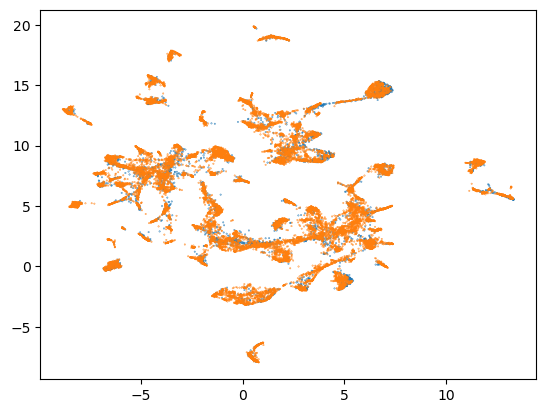

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
levels, categories = pd.factorize(newMetaData)
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, c=colors)

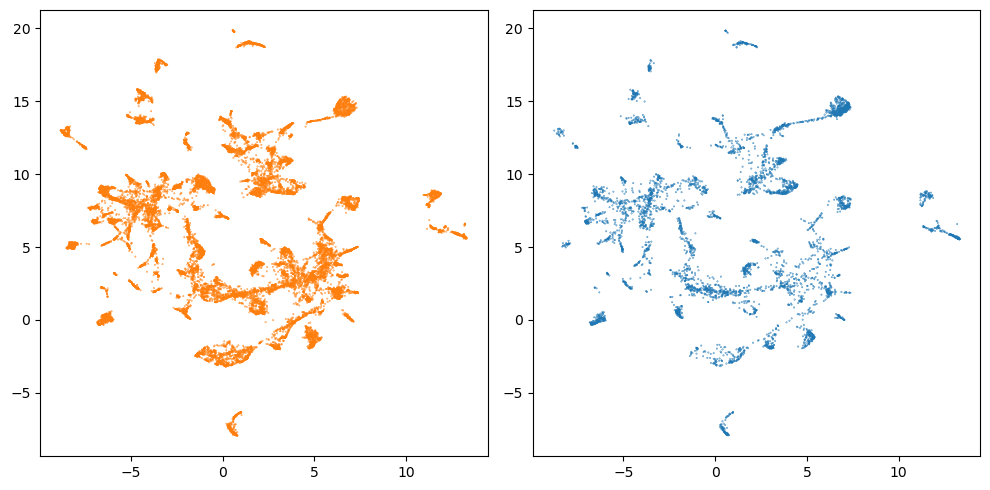

In [26]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1, 2, 1)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([0, 1]), [5000, val_data.shape[0]], axis=0))
fig.add_subplot(1, 2, 2)
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, c=colors, alpha=np.repeat(np.array([1, 0]), [5000, val_data.shape[0]], axis=0))
fig.tight_layout()